In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))
from IPython.display import clear_output

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from functools import partial
import pickle
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope as ho_scope
from collections import defaultdict
from itertools import product

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


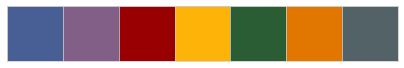

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# set option for palette argument
my_palette = ['xkcd:' + c for c in mp.my_colors]

In [6]:
# read in actor dataset
df = pd.read_json('../../data_wrangling/data/capstone2_optimized_target_ds.json')

In [7]:
# observe dimensionality of dataset
df.shape

(11610, 28)

In [8]:
# separate data into features and target
X = df.drop('revenue', axis=1)
y = df['revenue']

In [9]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

For this analysis, I will use a custom optimization function to perform gradient descent.<br>
XGBoost needs a twice differentiable function to optimize.<br>
My target has a broad range of scale, which will give both large and small errors.<br>
The Huber loss behaves like RMSE for small errors and MAE for larger values.<br>
Since it is not twice differentiable, I will need to use the PseudoHuber loss, instead.<br>
I believe this choice is better suited to optimize the model selection over either RMSE or MAE, alone.

The PseudoHuber loss has a hyperparameter, delta, that needs to be chosen.<br>
This will determine the region where the function will switch between behaving like either RMSE or MAE.

In [10]:
def huber(loss, delta):
    """Return Huber loss from original loss and chosen delta"""
    loss = np.abs(loss)
    flag = loss > delta
    huber_loss = (~flag) * (0.5 * loss ** 2) - (flag) * delta * (0.5 * delta - loss)
    
    return huber_loss

In [11]:
def plot_losses(losses):
    """Plot original error and returned Huber loss"""
    plt.title('Model Error vs. Huber Loss')
    
    # get MSE
    mse_loss = losses ** 2
    plt.plot(losses, mse_loss, label='MSE', color='k', linestyle='-.')
    # get MAE
    mae_loss = np.abs(losses)
    plt.plot(losses, mae_loss, label='MAE', color=mp.colors(5), linestyle='--')
    
    for delta in range(100, 900 + 1, 200):
        # get Huber loss
        huber_loss = huber(losses, delta)
        # plot losses
        sns.lineplot(losses, huber_loss, label=delta)
    
    # set scale to best display any range of losses
    y_scale = int(np.log10(losses[-1]))
    y_limit = losses[-1] ** 2 / (2 * 10 ** (y_scale - 3))
    plt.ylim(0, y_limit)
    
    plt.xlabel('Error')
    plt.ylabel('Huber Loss')
    
    plt.legend(title='Delta', loc=6, bbox_to_anchor=(1, 0.5))

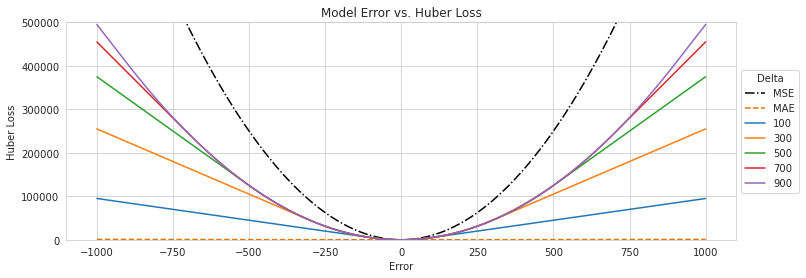

In [12]:
# observe regularization of small errors using Huber loss
plot_losses(np.linspace(-1e3, 1e3, 100))

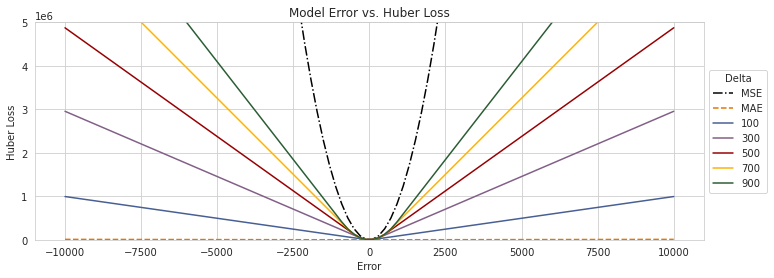

In [13]:
# observe regularization of moderate errors using Huber loss
plot_losses(np.linspace(-1e4, 1e4, 100))

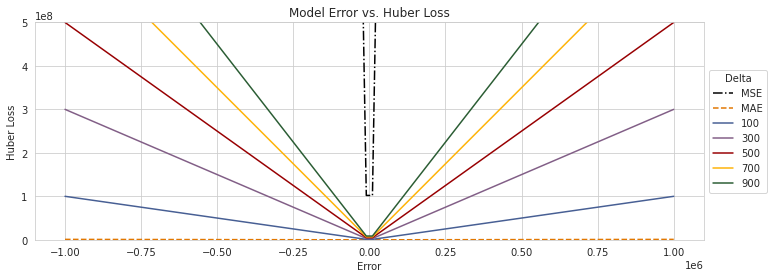

In [14]:
# observe regularization of large errors using Huber loss
plot_losses(np.linspace(-1e6, 1e6, 100))

In [15]:
def gradient(labels, preds, delta):
    """Return gradient of Pseudo-Huber loss"""
    errors = preds - labels
    scale = delta**2 + errors**2
    grad = errors * np.power(scale, -0.5)
    
    return grad

In [16]:
def hessian(labels, preds, delta):
    """Return hessian of Pseudo-Huber loss"""
    errors = labels - preds
    scale = delta**2 + errors**2
    hess = delta**2 * np.power(scale, -3/2.0)
    
    return hess

In [17]:
def pseudo_huber(preds, dtrain, delta):
    """Return gradient and hessian of Pseudo-Huber loss"""
    labels = dtrain.get_label()
    grad = gradient(labels, preds, delta=delta)
    hess = hessian(labels, preds, delta=delta)
    
    return grad, hess

My target has been transformed using the log scale.<br>
I need to convert the test data and predictions back to dollar amounts, before getting the errors.

In [18]:
def eval_error(preds, dtrain):
    """Return mean absolute error in dollar values"""
    labels = dtrain.get_label()
    errors = np.exp(preds) - np.exp(labels)
    mae_dollars = np.mean(np.absolute(errors))
    
    return '$_mae', mae_dollars

Accuracy and performace can vary between different training methods.<br>
I will create a custon cross validation function from scratch to compare with the built in XGBoost version.<br>
I will compare the differences between using CPU and GPU computing, as well.

In [19]:
def get_xgbr_train(dtrain, dtest, delta, processor_type, params={}, max_boost_round=500):
    """Return trained Learning API XGBoost model and training results"""
    # instantiate empty dict to store evaluation metrics
    results = {}
    
    # add operational parameters
    params['tree_method'] = processor_type
    params['disable_default_eval_metric'] = 1
    
    # set evaluation data
    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    
    # establish early stopping limit
    early_stopping_limit = 100
    
    # use partial function to enable selection of delta parameter of PseudoHuber Loss
    train_pseudohuber = partial(pseudo_huber, delta=delta)
    
    # instantiate regressor
    model = xgb.train(params, dtrain, num_boost_round=max_boost_round, evals=watchlist, 
                      obj=train_pseudohuber, feval=eval_error, 
                      early_stopping_rounds=early_stopping_limit, 
                      evals_result=results, verbose_eval=False)
            
    return model, results

This is the custom cross validation function built from scratch.

In [20]:
def get_scratch_cv(
    features, target, delta, processor_type, params={}, max_boost_round=500):
    """Return CV results with statistics from best iteration of each fold"""
    # create default dict to hold MAE statistics from each fold
    cv_results = defaultdict(list)
    
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)
    
    # split data and run 10 folds
    for train_index, test_index in folds.split(features, target):
        train_features = features.iloc[train_index]
        train_target = target.iloc[train_index]
        test_features = features.iloc[test_index]
        test_target = target.iloc[test_index]
        
        # convert data for faster training
        dtrain = xgb.DMatrix(data=train_features, label=train_target, nthread=-1)
        dtest = xgb.DMatrix(data=test_features, label=test_target, nthread=-1)
        
        # instantiate and fit model
        model, results = get_xgbr_train(
            dtrain, dtest, delta, processor_type, params, max_boost_round)
        
        # get iteration with best test MAE
        best_iter = model.best_iteration
        # get training MAE from iteration of best test MAE
        train_mae = results['train']['$_mae'][best_iter]
        # get best test MAE
        test_mae = results['test']['$_mae'][best_iter]
        # calculate hybrid loss for each fold
        hybrid_mae = 2 * test_mae - train_mae
        # calculate train to test scores ratio for each fold
        tt_score = train_mae / test_mae
        # get boosting round with best CV test MAE average
        n_boost = best_iter + 1 
        
        # save fold results to default dict
        cv_results['hybrid_mae'].append(hybrid_mae)
        cv_results['train_mae'].append(train_mae)
        cv_results['test_mae'].append(test_mae)
        cv_results['tt_score'].append(tt_score)
        cv_results['n_boost'].append(n_boost)

    return cv_results

Here is the function which uses XGBoost's built in cross validation method.

In [21]:
def get_xgbr_cv(features, target, delta, processor_type, params={}, max_boost_round=500):
    """Return Learning API XGBoost CV evaluation results"""
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)

    # convert data for faster training
    dtrain = xgb.DMatrix(data=features, label=target, nthread=-1)

    # add operational parameters
    params['tree_method'] = processor_type
    params['disable_default_eval_metric'] = 1

    # use partial function to enable selection of delta parameter of PseudoHuber Loss
    train_pseudohuber = partial(pseudo_huber, delta=delta)
    
    # establish early stopping limit
    early_stopping_limit = 100
    
    # create dict to hold scores for best boosting round
    cv_results = {}
    
    # get cross validation history
    cv_hist = xgb.cv(params, dtrain, num_boost_round=max_boost_round, nfold=10, 
                     folds=folds, obj=train_pseudohuber, feval=eval_error, 
                     early_stopping_rounds=early_stopping_limit, 
                     verbose_eval=False, seed = 27)
    
    # get index of boosting round with best CV test MAE average
    best_index = cv_hist['test-$_mae-mean'].argmin()
    # get CV training MAE average from best boosting round
    train_mae = cv_hist.iloc[best_index]['train-$_mae-mean']
    # get best CV test MAE average
    test_mae = cv_hist.iloc[best_index]['test-$_mae-mean']
    # calculate hybrid loss for each fold
    hybrid_mae = 2 * test_mae - train_mae
    # calculate train to test scores ratio for each fold
    tt_score = train_mae / test_mae
    # get boosting round with best CV test MAE average
    n_boost = best_index + 1
    
    # save results to default dict
    cv_results['hybrid_mae'] = hybrid_mae
    cv_results['train_mae'] = train_mae
    cv_results['test_mae'] = test_mae
    cv_results['tt_score'] = tt_score
    cv_results['n_boost'] = n_boost

    return cv_results

First, I will select an optimum delta hyperparameter.<br>
The choice will depend on the errors produced from a base model, before tuning any of its hyperparameters.

In [22]:
def make_money(number):
    """Return dollar formatted string"""
    dollar = '${:,.2f}'.format(number)
    
    return dollar

In [23]:
def print_cv_mae(features, target, delta, cv_type, processor_type):
    """Print average mean absolute errors and boosting rounds from 10 fold cv"""
    # get results from 10 fold cross validation
    cv_results = cv_type(features, target, delta, processor_type)
    # get overall average test MAE of the 10 folds
    test_mean = np.mean(cv_results['test_mae'])
    # get overall average hybrid MAE of the 10 folds
    hybrid_mean = np.mean(cv_results['hybrid_mae'])
    # get average training to test scores ratio
    tt_score_mean = np.mean(cv_results['tt_score'])
    # get average number of boosting rounds
    n_boost = np.mean(cv_results['n_boost'])
    
    print('Delta: {}\nHybrid MAE: {}\nTest MAE: {}\nOverfit Ratio: {}\nBoost Rounds: {}\n'\
          .format(delta, make_money(hybrid_mean), make_money(test_mean), 
                  tt_score_mean, int(n_boost)))

In [24]:
%%time
# observe average custom CV scores for delta=100
print_cv_mae(X_train, y_train, 1e2, get_scratch_cv, 'gpu_hist')

Delta: 100.0
Hybrid MAE: $45,572,962.60
Test MAE: $38,044,088.80
Overfit Ratio: 0.8045517247861527
Boost Rounds: 258

CPU times: user 11.3 s, sys: 189 ms, total: 11.4 s
Wall time: 11.5 s


In [25]:
%%time
# observe average custom CV scores for delta=500
print_cv_mae(X_train, y_train, 5e2, get_scratch_cv, 'gpu_hist')

Delta: 500.0
Hybrid MAE: $44,762,937.60
Test MAE: $41,075,910.00
Overfit Ratio: 0.9135311547363416
Boost Rounds: 270

CPU times: user 10.3 s, sys: 113 ms, total: 10.4 s
Wall time: 10.4 s


In [26]:
%%time
# observe average custom CV scores for delta=1000
print_cv_mae(X_train, y_train, 1e3, get_scratch_cv, 'gpu_hist')

Delta: 1000.0
Hybrid MAE: $45,420,161.20
Test MAE: $43,709,647.20
Overfit Ratio: 0.9636547435487473
Boost Rounds: 251

CPU times: user 9.16 s, sys: 86.4 ms, total: 9.25 s
Wall time: 9.26 s


In [27]:
%%time
# observe average custom CV scores for delta=2000
print_cv_mae(X_train, y_train, 2e3, get_scratch_cv, 'gpu_hist')

Delta: 2000.0
Hybrid MAE: $49,957,249.20
Test MAE: $49,714,072.80
Overfit Ratio: 0.9973390102168759
Boost Rounds: 142

CPU times: user 5.71 s, sys: 76.3 ms, total: 5.79 s
Wall time: 5.8 s


Speed up is only slightly better with higher deltas in this range.<br>
The excellent overfit ratio resulting from the largest delta value is not worth the significant increase in the test error.

I would prefer to start with a model that has an overfit ratio that is no lower than 87%.<br>
This was the value I was able to achieve after hyperparameter tuning when using the MAE loss to optimize training.<br>
Later, I will try to improve that value through the tuning of the regularization hyperparameters.

Also, the best test score reached, so far, was $41,215,414.04 obtained after the target optimization.<br>
I will try to improve on this value, as well.

I will continue to focus on the hybrid loss, simultaneously optimizing both test and overfit values.

In [28]:
def test_deltas(features, target, delta_min, delta_max, cv_type, processor_type):
    """Return DataFrame with CV results over range of PseudoHuber deltas"""
    # create iterable of deltas
    deltas = np.arange(delta_min, delta_max + 1, 100)
    #create default dict to store CV results
    revenue_dict = defaultdict(list)
    
    # create ten delta values to test
    for delta in deltas:
        print('Working on Delta = ', delta, '...')
        clear_output(wait=True)
        
        # create default dict to hold average CV scores
        cv_averages = defaultdict(list)
        
        # get results from 10 fold cross validation
        cv_results = cv_type(features, target, delta, processor_type)
        
        # remove undesired field
        del(cv_results['train_mae'])
        
        # create list of keys from dict returned from selected CV function
        keys = list(cv_results.keys())
        
        # get overall average scores and number of boosting rounds of the 10 folds
        hybrid_mae_ave = np.mean(cv_results['hybrid_mae'])
        test_mae_ave = np.mean(cv_results['test_mae'])
        tt_ave = np.mean(cv_results['tt_score'])
        n_estimator_ave = int(np.mean(cv_results['n_boost']))
        
        # store results for final comparison
        revenue_dict[delta].append(hybrid_mae_ave)
        revenue_dict[delta].append(test_mae_ave)
        revenue_dict[delta].append(tt_ave)
        revenue_dict[delta].append(n_estimator_ave)
        
    print('Finished all {} deltas.'.format(len(deltas)))
    
    # transfer results to DataFrame
    results_df = pd.DataFrame(
        revenue_dict, index=keys).transpose().sort_values('hybrid_mae')
    
    return results_df

In [29]:
%%time
# get DataFrame of results for deltas between 100 and 1000 using custom CV on CPU
scr_cpu_results_df = test_deltas(X_train, y_train, 1e2, 1e3, get_scratch_cv, 'auto')
scr_cpu_results_df

Finished all 10 deltas.
CPU times: user 42min 51s, sys: 1min 37s, total: 44min 28s
Wall time: 1min 51s


hybrid_mae    test_mae  tt_score  n_boost
700.0   43965217.6  40588677.2  0.919554    348.0
500.0   44056587.2  40224216.8  0.908297    314.0
600.0   44101879.6  40449109.6  0.911576    340.0
900.0   44174696.0  41541934.8  0.939543    361.0
300.0   44420664.0  39027876.8  0.864673    327.0
800.0   44455822.0  41177122.4  0.922475    370.0
200.0   44762464.8  38429674.4  0.838744    330.0
400.0   44818889.8  39698095.6  0.873975    350.0
1000.0  44931992.8  42251774.4  0.939266    399.0
100.0   47060862.2  37725300.0  0.755423    340.0

In [30]:
%%time
# get DataFrame of results for deltas between 100 and 1000 using custom CV on GPU
scr_gpu_results_df = test_deltas(X_train, y_train, 1e2, 1e3, get_scratch_cv, 'gpu_hist')
scr_gpu_results_df

Finished all 10 deltas.
CPU times: user 1min 45s, sys: 1.17 s, total: 1min 46s
Wall time: 1min 42s


hybrid_mae    test_mae  tt_score  n_boost
200.0   43479779.6  38621209.6  0.876798    247.0
300.0   43705574.6  39417957.6  0.894585    248.0
400.0   43894833.2  40490916.8  0.919120    205.0
800.0   44390584.0  42032241.2  0.947026    271.0
700.0   44404184.4  41516356.4  0.933708    273.0
600.0   44459069.6  41299218.8  0.926914    274.0
900.0   44660538.4  42502716.4  0.951898    324.0
500.0   44762937.6  41075910.0  0.913531    270.0
1000.0  45420161.2  43709647.2  0.963655    251.0
100.0   45572962.6  38044088.8  0.804552    258.0

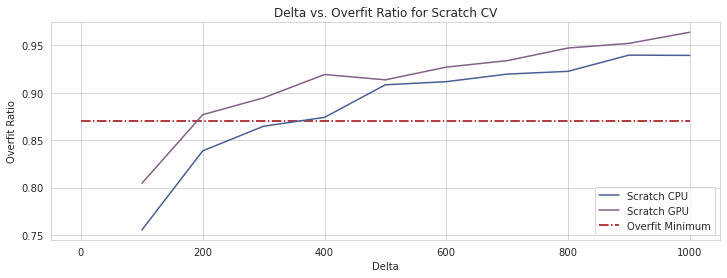

In [31]:
# plot custom cross validation results for deltas between 100 and 1000

plt.hlines(0.87, xmin=0, xmax=1000, label='Overfit Minimum', 
           linestyles='dashdot', color=mp.colors(2))

sns.lineplot(x=scr_cpu_results_df.index, y=scr_cpu_results_df['tt_score'], 
             label='Scratch CPU', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df.index, y=scr_gpu_results_df['tt_score'], 
             label='Scratch GPU', color=mp.colors(1))

plt.xlabel('Delta')
plt.ylabel('Overfit Ratio')

plt.legend(loc=4)
plt.title('Delta vs. Overfit Ratio for Scratch CV');

Scratch CPU: delta >= 400<br>
Scratch GPU: delta >= 200

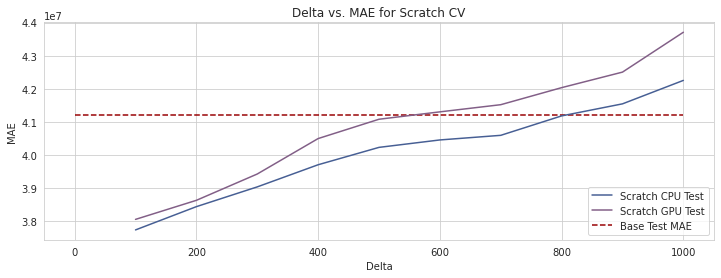

In [32]:
# plot custom cross validation results for deltas between 100 and 1000

plt.hlines(4.121541404e7, xmin=0, xmax=1000, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))


sns.lineplot(x=scr_cpu_results_df.index, y=scr_cpu_results_df['test_mae'], 
             label='Scratch CPU Test', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df.index, y=scr_gpu_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))

plt.xlabel('Delta')
plt.ylabel('MAE')

plt.legend(loc=4)
plt.title('Delta vs. MAE for Scratch CV');

Scratch CPU: delta <= 800<br>
Scratch GPU: delta <= 500

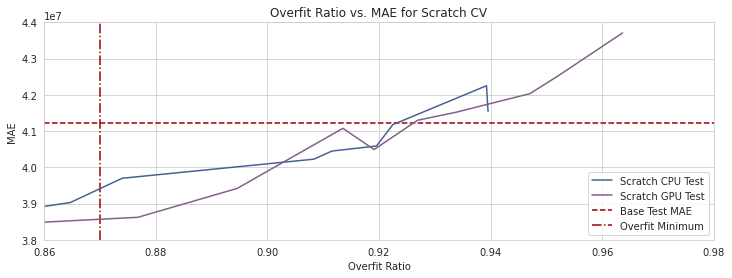

In [33]:
# plot custom cross validation results for deltas between 100 and 1000

plt.xlim(left=0.86, right=0.98)
plt.ylim(bottom=3.8e7, top=4.4e7)

plt.hlines(4.121541404e7, xmin=0.86, xmax=0.98, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))
plt.vlines(0.87, ymin=3.8e7, ymax=4.4e7, label='Overfit Minimum', 
           linestyles='dashdot', color=mp.colors(2))

sns.lineplot(x=scr_cpu_results_df['tt_score'], y=scr_cpu_results_df['test_mae'], 
             label='Scratch CPU Test', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df['tt_score'], y=scr_gpu_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))

plt.xlabel('Overfit Ratio')
plt.ylabel('MAE')

plt.legend(loc=4)
plt.title('Overfit Ratio vs. MAE for Scratch CV');

Scratch CPU: 400 <= delta <= 800<br>
Scratch GPU: 200 <= delta <= 500

In [34]:
%%time
# get DataFrame of results for deltas between 100 and 1000 using XGBoost CV on CPU
cv_cpu_results_df = test_deltas(X_train, y_train, 1e2, 1e3, get_xgbr_cv, 'auto')
cv_cpu_results_df

Finished all 10 deltas.
CPU times: user 51min 48s, sys: 1min 52s, total: 53min 40s
Wall time: 2min 15s


hybrid_mae    test_mae  tt_score  n_boost
400.0   44850369.6  39871431.6  0.875125    316.0
900.0   45282059.2  41638768.4  0.912502    500.0
700.0   45476608.8  40762290.4  0.884346    492.0
600.0   45479106.8  40595272.8  0.879695    434.0
800.0   45569765.2  41231620.0  0.894786    499.0
1000.0  45663267.6  42323929.2  0.921100    497.0
500.0   46275119.6  40278566.8  0.851123    500.0
300.0   46535622.2  39150027.2  0.811351    483.0
200.0   46997729.2  38478446.0  0.778596    454.0
100.0   50402031.2  37931202.4  0.671225    471.0

In [35]:
%%time
# get DataFrame of results for deltas between 100 and 1000 using custom CV on GPU
cv_gpu_results_df = test_deltas(X_train, y_train, 1e2, 1e3, get_xgbr_cv, 'gpu_hist')
cv_gpu_results_df

Finished all 10 deltas.
CPU times: user 1min 57s, sys: 1.13 s, total: 1min 58s
Wall time: 1min 54s


hybrid_mae    test_mae  tt_score  n_boost
300.0   43962986.8  39701502.8  0.892662    216.0
400.0   44046468.0  40704904.8  0.917908    177.0
700.0   44902515.6  41702804.0  0.923273    276.0
600.0   44984428.4  41618518.8  0.919125    242.0
800.0   45389870.4  42248733.2  0.925651    337.0
500.0   45524258.4  41242237.6  0.896174    298.0
900.0   45707219.6  42789280.4  0.931807    396.0
1000.0  46289810.4  43869550.4  0.944831    367.0
100.0   46787113.6  38237432.8  0.776405    286.0
200.0   46880596.4  38753501.6  0.790287    421.0

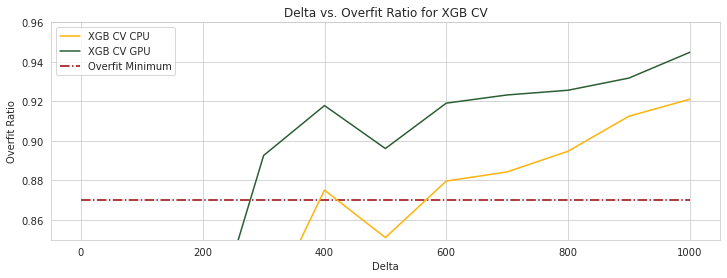

In [36]:
# plot XGBoost cross validation results for deltas between 100 and 1000

plt.ylim(bottom=0.85, top=0.96)

plt.hlines(0.87, xmin=0, xmax=1000, label='Overfit Minimum', 
           linestyles='dashdot', color=mp.colors(2))

sns.lineplot(x=cv_cpu_results_df.index, y=cv_cpu_results_df['tt_score'], 
             label='XGB CV CPU', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df.index, y=cv_gpu_results_df['tt_score'], 
             label='XGB CV GPU', color=mp.colors(4))

plt.xlabel('Delta')
plt.ylabel('Overfit Ratio')

plt.legend(loc=2)
plt.title('Delta vs. Overfit Ratio for XGB CV');

XGB CPU: delta = 400 , or delta >= 600<br>
XGB GPU: delta >= 300

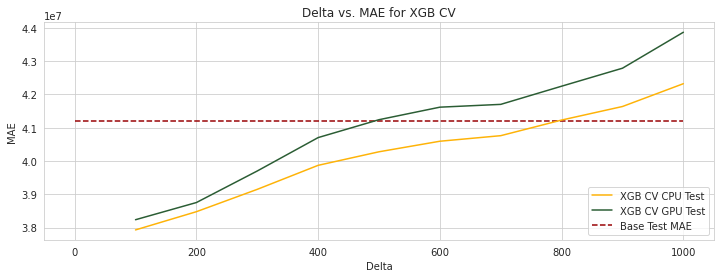

In [37]:
# plot XGBoost cross validation results for deltas between 100 and 1000


plt.hlines(4.121541404e7, xmin=0, xmax=1000, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))

sns.lineplot(x=cv_cpu_results_df.index, y=cv_cpu_results_df['test_mae'], 
             label='XGB CV CPU Test', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df.index, y=cv_gpu_results_df['test_mae'], 
             label='XGB CV GPU Test', color=mp.colors(4))

plt.xlabel('Delta')
plt.ylabel('MAE')

plt.legend(loc=4)
plt.title('Delta vs. MAE for XGB CV');

XGB CPU: delta <= 700<br>
XGB GPU: delta <= 400

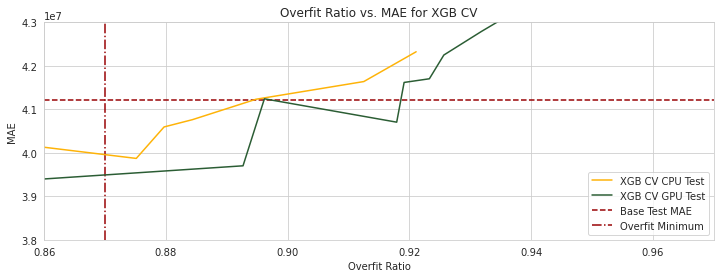

In [38]:
# plot XGBoost cross validation results for deltas between 100 and 1000

plt.xlim(left=0.86, right=0.97)
plt.ylim(bottom=3.8e7, top=4.3e7)

plt.hlines(4.121541404e7, xmin=0.86, xmax=0.98, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))
plt.vlines(0.87, ymin=3.8e7, ymax=4.3e7, label='Overfit Minimum', 
           linestyles='dashdot', color=mp.colors(2))

sns.lineplot(x=cv_cpu_results_df['tt_score'], y=cv_cpu_results_df['test_mae'], 
             label='XGB CV CPU Test', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df['tt_score'], y=cv_gpu_results_df['test_mae'], 
             label='XGB CV GPU Test', color=mp.colors(4))

plt.xlabel('Overfit Ratio')
plt.ylabel('MAE')

plt.legend(loc=4)
plt.title('Overfit Ratio vs. MAE for XGB CV');

XGB CPU: delta = 400, or 600 >= delta >= 700<br>
XGB GPU: 300 >= delta >= 400

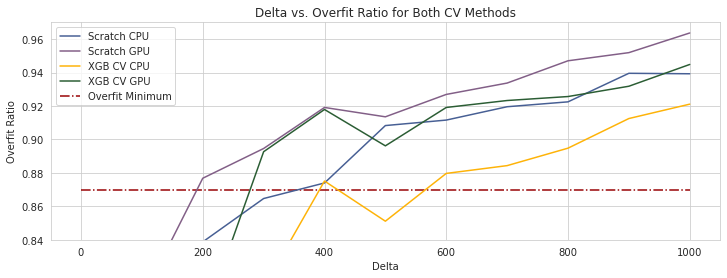

In [39]:
# plot cross validation results for deltas between 100 and 1000 for both CV methods

plt.ylim(bottom=0.84, top=0.97)


plt.hlines(0.87, xmin=0, xmax=1000, label='Overfit Minimum', 
           linestyles='dashdot', color=mp.colors(2))

sns.lineplot(x=scr_cpu_results_df.index, y=scr_cpu_results_df['tt_score'], 
             label='Scratch CPU', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df.index, y=scr_gpu_results_df['tt_score'], 
             label='Scratch GPU', color=mp.colors(1))
sns.lineplot(x=cv_cpu_results_df.index, y=cv_cpu_results_df['tt_score'], 
             label='XGB CV CPU', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df.index, y=cv_gpu_results_df['tt_score'], 
             label='XGB CV GPU', color=mp.colors(4))

plt.xlabel('Delta')
plt.ylabel('Overfit Ratio')

plt.legend(loc=2)
plt.title('Delta vs. Overfit Ratio for Both CV Methods');

Scratch CPU: delta => 400<br>
Scratch GPU: delta => 200<br>
XGB CPU: delta = 400 , or delta >= 600<br>
XGB GPU: delta >= 300

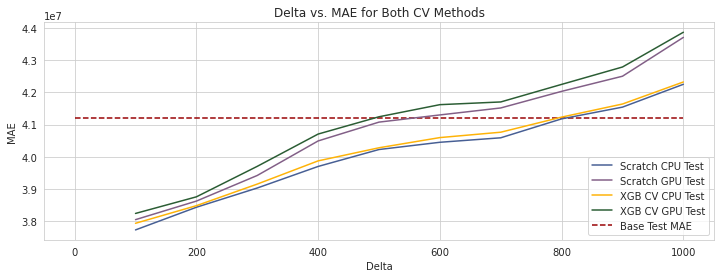

In [40]:
# plot cross validation results for deltas between 100 and 1000 for both CV methods

plt.hlines(4.121541404e7, xmin=0, xmax=1000, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))

sns.lineplot(x=scr_cpu_results_df.index, y=scr_cpu_results_df['test_mae'], 
             label='Scratch CPU Test', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df.index, y=scr_gpu_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))
sns.lineplot(x=cv_cpu_results_df.index, y=cv_cpu_results_df['test_mae'], 
             label='XGB CV CPU Test', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df.index, y=cv_gpu_results_df['test_mae'], 
             label='XGB CV GPU Test', color=mp.colors(4))

plt.xlabel('Delta')
plt.ylabel('MAE')

plt.legend(loc=4)
plt.title('Delta vs. MAE for Both CV Methods');

Scratch CPU: delta <= 800<br>
Scratch GPU: delta <= 500<br>
XGB CPU: delta <= 700<br>
XGB GPU: delta <= 400

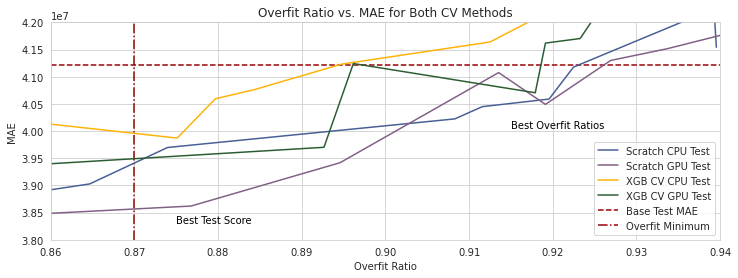

In [41]:
# plot cross validation results for deltas between 100 and 1000 for both CV methods

plt.xlim(left=0.86, right=0.94)
plt.ylim(bottom=3.8e7, top=4.2e7)

plt.hlines(4.121541404e7, xmin=0.86, xmax=0.94, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))
plt.vlines(0.87, ymin=3.8e7, ymax=4.2e7, label='Overfit Minimum', 
           linestyles='dashdot', color=mp.colors(2))
plt.text(x=0.875, y=3.83e7, s='Best Test Score', color='k')
plt.text(x=0.915, y=4.005e7, s='Best Overfit Ratios', color='k')

sns.lineplot(x=scr_cpu_results_df['tt_score'], y=scr_cpu_results_df['test_mae'], 
             label='Scratch CPU Test', color=mp.colors(0))
sns.lineplot(x=scr_gpu_results_df['tt_score'], y=scr_gpu_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))
sns.lineplot(x=cv_cpu_results_df['tt_score'], y=cv_cpu_results_df['test_mae'], 
             label='XGB CV CPU Test', color=mp.colors(3))
sns.lineplot(x=cv_gpu_results_df['tt_score'], y=cv_gpu_results_df['test_mae'], 
             label='XGB CV GPU Test', color=mp.colors(4))

plt.xlabel('Overfit Ratio')
plt.ylabel('MAE')

plt.legend(loc=4)
plt.title('Overfit Ratio vs. MAE for Both CV Methods');

Scratch CPU: 400 <= delta <= 800<br>
Scratch GPU: 200 <= delta <= 500<br>
XGB CPU: delta = 400, or 600 >= delta >= 700<br>
XGB GPU: 300 >= delta >= 400

In [42]:
%%time
# get statistics for using CPU Scratch CV with delta = 700
{k: np.mean(v) for k, v in get_scratch_cv(
    X_train, y_train, 7e2, 'auto').items() if k is not 'train_mae'}

CPU times: user 4min 9s, sys: 9.28 s, total: 4min 18s
Wall time: 10.9 s


{'hybrid_mae': 43965217.6,
 'test_mae': 40588677.2,
 'tt_score': 0.9195536492338586,
 'n_boost': 348.1}

In [43]:
%%time
# get statistics for using GPU Scratch CV with delta = 200
{k: np.mean(v) for k, v in get_scratch_cv(
    X_train, y_train, 2e2, 'gpu_hist').items() if k is not 'train_mae'}

CPU times: user 14.2 s, sys: 395 ms, total: 14.6 s
Wall time: 10.6 s


{'hybrid_mae': 43479779.6,
 'test_mae': 38621209.6,
 'tt_score': 0.8767978126726298,
 'n_boost': 247.3}

In [44]:
%%time
# get statistics for using CPU XGB CV with delta = 400
{k: v for k, v in get_xgbr_cv(
    X_train, y_train, 4e2, 'auto').items() if k is not 'train_mae'}

CPU times: user 4min 35s, sys: 9.92 s, total: 4min 45s
Wall time: 12 s


{'hybrid_mae': 44850369.6,
 'test_mae': 39871431.6,
 'tt_score': 0.8751251760922475,
 'n_boost': 316}

In [45]:
%%time
# get statistics for using GPU XGB CV with delta = 300
{k: v for k, v in get_xgbr_cv(
    X_train, y_train, 3e2, 'gpu_hist').items() if k is not 'train_mae'}

CPU times: user 12.7 s, sys: 303 ms, total: 13 s
Wall time: 9.6 s


{'hybrid_mae': 43962986.8,
 'test_mae': 39701502.8,
 'tt_score': 0.8926618969194284,
 'n_boost': 216}

Choosing GPU Scratch CV with delta = 200.

In [46]:
%%time
# get DataFrame of results for deltas between 1000 and 2000 using custom CV on GPU
delta_2000_results_df = test_deltas(X_train, y_train, 1e3, 2e3, get_scratch_cv, 'gpu_hist')
delta_2000_results_df

Finished all 11 deltas.
CPU times: user 1min 22s, sys: 1.04 s, total: 1min 23s
Wall time: 1min 23s


hybrid_mae    test_mae  tt_score  n_boost
1000.0  45420161.2  43709647.2  0.963655    251.0
1100.0  45521058.8  44122610.0  0.970997    225.0
1200.0  45732016.0  44657315.6  0.978448    222.0
1300.0  46240810.8  45305756.4  0.981858    199.0
1400.0  46620731.2  45944864.0  0.988089    233.0
1500.0  47306155.6  46427630.0  0.983834    275.0
1600.0  47461468.4  47128886.8  0.995642    193.0
1700.0  48274975.2  47806958.8  0.993099    209.0
1800.0  48683620.8  48480055.6  0.998244    170.0
1900.0  49239692.8  49081133.6  0.999171    154.0
2000.0  49957249.2  49714072.8  0.997339    142.0

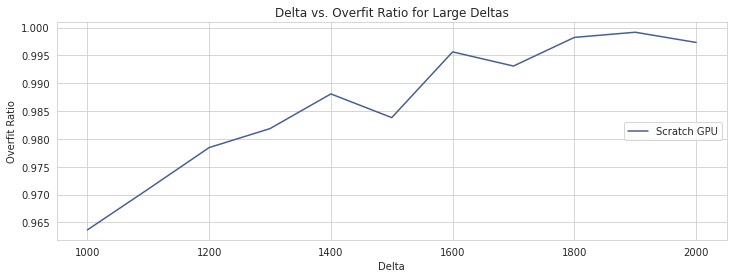

In [47]:
# plot cross validation results over deltas

sns.lineplot(x=delta_2000_results_df.index, y=delta_2000_results_df['tt_score'], 
             label='Scratch GPU', color=mp.colors(0))

plt.xlabel('Delta')
plt.ylabel('Overfit Ratio')

plt.legend(loc=5)
plt.title('Delta vs. Overfit Ratio for Large Deltas');

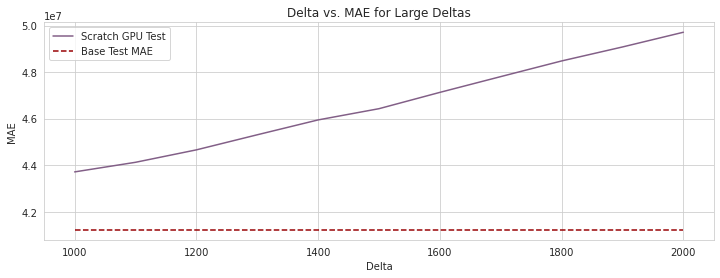

In [48]:
# plot cross validation results over deltas

plt.hlines(4.121541404e7, xmin=1000, xmax=2000, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))

sns.lineplot(x=delta_2000_results_df.index, y=delta_2000_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))

plt.xlabel('Delta')
plt.ylabel('MAE')

plt.legend(loc=2)
plt.title('Delta vs. MAE for Large Deltas');

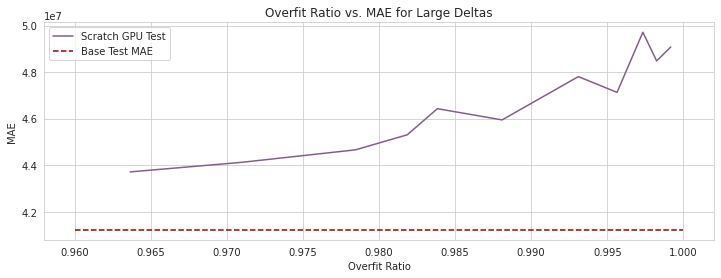

In [49]:
# plot cross validation results over deltas

plt.hlines(4.121541404e7, xmin=0.96, xmax=1.0, label='Base Test MAE', 
           linestyles='dashed', color=mp.colors(2))

sns.lineplot(x=delta_2000_results_df['tt_score'], y=delta_2000_results_df['test_mae'], 
             label='Scratch GPU Test', color=mp.colors(1))

plt.xlabel('Overfit Ratio')
plt.ylabel('MAE')

plt.legend(loc=2)
plt.title('Overfit Ratio vs. MAE for Large Deltas');

There are a lot of hyperparameters to tune.<br>
I will break them into three groups.<br>
 - Tree Structure Based Complexity Moderation (Bias/Variance Trade-off)
     - learning_rate: Controls amount errors are corrected from previous round 
         - Lower --> Smaller Weights --> Less Complexity
     - max_depth: Controls how deep trees are allowed to grow 
         - Higher --> More Layers in Trees --> More Complexity
     - min_child_weight: Controls weight required to create new node 
         - Higher --> More Samples Needed To Split a Node --> Less Complexity
     - n_estimators: The number of boosting rounds 
         - Higher --> More Trees --> More Complixity
 - Stochastic Based Complexity Moderation (Used to Lower Variance)
     - colsample_bylevel: Fraction of features to use at each level
         - Lower --> Sample is Less Representative of Data --> Less Complexity
     - subsample: Fraction of observations to use at each boosting round
         - Lower --> Sample is Less Representative of Data --> Less Complexity
 - Regularization Based Complexity Moderation (Used to Lower Variance)
     - reg_lambda: Ridge (L2) regularization
         - Higher --> Errors are more heavily penalized --> Less Complexity

I will use the mean absolute error (MAE) as my test statistic, as opposed to the root mean squared error (RMSE).<br>
The RMSE tends to increase more rapidly than the MAE, as the sample size increases.<br>
I will be using cross validation, extensively, throughout this analysis.<br>
Hense, RMSE may be problematic, when comparing errors between training and test performances.

To get some perspective on this loss, I'll show the broad range of average revenues for the actors' movies.

In [50]:
# get average movie revenue and revenue range for all actors in training data
f'Average target: ${np.mean(np.exp(y_train)):,.2f} \
    Target Range: (${np.min(np.exp(y_train)):,.2f}, ${np.max(np.exp(y_train)):,.2f})'

'Average target: $81,851,821.32     Target Range: ($1.24, $999,601,802.16)'

With this range so wide, it is important to observe the standard deviation of the data, as well.

In [51]:
# get standard deviation of movie revenue for all actors in training data
f'Standard Deviation of Target: ${np.std(np.exp(y_train)):,.2f}'

'Standard Deviation of Target: $120,817,369.06'

Though the average error is large, it is well within one standard deviation of the target values.

I will create some residual plots, now.

In [52]:
def plot_predictions(features, target, deltas):
    """Plot observed target vs. predictions for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors
        sns.scatterplot(labels, preds, label=delta)
        sns.regplot(labels, preds, scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.legend(title='Delta')
    plt.title("Ground Truth vs Predicted")

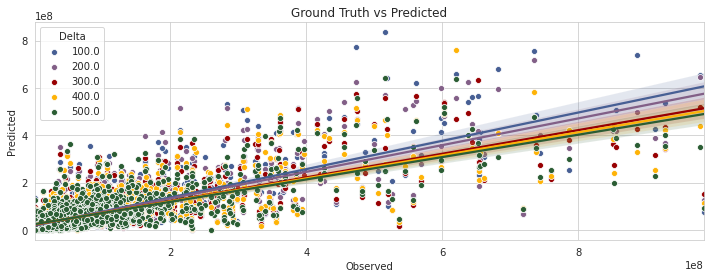

In [53]:
# plot observed target vs. predictions for a range of deltas
plot_predictions(X_train, y_train, np.arange(1e2, 5e2 + 1, 100))

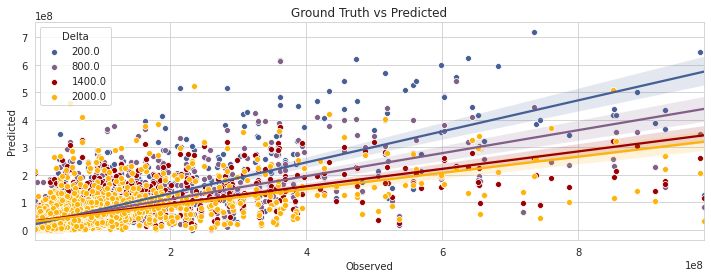

In [54]:
# plot observed target vs. predictions for a range of deltas
plot_predictions(X_train, y_train, np.arange(2e2, 2e3 + 1, 600))

There's one extreme outlier that is quite obvious.

In [55]:
def plot_residuals(features, target, deltas):
    """Plot predictions vs.residuals for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors
        sns.residplot(preds, labels, label=delta, lowess=True, 
                      scatter_kws={'s':10}, line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.legend(title='Delta')
    plt.title("Predicted vs Residuals")

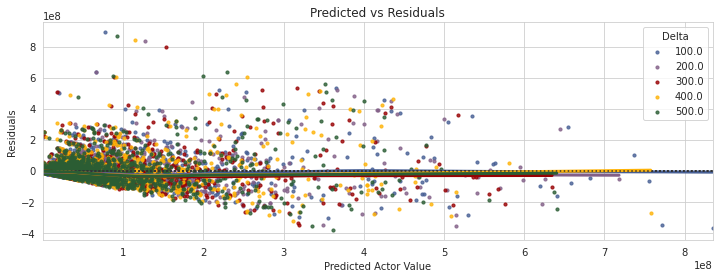

In [56]:
# plot predictions vs. residuals for a range of deltas
plot_residuals(X_train, y_train, np.arange(1e2, 5e2 + 1, 100))

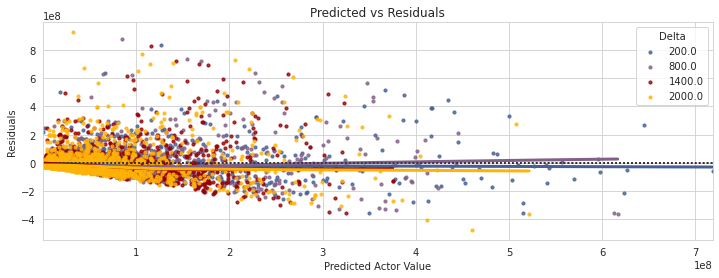

In [57]:
# plot predictions vs. residuals for a range of deltas
plot_residuals(X_train, y_train, np.arange(2e2, 2e3 + 1, 600))

Aside from the handfull of outliers, the residual appear well distributed about 0.

In [58]:
def plot_residual_distribution(features, target, deltas):
    """Plot distribution of residuals for provided deltas"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # run training and plot using different deltas
    for delta in deltas:
        # get model
        model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
        # get targets and predictions in dollar amounts
        labels = np.exp(y_test)
        preds = np.exp(model.predict(dtest))
        # plot errors        
        sns.distplot(labels - preds, label=delta, bins=300, rug=True, axlabel='Residuals')

    plt.ylabel('Frequency')
    
    plt.legend(title='Delta')
    plt.title('Distribution of Residuals')

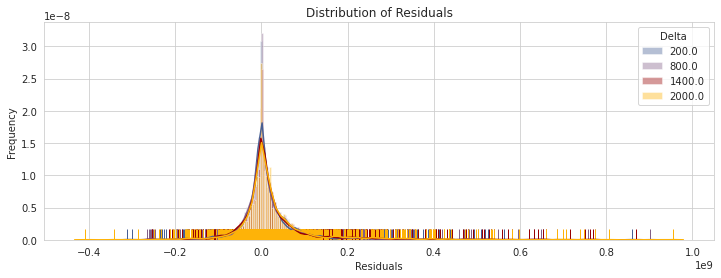

In [59]:
# plot residuals distribution for a range of deltas
plot_residual_distribution(X_train, y_train, np.arange(2e2, 2e3 + 1, 600))

The distribution of residuals appers fairly normal, aside from the extreme outliers.

I will take a look at the feature importance for the predictions

In [60]:
def plot_feature_importance(features, target, delta, importance_type):
    """Plot predictors by chosen importance to model"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # get model
    model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist')[0]
    # create dict to hold feature importance
    importance_dict = model.get_score(importance_type=importance_type)
    # plot feature importance
    sns.barplot(x=list(importance_dict.keys()), 
                y=list(importance_dict.values()), 
                palette=my_palette).set_xticklabels(importance_dict.keys(), 
                                                        rotation=70)

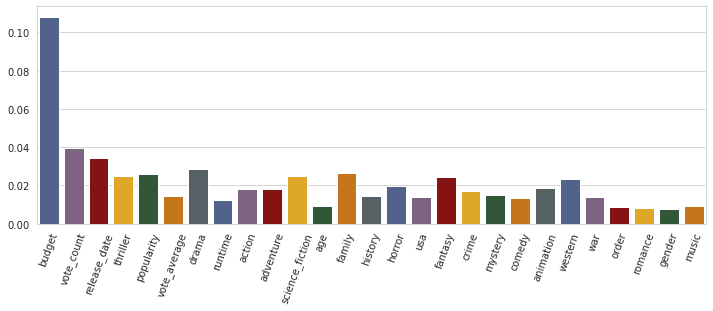

In [61]:
# plot feature importance by selected metric
plot_feature_importance(X_train, y_train, 2e2, 'gain')

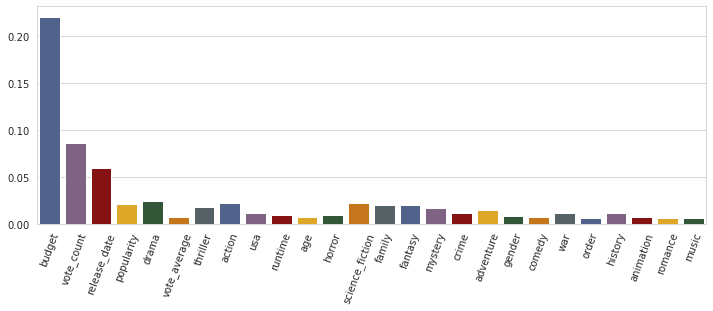

In [62]:
# plot feature importance by selected metric
plot_feature_importance(X_train, y_train, 4e2, 'gain')

It is not surprising that the budget is the most important feature for predicting revenue.<br>
I would not have expected runtime to be such a strong predictor, though.

I will perform an informed (Bayesian) search technique to find the best hyperparameters.<br>
This method has advantages over a brute force grid search, which tries all combinations of hyperparameters.<br>
It is closer to a random grid search, except the choices of parameters are based on the results of previous choices.

 > **BAYESIAN HYPERPARAMETER SEARCH**

My strategy will be to march through the hyperparameters, adding them one by one to the search.<br>
I will be looking for the best range of the current hyperparameter to keep, before progressing to the next one.<br>
This will help to reduce the number of possible local minima that the model may fall into along the search.<br>
It will reduce search time, as well, as some parameters are additive in computation time, as their ranges expand.<br>
Hense, I will be applying appropriate upper limits to those values during the search.

As hyperparameters are added, the optimal ranges for previous ones may change.<br>
I will be monitoring these needs along the way, making appropriate adjustments when necessary.<br>
I will plot cross validated results over a range of values to highlight the trade off between accuracy and overfitting.

The first hyperparameters to lock down are the number of estimators and the learning rate.<br>
Some literature suggests to begin by finding the best product of these two hyperparameters.<br>
In a nod to fluid dynamics, I will call this product the model's tree flow rate.

I'll target different numbers of trees, while searching over a range of tree flows.

I will start with observing the results of using only 10 trees.

I have a dual goal of minimizing both the test error and the degree of overfitting.<br>
I will create a custom loss function that will guide the optimization procedure to a model that fulfills both goals.<br>
This will ensure that the final model is both accurate and generalizable.

The hybrid loss will be the sum of the test loss with the difference between the test loss and the training loss.

$Hybrid Loss=Test Error + Overfit Error$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$= Test Loss + (Test Loss - Training Loss)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$= 2 * Test Loss - Training Loss$

I am using the results from a cross validation function to supply the metrics needed to construct a hybrid loss.<br>
The function returns the results from 10 folds for both the test and training scores.<br>
I will observe the ratio of average training loss to average test loss over each fold to get a sense of overfitting.<br>
The hybrid loss will be the metric that is being optimized during the search for the best estimators for each batch of trials.

In [63]:
def objective(params, features, target, delta, 
              cv_type, processor_type, max_boost_round):
    """Returns CV results for XGB model"""
    # enable iteration marker to be GLOBAL variable
    global global_iterations
    # update marker
    global_iterations += 1
    # get all scores from 10 fold cross-validation
    cv_results = cv_type(features, target, delta, 
                         processor_type, params, max_boost_round=max_boost_round)
    # get average scores from 10 fold cross-validation
    average_train_mae = np.mean(cv_results['train_mae'])
    average_test_mae = np.mean(cv_results['test_mae'])
    average_tt_ratio = np.mean(cv_results['tt_score'])
    average_hybrid_mae = np.mean(cv_results['hybrid_mae'])
    # get average number of boosting rounds
    average_n_estimators = int(np.round(np.mean(cv_results['n_boost'])))

    return {
        'trial': global_trials, 
        'batch': global_batches, 
        'iteration': global_iterations, 
        'loss': average_hybrid_mae, 
        'training_scores': average_train_mae, 
        'test_scores': average_test_mae,
        'scores_ratio': average_tt_ratio, 
        'n_boost': average_n_estimators, 
        'params': params, 
        'status': STATUS_OK
    }

In [64]:
def run_trial_batches(features, target, delta, cv_type, processor_type, 
                      hp_space, trials, batch_size=10, max_batches=10, max_boost_round=500):
    """Runs informed search trials in batches with a cap on the number of batches"""
    # enable trial marker to be GLOBAL variable (allows continuation of existing trial)
    global global_trials
    global_trials +=1
    # check for newly initialized trials object
    if not trials.losses():
        # initialize best loss and number of iterations for new trials object
        last_best = 0
        last_iters = 0
    else:
        # initialize best loss and number of iterations from imported trials object
        last_best = trials.best_trial['result']['loss']
        last_iters = len(trials.losses())
    # initialize best loss for batch
    new_best = 0
    # initialize early stop flag
    early_stop = 'GO!'
    # run optimization search over all batches
    for batch in range(max_batches):
        # check for early stop
        if early_stop == 'GO!':
            # enable batch marker to be GLOBAL variable
            global global_batches
            # update trials batch counter
            global_batches += 1
            # set iterations argument for maximum evaluations parameter of fmin function
            n_iters = batch_size * (batch + 1) + last_iters
            # use partial function to lower number of trials used to initialize warm start
            fmin_suggest = partial(tpe.suggest, n_startup_jobs=1)
            # use partial function to enable selection of trials data
            fmin_objective = partial(
                objective, features=features, target=target, delta=delta, 
                cv_type=cv_type, processor_type=processor_type, 
                max_boost_round=max_boost_round)
            # run one batch
            fmin(fn=fmin_objective, space=hp_space, max_evals=n_iters, trials=trials, 
                 algo=fmin_suggest, rstate=np.random.RandomState(27))
            # save updated results to M.2 (stores most recent trials object)
            pickle.dump(trials, open('xgbr_trials.pkl', 'wb'))
            # capture current optimal loss
            new_best = trials.best_trial['result']['loss']
            # check that batch optimized
            if last_best == new_best:
                early_stop = 'STOP!'
            last_best = new_best

The optimization search will be callable for a maximum of 10 batches with a default of 10 fits for each batch.<br>
Early stopping will be called if the loss function has not improved over a full batch from the best value of the previous batch.

Before I start the search, I want to get a trials object for the base model for easy comparison.

 > **xgbr_trials_0**

In [65]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_0 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [66]:
# create informed search space using a single default value
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 6, 6.1))
}
# call optimization function
fmin_objective = partial(objective, features=X_train, target=y_train, 
                         delta=2e2, cv_type=get_scratch_cv, 
                         processor_type='gpu_hist', max_boost_round=500)
fmin(fn=fmin_objective, space=hp_space, max_evals=1, trials=xgbr_trials_0, 
     algo=tpe.suggest, rstate=np.random.RandomState(27))

# save trials object
pickle.dump(xgbr_trials_0, open('./xgbr_trials/xgbr_trials_0.pkl', 'wb'))

100%|██████████| 1/1 [00:10<00:00, 10.57s/trial, best loss: 43479779.6]


In [67]:
def make_trials_df(trials):
    """Makes a DataFrame from results dict of objective function sorted by loss"""
    # convert dict to DataFrame
    trials_df = pd.DataFrame(trials.results)
    # extract nested parameter dicts to separate DataFrame
    params_df = pd.DataFrame(trials_df['params'].to_list()).drop(
        ['tree_method', 'disable_default_eval_metric'], axis=1)
    # combine DataFrames, clean up, and order by best losses
    trials_df = trials_df.drop(
        ['params', 'status'], axis=1).join(
        params_df).sort_values('loss', ascending=True)
    
    return trials_df

In [68]:
# get results DataFrame
trials_0_df = make_trials_df(xgbr_trials_0)
trials_0_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
0      0      0          1  43479779.6       33762639.6   38621209.6   

   scores_ratio  n_boost  max_depth  
0      0.876798      247          6

In [69]:
def print_best_trial(trials):
    # get base metrics
    base_test_loss = trials.best_trial['result']['test_scores']
    base_tt_ratio = trials.best_trial['result']['scores_ratio']
    base_hybrid_loss = trials.best_trial['result']['loss']
    base_n_boost = trials.best_trial['result']['n_boost']

    print('Hybrid Loss: {}\nTest MAE: {}\nOverfit Ratio: {}\nNum Boosters: {}'.format(
        make_money(base_hybrid_loss), make_money(base_test_loss), 
        base_tt_ratio, base_n_boost))

In [70]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Hybrid Loss: $43,479,779.60
Test MAE: $38,621,209.60
Overfit Ratio: 0.8767978126726298
Num Boosters: 247


In [71]:
# observe average CV test MAE and overfit ratio for delta=200
print_cv_mae(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist')

Delta: 200.0
Hybrid MAE: $43,479,779.60
Test MAE: $38,621,209.60
Overfit Ratio: 0.8767978126726298
Boost Rounds: 247



 > **learning_rate**

In [72]:
def scratch_grid_cv(features, target, delta, cv_type, processor_type, grid):
    """Return search grid results from custom cross validation function"""
    # extract search target hyperparameter to display
    for key, value in grid.items():
        if len(value) > 1:
            searched_param = key
    # create list of all hyperparameter combinations
    keys = grid.keys()
    values = (grid[key] for key in keys)
    combos = [dict(zip(keys, combo)) for combo in product(*values)]
    # create empty list to hold MAE from each fold
    grid_dict = defaultdict(list)
    # perform grid search
    for params in combos:
        print(searched_param, ':', params[searched_param], '...')
        # collect 10 fold cv scores for hyperparameter combination
        scores_dict = cv_type(features, target, delta, processor_type, params)
        # get average scores and trees for hyperparameter combination over each CV fold
        grid_dict['params'].append(params)
        train_mean = np.mean(scores_dict['train_mae'])
        test_mean = np.mean(scores_dict['test_mae'])
        tt_score_mean = np.mean(scores_dict['tt_score'])
        hybrid_mean = np.mean(scores_dict['hybrid_mae'])
        n_estimators_mean = np.mean(scores_dict['n_boost'])
        # update default dict with cv statistics for hyperparameter combination
        grid_dict['train_mean'].append(train_mean)
        grid_dict['test_mean'].append(test_mean)
        grid_dict['tt_mean'].append(tt_score_mean)
        grid_dict['hybrid_mean'].append(hybrid_mean)
        grid_dict['n_estimators_mean'].append(n_estimators_mean)
        grid_dict['train_std'].append(np.std(scores_dict['train_mae']))
        grid_dict['test_std'].append(np.std(scores_dict['test_mae']))
        grid_dict['hybrid_std'].append(np.std(scores_dict['hybrid_mae']))
        
        print('Hybrid MAE: {}\nTest MAE: {}\nOverfit Ratio: {}'.format(
            make_money(hybrid_mean), make_money(test_mean), tt_score_mean))
        print('Average Boosting Rounds: {}\n'.format(int(np.round(n_estimators_mean))))

    return grid_dict

In [73]:
def plot_hyperparameters(features, target, delta, cv_type, processor_type, grid):
    """Plots CV results over range of one hyperparameter"""
    # run 10 fold cv grid search and get error statistics to plot
    gs_df = pd.DataFrame(
        scratch_grid_cv(X_train, y_train, delta, cv_type, processor_type, grid))

    # plot errors over range for variable hyperparameter
    var_param = {k:v for (k, v) in grid.items() if len(v) > 1}
    for param, param_lst in var_param.items():
        # plot hybrid scores
        sns.lineplot(x=param_lst, y=gs_df['hybrid_mean'], label="Hybrid Score", lw=2)
        plt.fill_between(param_lst, gs_df['hybrid_mean'] - gs_df['hybrid_std'],
                         gs_df['hybrid_mean'] + gs_df['hybrid_std'], alpha=0.2, lw=2)
        # plot test scores
        sns.lineplot(x=param_lst, y=gs_df['test_mean'], label="Test Score", lw=2)
        plt.fill_between(param_lst, gs_df['test_mean'] - gs_df['test_std'],
                         gs_df['test_mean'] + gs_df['test_std'], alpha=0.2, lw=2)
        # plot training scores
        sns.lineplot(x=param_lst, y=gs_df['train_mean'], label="Training Score", lw=2)
        plt.fill_between(param_lst, gs_df['train_mean'] - gs_df['train_std'],
                         gs_df['train_mean'] + gs_df['train_std'], alpha=0.2, lw=2)
        
        plt.xlabel(param, fontsize=15)  
        plt.ylabel("MAE", fontsize=15)

        plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')
        plt.title('Hyperparameters vs. Losses', fontsize=15)

In [74]:
# create parameter search grid
param_grid = {
    'eta': np.linspace(0.03, 0.12, 10)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12]


eta : 0.03 ...
Hybrid MAE: $42,607,994.40
Test MAE: $40,953,918.40
Overfit Ratio: 0.9624839074236053
Average Boosting Rounds: 499

eta : 0.04 ...
Hybrid MAE: $42,241,754.80
Test MAE: $40,365,474.40
Overfit Ratio: 0.9565880721971848
Average Boosting Rounds: 499

eta : 0.05 ...
Hybrid MAE: $42,203,194.40
Test MAE: $40,084,453.60
Overfit Ratio: 0.9501180565058395
Average Boosting Rounds: 493

eta : 0.06 ...
Hybrid MAE: $42,057,394.40
Test MAE: $39,819,964.00
Overfit Ratio: 0.9465156965254652
Average Boosting Rounds: 482

eta : 0.07 ...
Hybrid MAE: $42,155,196.40
Test MAE: $39,652,681.20
Overfit Ratio: 0.9399190320965486
Average Boosting Rounds: 488

eta : 0.08 ...
Hybrid MAE: $42,012,702.80
Test MAE: $39,361,331.60
Overfit Ratio: 0.9357959632004466
Average Boosting Rounds: 485

eta : 0.09 ...
Hybrid MAE: $42,332,670.80
Test MAE: $39,350,390.40
Overfit Ratio: 0.9272236403756867
Average Boosting Rounds: 484

eta : 0.1 ...
Hybrid MAE: $42,231,560.40
Test MAE: $39,091,372.40
Overfit Ratio: 0.

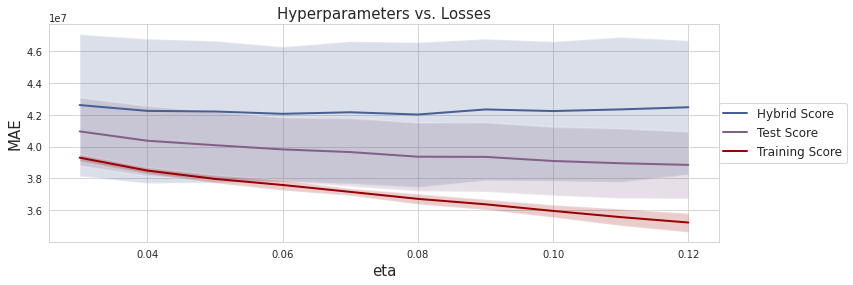

In [75]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist', param_grid)

I'll compare this to the results of using the default learning rate of 0.3.

In [76]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Hybrid Loss: $43,479,779.60
Test MAE: $38,621,209.60
Overfit Ratio: 0.8767978126726298
Num Boosters: 247


The learning rate sweet spot appears to be around 0.08.<br>
I will set the learning rate range to be between 0.03 and 0.11 for the hyperparameter search space.

 > **xgbr_trials_1**

In [77]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_1 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [78]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.03, 0.11)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_1)
# save trials object
pickle.dump(xgbr_trials_1, open('./xgbr_trials/xgbr_trials_1.pkl', 'wb'))

100%|██████████| 20/20 [02:22<00:00,  7.13s/trial, best loss: 41998773.6]


In [79]:
def plot_param_search(trials):
    """Plot iterations of optimization search for hyperparmeters"""
    # establish figure height (each hyperparameter + one optimization plot)
    num_subplots = len(trials.idxs.keys()) + 1
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot parameters of optimization run
    count = 1
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        
        # get number of trials in run
        n_iters = len(trials.losses())
        # get iteration of optimal objective loss
        best_iter = trials.best_trial['tid'] + 1        
        # get value for hyperparameter of best model
        best_val = trials.argmin[key]
        # get list of hyperparameter values
        vals_lst = trials.vals[key]
        
        # adjust values for data type
        if key in ['max_depth', 'one_drop', 'n_estimators']:
            best_val = int(best_val)
            vals_lst = list(map(int, vals_lst))
        else:
            best_val = round(best_val, 6)

        # plot hyperparameters for optimization run
        plt.plot(range(1, len(trials.results) + 1), vals_lst, 
                 marker='o', color=mp.colors(4), alpha=0.8)        
        # mark off optimal hyperparameter value
        plt.hlines(best_val, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
                   label='Optimal \n' + str(key) + ': \n' + '{:,}'.format(best_val), 
                   colors=mp.colors(2))
        # mark iteration of optimal objective loss at hyperparameter value
        plt.plot(best_iter, best_val, marker='*', ms=15, color=mp.colors(2))
        count += 1
        
        plt.ylabel(key, fontsize=18)
        
        plt.legend(bbox_to_anchor=(1.31, 0.5), loc=5, fontsize='x-large')

    plt.subplot(num_subplots, 1, count)
    
    # get optimal objective loss value
    best_hybrid_loss = trials.best_trial['result']['loss']
    # get optimal test loss value
    best_test_loss = np.min([v['test_scores'] for v in trials.results])
    # get optimal training loss value
    best_training_loss = np.min([v['training_scores'] for v in trials.results])
    # set lower limit of plot
    y_min = np.min([best_hybrid_loss, best_test_loss, best_training_loss])
    
    # get largest hybrid loss value
    worst_hybrid_loss = np.max(trials.losses())
    # get largest test loss value
    worst_test_loss = np.max([v['test_scores'] for v in trials.results])
    # get largest training loss value
    worst_training_loss = np.max([v['training_scores'] for v in trials.results])
    # set upper limit of plot
    y_max = np.max([worst_hybrid_loss, worst_test_loss, worst_training_loss])
    
    # set y limits
    plt.ylim(y_min * 0.9, y_max * 1.1)
    
    # plot losses for optimization run
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=trials.losses(), 
                 marker='o', label='Hybrid Loss')
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=[v['test_scores'] for v in trials.results], 
                 marker='o', label='Test Loss')
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=[v['training_scores'] for v in trials.results], 
                 marker='o', label='Training Loss')
    
    # mark off best hybrid loss
    plt.hlines(best_hybrid_loss, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
               colors='k')
    # mark iteration of optimal hybrid loss
    plt.plot(best_iter, best_hybrid_loss, marker='*', ms=15, color='k', 
             label='Hybrid Error: \n' + '${:,.2f}'.format(best_hybrid_loss))
    
    # get training and test loss for model with best hybrid loss
    corresponding_test_loss = trials.best_trial['result']['test_scores']
    corresponding_training_loss = trials.best_trial['result']['training_scores']
    # put training and test loss values for model with best hybrid loss in legend
    plt.plot(0, 0, linewidth=0, label='Test Error: \n' + '${:,.2f}'.format(
                   corresponding_test_loss))
    plt.plot(0, 0, linewidth=0, label='Training Error: \n' + '${:,.2f}'.format(
                   corresponding_training_loss))

    plt.xlabel('Iteration (Best Iteration: ' + str(best_iter) + ')', fontsize=15)
    plt.ylabel('MAE', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1.33, 0.5), loc=5, fontsize='x-large', 
               title='Best Iteration', title_fontsize='x-large')
    plt.suptitle('Hyperparameter Optimization Sequence', y=0.93, fontsize=23)

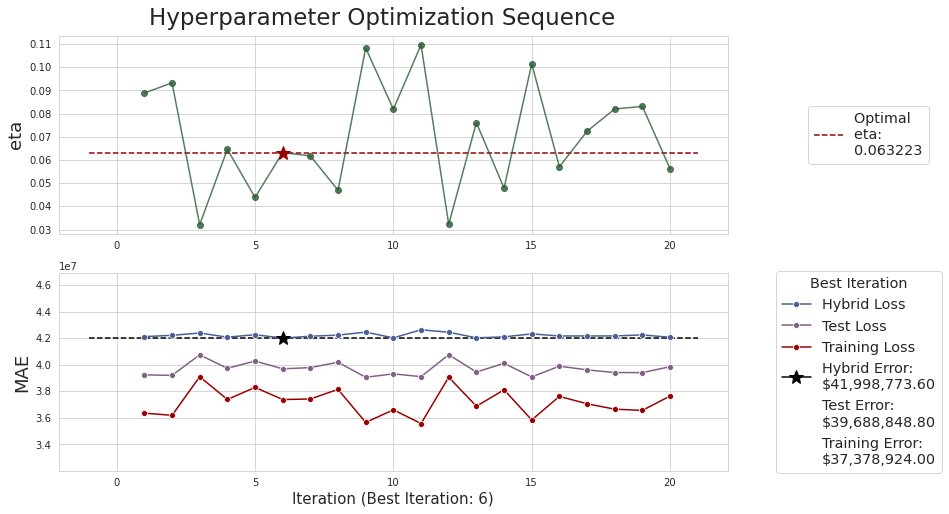

In [80]:
# plot informed search history
plot_param_search(xgbr_trials_1)

The informed search does not appear constrained by the range of allowable values for the learning rate.

The three losses being tracked will always appear in this order.<br>
The goals are to lower the test loss while bringing the training loss nearer to it.<br>
Individual improvements with respect to one of these goals will be seen in a lower hybrid loss.

In [81]:
# get results DataFrame
trials_1_df = make_trials_df(xgbr_trials_1)
trials_1_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
5       1      1          6  41998773.6       37378924.0   39688848.8   
9       1      1         10  42016920.4       36605790.0   39311355.2   
12      1      2         13  42021944.0       36874011.2   39447977.6   
19      1      2         20  42060889.2       37642179.6   39851534.4   
3       1      1          4  42071303.6       37383569.2   39727436.4   
13      1      2         14  42093392.4       38111540.4   40102466.4   
0       1      1          1  42113181.2       36353923.6   39233552.4   
6       1      1          7  42144545.2       37418470.0   39781507.6   
15      1      2         16  42160386.0       37615446.8   39887916.4   
17      1      2         18  42162295.6       36653231.6   39407763.6   

    scores_ratio  n_boost       eta  
5       0.944888      493  0.063223  
9       0.934527      489  0.081922  
12      0.937880      489  0.076124  
19      0.947532      494  0.056227  
3       0.943965      480  0.064634  
13      0.953196      495  0.047848  
0       0.929578      486  0.088862  
6       0.943701      490  0.061762  
15      0.946200      491  0.057050  
17      0.933242      484  0.082015

I'll show the base model scores, again.

In [82]:
# observe metrics of best trial from base trials object
print_best_trial(xgbr_trials_0)

Hybrid Loss: $43,479,779.60
Test MAE: $38,621,209.60
Overfit Ratio: 0.8767978126726298
Num Boosters: 247


The top model has an improved hybrid loss by just under a million and a half dollars.<br>
The test score is higher by over a million dollars, while the overfit ratio has gained nearly 7 points.

As expected, lowering the learning rate has selected less complex models to improve generalizability.

I will look at the distribution of values chosen for the hyperparameter during the search.

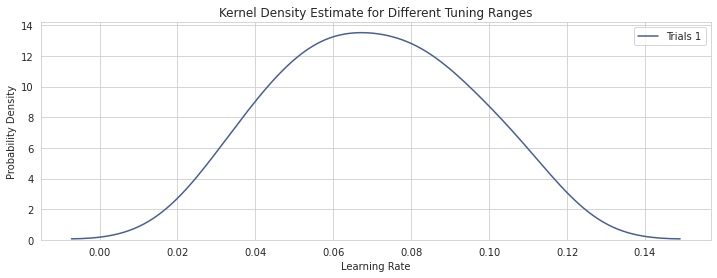

In [83]:
# plot kernel density estimates for number of boosting rounds
sns.kdeplot(trials_1_df['eta'], label='Trials 1')

plt.xlabel('Learning Rate')
plt.ylabel('Probability Density')

plt.title('Kernel Density Estimate for Different Tuning Ranges');

The chosen range is supporting a balanced distribution of hyperparameters.

I will observe the losses over the range of hyperparameters to notice the effects of different choices.

In [84]:
def plot_one_param(trials, param, param_min=None, param_max=None):
    """Plots MAEs vs. one hyperparameter with the option to limit the range"""
    df = make_trials_df(trials)
    # check to see if range needs to be altered
    if (param_min and param_max):
        df = df[(df[param] > param_min) & (df[param] < param_max)]        
    # plot hyperparameters for optimization run
    sns.regplot(x=param, y='loss', data=df, 
        scatter_kws={"s": 10}, label='Hybrid Loss')
    sns.regplot(x=param, y='test_scores', data=df, 
        scatter_kws={"s": 10}, label='Test Loss')
    sns.regplot(x=param, y='training_scores', data=df, 
        scatter_kws={"s": 10}, label='Training Loss')

    plt.xlabel(param, fontsize=14)
    plt.ylabel('MAE', fontsize=14)
    
    plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')

In [85]:
def plot_maes(trials):
    """Plots mean absolute errors for all hyperparameters"""
    # establish figure height
    num_subplots = len(trials.idxs)
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot hyperparameters of optimization run
    count = 1
    # get all hyperparameters in trials object
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        # call hyperparameter plotting function
        plot_one_param(trials, key)
        
        plt.xlabel(key, fontsize=14)
        plt.ylabel('MAE', fontsize=14)
        
        plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')
        count += 1
        
    plt.suptitle('Hyperparameter Informed Search Results', y=0.93, fontsize=23);

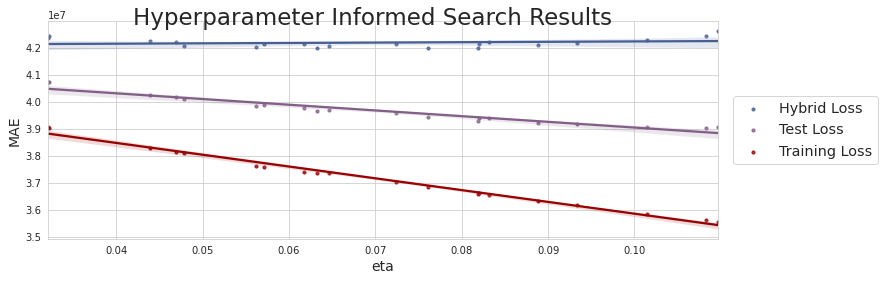

In [86]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_1)

The hybrid loss is constant throughout this range.<br>
Although the middle values appear to be the ones chosen by the best models, I will keep this search space for now.

 > **max_depth**

In [87]:
# get best hyperparameters from last trials
best_params = xgbr_trials_1.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [int(x) for x in np.linspace(4, 9, num=6)],
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.06322317220469353]
max_depth [4, 5, 6, 7, 8, 9]


max_depth : 4 ...
Hybrid MAE: $42,588,651.60
Test MAE: $41,034,788.00
Overfit Ratio: 0.9649966672938823
Average Boosting Rounds: 495

max_depth : 5 ...
Hybrid MAE: $42,355,234.40
Test MAE: $40,344,652.80
Overfit Ratio: 0.9529562173720446
Average Boosting Rounds: 495

max_depth : 6 ...
Hybrid MAE: $41,998,773.60
Test MAE: $39,688,848.80
Overfit Ratio: 0.9448875515896731
Average Boosting Rounds: 493

max_depth : 7 ...
Hybrid MAE: $42,352,756.00
Test MAE: $39,438,930.80
Overfit Ratio: 0.929091109551085
Average Boosting Rounds: 491

max_depth : 8 ...
Hybrid MAE: $42,374,557.60
Test MAE: $39,128,959.60
Overfit Ratio: 0.9198665888851318
Average Boosting Rounds: 479

max_depth : 9 ...
Hybrid MAE: $42,568,875.20
Test MAE: $38,887,617.60
Overfit Ratio: 0.9080934004629407
Average Boosting Rounds: 480



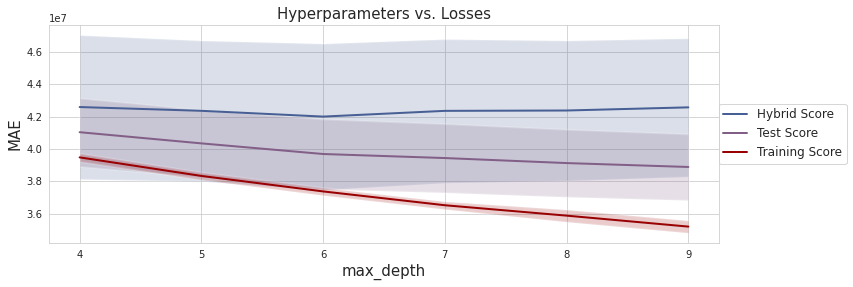

In [88]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist', param_grid)

In [89]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_1)

Hybrid Loss: $41,998,773.60
Test MAE: $39,688,848.80
Overfit Ratio: 0.9448875515896731
Num Boosters: 493


The best choice for maximum tree depth is the default value of 6.<br>
I will set the range to be between 5 and 8, as those values give results that are not too far off from optimal.

 > **xgbr_trials_2**

In [90]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_2 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [91]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 5, 9))
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_2)
# save trials object
pickle.dump(xgbr_trials_2, open('./xgbr_trials/xgbr_trials_2.pkl', 'wb'))

100%|██████████| 20/20 [02:21<00:00,  7.09s/trial, best loss: 41955692.4]


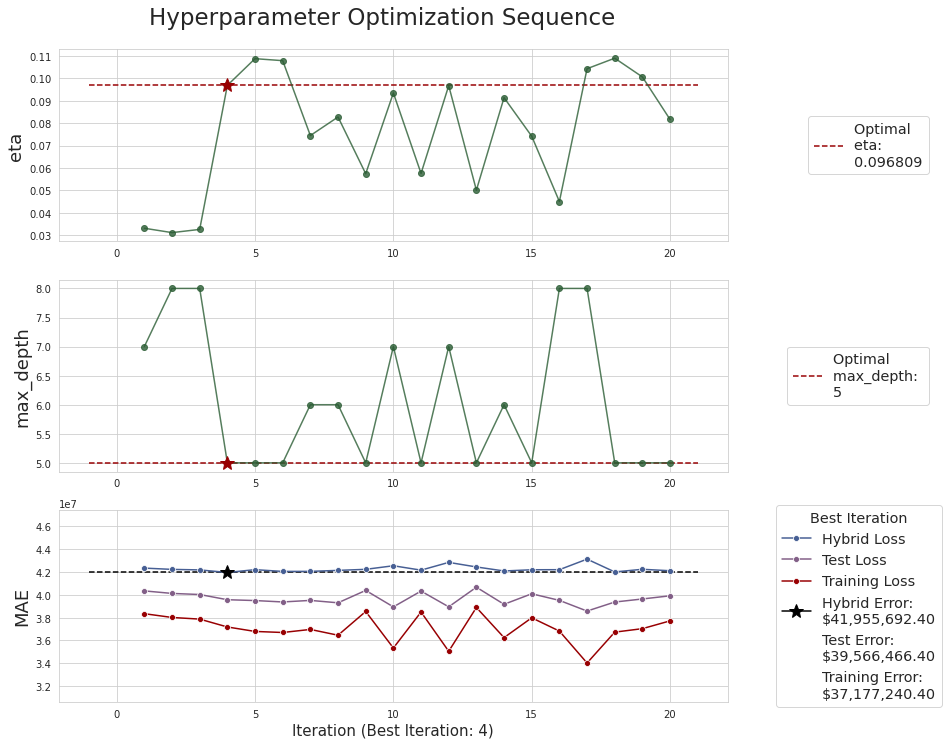

In [92]:
# plot informed search history
plot_param_search(xgbr_trials_2)

In [93]:
# get results DataFrame
trials_2_df = make_trials_df(xgbr_trials_2)
trials_2_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
3       1      1          4  41955692.4       37177240.4   39566466.4   
17      1      2         18  42002012.4       36723179.6   39362596.0   
5       1      1          6  42047195.6       36692569.2   39369882.4   
6       1      1          7  42051801.6       36960464.8   39506133.2   
13      1      2         14  42085803.6       36244057.2   39164930.4   
19      1      2         20  42106644.8       37712168.8   39909406.8   
7       1      1          8  42137923.6       36453034.0   39295478.8   
10      1      2         11  42158438.0       38488395.6   40323416.8   
2       1      1          3  42180161.6       37865853.6   40023007.6   
14      1      2         15  42192653.6       37981376.0   40087014.8   

    scores_ratio  n_boost       eta  max_depth  
3       0.942626      481  0.096809          5  
17      0.936243      474  0.108924          5  
5       0.934988      481  0.107826          5  
6       0.938609      489  0.074442          6  
13      0.928240      478  0.091324          6  
19      0.947850      489  0.081601          5  
7       0.930860      494  0.082712          6  
10      0.957306      499  0.057561          5  
2       0.948974      498  0.032597          8  
14      0.950495      491  0.074140          5

In [94]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_1)

Hybrid Loss: $41,998,773.60
Test MAE: $39,688,848.80
Overfit Ratio: 0.9448875515896731
Num Boosters: 493


The values seem to be wide enough to allow exploration.

Although the scores ratio is not as good, the overall hybrid loss is decreasing.

In [95]:
def plot_kde(trials_dict):
    """Plot range of hyperparameters for each trial given"""
    # create empty dict to hold DataFrames of trials parameters
    df_dict = {}
    # fill dict with each DataFrame
    for trial, num in trials_dict.items():
        # create default dict to sort values of hyperparameters
        param_dict = defaultdict(list)
        # extract iterations
        for d in trial.miscs:
            # sort values from iteration
            for key, val in d['vals'].items():
                param_dict[key].append(val[0])
            # store sorted hyperparameter values from each trial in DataFrame
            param_df = pd.DataFrame(param_dict)
        # add DataFrame to dict
        df_dict[num] = param_df
    # get maximum number of hyperparameters to establish subplots
    n_rows = max([len(x.columns) for x in df_dict.values()])
    fig_height = n_rows * 4
    fig, axes = plt.subplots(nrows=n_rows, figsize=(12, fig_height))
    # create empty dict to map hyperparameters to axes numbers
    axes_dict = {}
    ax_num = -1
    # expand my color palette by looping it three times
    my_palette = ['xkcd:' + c for c in mp.my_colors] * 3
    # sort hyperparameters out of DataFrames
    for num, df in df_dict.items():
        # get list of hyperparameters from DataFrame
        cols_lst = list(df.columns)
        # go through hyperparameters and plot
        for param in cols_lst:
            # build axes mapper
            if param not in list(axes_dict.keys()):
                ax_num += 1
                axes_dict[param] = ax_num
            # plot kernel density estimate for hyperparameter
            g = sns.kdeplot(df[param], label=num, color=my_palette[num - 1], 
                        ax=axes[axes_dict[param]])
            g.set_xlabel(param, fontsize=15)
            g.set_ylabel('Probability Density', fontsize=15)

    plt.suptitle('Kernel Density Estimates for Different Tuning Ranges', fontsize=15)
    plt.subplots_adjust(top=0.95)

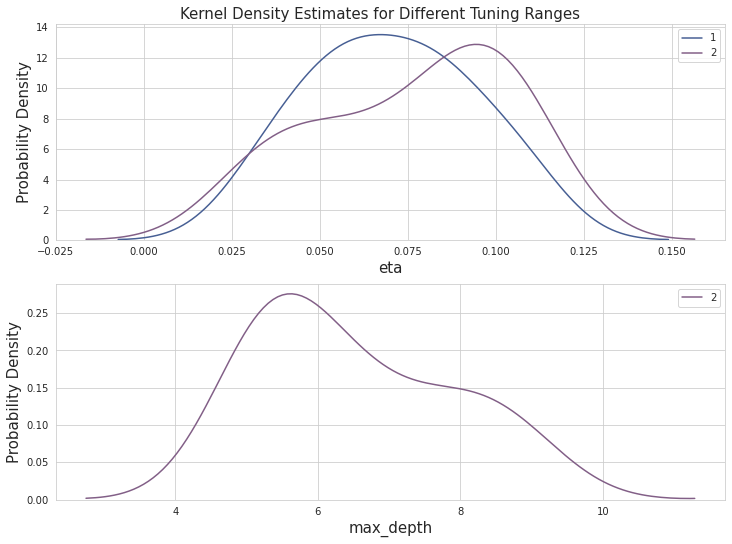

In [96]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2
        }
# plot the results, so far
plot_kde(_dict)

This search used less trees on average.

There are two local minima that were heavily searched with respect to the learning rate.

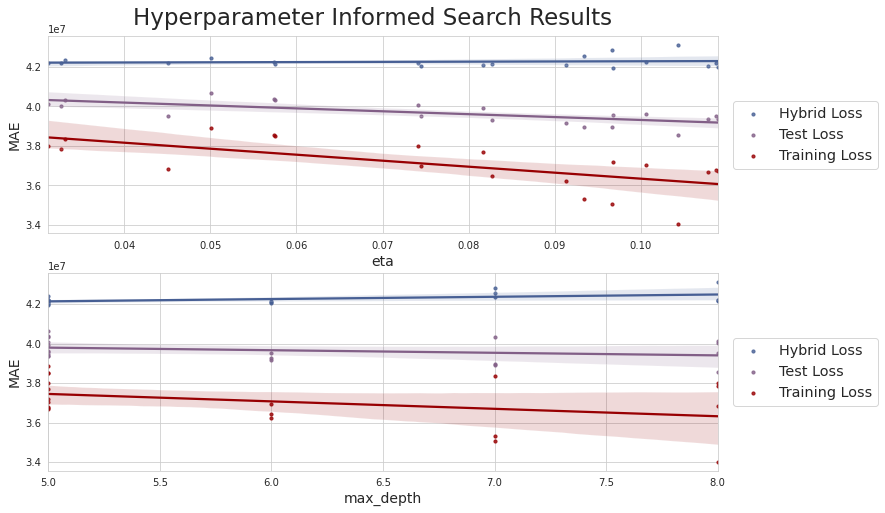

In [97]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_2)

 > **xgbr_trials_3**

In [98]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [99]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 9))
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3)
# save trials object
pickle.dump(xgbr_trials_3, open('./xgbr_trials/xgbr_trials_3.pkl', 'wb'))

100%|██████████| 30/30 [02:23<00:00,  4.78s/trial, best loss: 41917614.4]


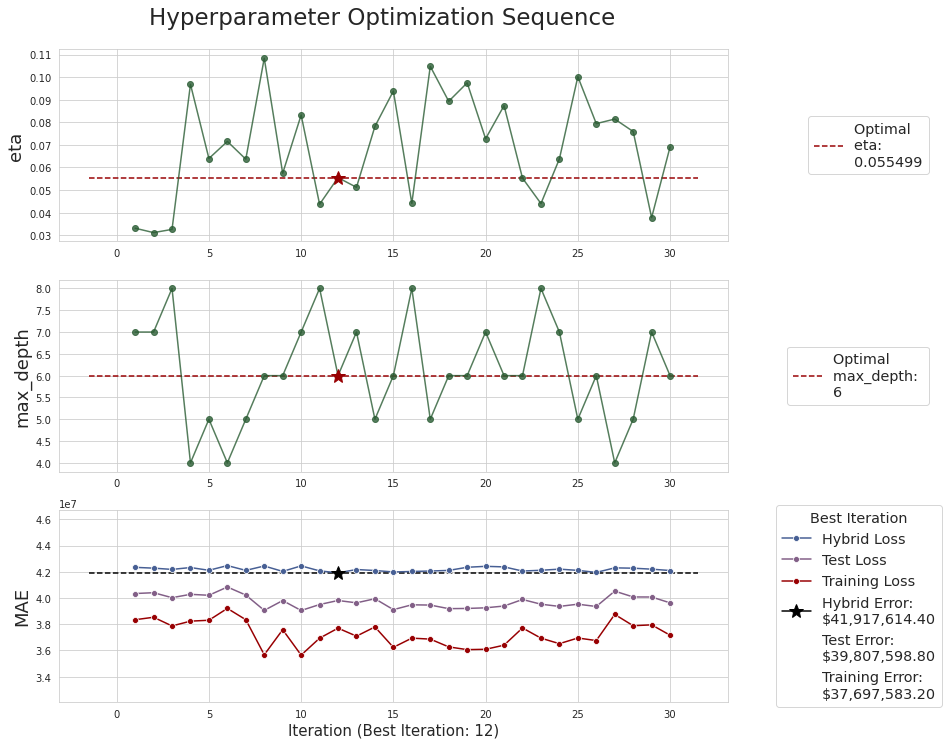

In [100]:
# plot informed search history
plot_param_search(xgbr_trials_3)

In [101]:
# get results DataFrame
trials_3_df = make_trials_df(xgbr_trials_3)
trials_3_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
11      1      2         12  41917614.4       37697583.2   39807598.8   
25      1      3         26  41950735.6       36750840.4   39350788.0   
14      1      2         15  41985094.0       36233587.6   39109340.8   
15      1      2         16  42021776.0       36935324.0   39478550.0   
8       1      1          9  42028103.2       37578340.8   39803222.0   
21      1      3         22  42056056.0       37713548.8   39884802.4   
16      1      2         17  42057421.2       36860494.0   39458957.6   
10      1      2         11  42067677.6       36931933.6   39499805.6   
29      1      3         30  42095238.8       37159976.4   39627607.6   
13      1      2         14  42095293.2       37790012.4   39942652.8   

    scores_ratio  n_boost       eta  max_depth  
11      0.950080      495  0.055499          6  
25      0.937011      485  0.079401          6  
14      0.929331      471  0.093817          6  
15      0.938694      495  0.044131          8  
8       0.947168      493  0.057449          6  
21      0.948499      494  0.055288          6  
16      0.937276      477  0.104767          5  
10      0.937972      496  0.043728          8  
29      0.940686      493  0.069087          6  
13      0.949226      494  0.078175          5

In [102]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_2)

Hybrid Loss: $41,955,692.40
Test MAE: $39,566,466.40
Overfit Ratio: 0.9426258421550546
Num Boosters: 481


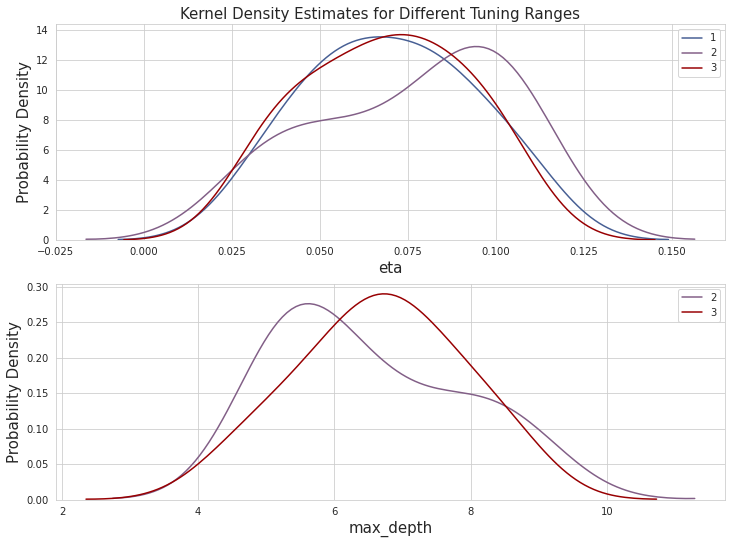

In [103]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3
        }
# plot the results, so far
plot_kde(_dict)

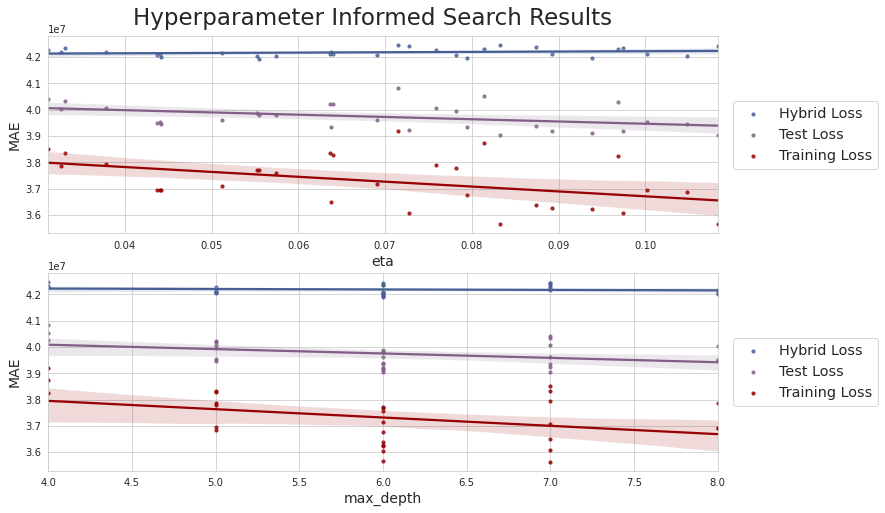

In [104]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_3)

 > **min_child_weight**

In [105]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'min_child_weight': [int(x) for x in np.linspace(1, 3, num=3)], 
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.05549858576121072]
max_depth [6]
min_child_weight [1, 2, 3]


min_child_weight : 1 ...
Hybrid MAE: $41,917,614.40
Test MAE: $39,807,598.80
Overfit Ratio: 0.9500799936473371
Average Boosting Rounds: 495

min_child_weight : 2 ...
Hybrid MAE: $43,222,754.00
Test MAE: $40,974,697.60
Overfit Ratio: 0.9477968941250406
Average Boosting Rounds: 490

min_child_weight : 3 ...
Hybrid MAE: $43,586,172.00
Test MAE: $41,630,974.80
Overfit Ratio: 0.956220232774081
Average Boosting Rounds: 486



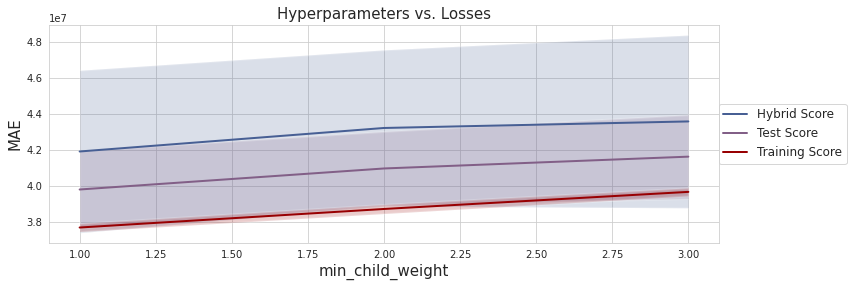

In [106]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist', param_grid)

In [107]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Hybrid Loss: $41,917,614.40
Test MAE: $39,807,598.80
Overfit Ratio: 0.9500799936473371
Num Boosters: 495


 > **xgbr_trials_3a**

In [108]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_3a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [109]:
# create informed search space  
hp_space = {
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 9)), 
    'min_child_weight': ho_scope.int(hp.uniform('min_child_weight', 1, 4))
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_3a)
# save trials object
pickle.dump(xgbr_trials_3a, open('./xgbr_trials/xgbr_trials_3a.pkl', 'wb'))

100%|██████████| 40/40 [02:27<00:00,  3.69s/trial, best loss: 42030764.4]


In [110]:
# get results DataFrame
trials_3a_df = make_trials_df(xgbr_trials_3a)
trials_3a_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
21      1      3         22  42030764.4       36984900.4   39507832.4   
18      1      2         19  42048815.6       37646682.8   39847749.2   
3       1      1          4  42049115.2       37530562.4   39789838.8   
10      1      2         11  42084527.2       36944492.8   39514510.0   
37      1      4         38  42087788.0       36751704.0   39419746.0   
24      1      3         25  42117648.0       37369264.0   39743456.0   
27      1      3         28  42146168.0       37478812.8   39812490.4   
38      1      4         39  42162043.6       37818054.0   39990048.8   
7       1      1          8  42170444.8       37826703.2   39998574.0   
22      1      3         23  42175696.4       36717220.4   39446458.4   

    scores_ratio  n_boost       eta  max_depth  min_child_weight  
21      0.939071      490  0.043949          8                 1  
18      0.947736      498  0.041994          7                 1  
3       0.946321      492  0.036467          8                 1  
10      0.937934      490  0.055244          7                 1  
37      0.935366      494  0.046348          8                 1  
24      0.943410      498  0.047012          7                 1  
27      0.944385      498  0.060089          6                 1  
38      0.948581      496  0.052439          6                 1  
7       0.948590      493  0.077555          5                 1  
22      0.933787      495  0.047013          8                 1

In [111]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Hybrid Loss: $41,917,614.40
Test MAE: $39,807,598.80
Overfit Ratio: 0.9500799936473371
Num Boosters: 495


The next hyperparameters to tune will be the max depth and the min child weight.<br>
Again, it is suggested to tune these two hyperparameters at the same time, as they influence each other.<br>
Child creation is performed greedily. The nodes want to be split, giving a tendency toward overfitting.<br>
If trees are not allowed to add more layers, the samples in each node become heavier.<br>
Likewise, if nodes are not allowed to split until they obtain a critical weight, model complexity will be constrained.<br>
Continuing with the physics nomenclature, I will observe a hypothetical parameter and call it the model's tree potential.

I will begin to tune these hypermarameters.<br>
Trees deeper than 6 layers tend to be strongly overfit.<br>
I'll begin my search with an upper bound of 8 on these values to allow for exploration, as local minima are discovered.

I'll continue with tuning the hyperparameter that limits the maximum number of levels the trees are allowed to grow.<br>
Recall, the default value is 3.

Once again, 3 is the optimal depth, but this may change as the other hyperparameters vary.

Again, the favoritism for the lower bounds by the learning rate and number of trees hyperparameters is obvious.<br>
I will make adjustments to them, now.

The range of tree depth looks suitable.

Looking at the larger values for the number of trees, there are large errors pulling the fitted hybrid line upward.<br>
I will observe what shrinking the upper bound of those values will yield.

 > **subsample**

In [112]:
# get best hyperparameters from last trials
best_params = xgbr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'subsample': np.linspace(0.9, 1, 6)
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

eta [0.05549858576121072]
max_depth [6]
subsample [0.9  0.92 0.94 0.96 0.98 1.  ]


subsample : 0.9 ...
Hybrid MAE: $41,936,104.40
Test MAE: $39,616,477.60
Overfit Ratio: 0.9440243908181394
Average Boosting Rounds: 491

subsample : 0.92 ...
Hybrid MAE: $41,844,916.80
Test MAE: $39,528,335.20
Overfit Ratio: 0.9441390449052978
Average Boosting Rounds: 497

subsample : 0.9400000000000001 ...
Hybrid MAE: $41,897,983.20
Test MAE: $39,575,895.60
Overfit Ratio: 0.944197644309202
Average Boosting Rounds: 495

subsample : 0.96 ...
Hybrid MAE: $41,785,819.60
Test MAE: $39,498,641.20
Overfit Ratio: 0.94472220454625
Average Boosting Rounds: 499

subsample : 0.98 ...
Hybrid MAE: $41,785,103.20
Test MAE: $39,546,702.80
Overfit Ratio: 0.94632537858488
Average Boosting Rounds: 495

subsample : 1.0 ...
Hybrid MAE: $41,917,614.40
Test MAE: $39,807,598.80
Overfit Ratio: 0.9500799936473371
Average Boosting Rounds: 495



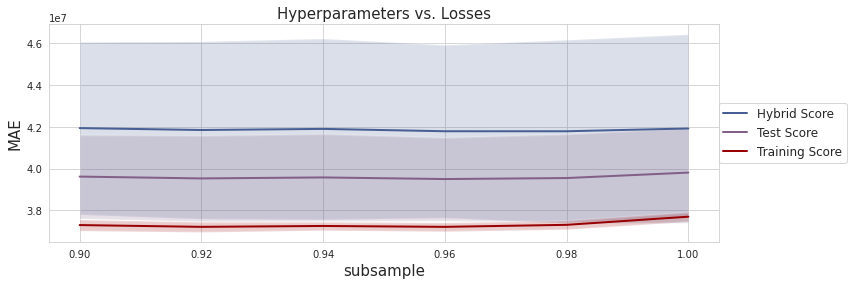

In [113]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist', param_grid)

In [114]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Hybrid Loss: $41,917,614.40
Test MAE: $39,807,598.80
Overfit Ratio: 0.9500799936473371
Num Boosters: 495


 > **xgbr_trials_4**

In [115]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_4 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [116]:
hp_space = {
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_4)
# save trials object
pickle.dump(xgbr_trials_4, open('./xgbr_trials/xgbr_trials_4.pkl', 'wb'))

100%|██████████| 20/20 [02:28<00:00,  7.44s/trial, best loss: 41912622.8]


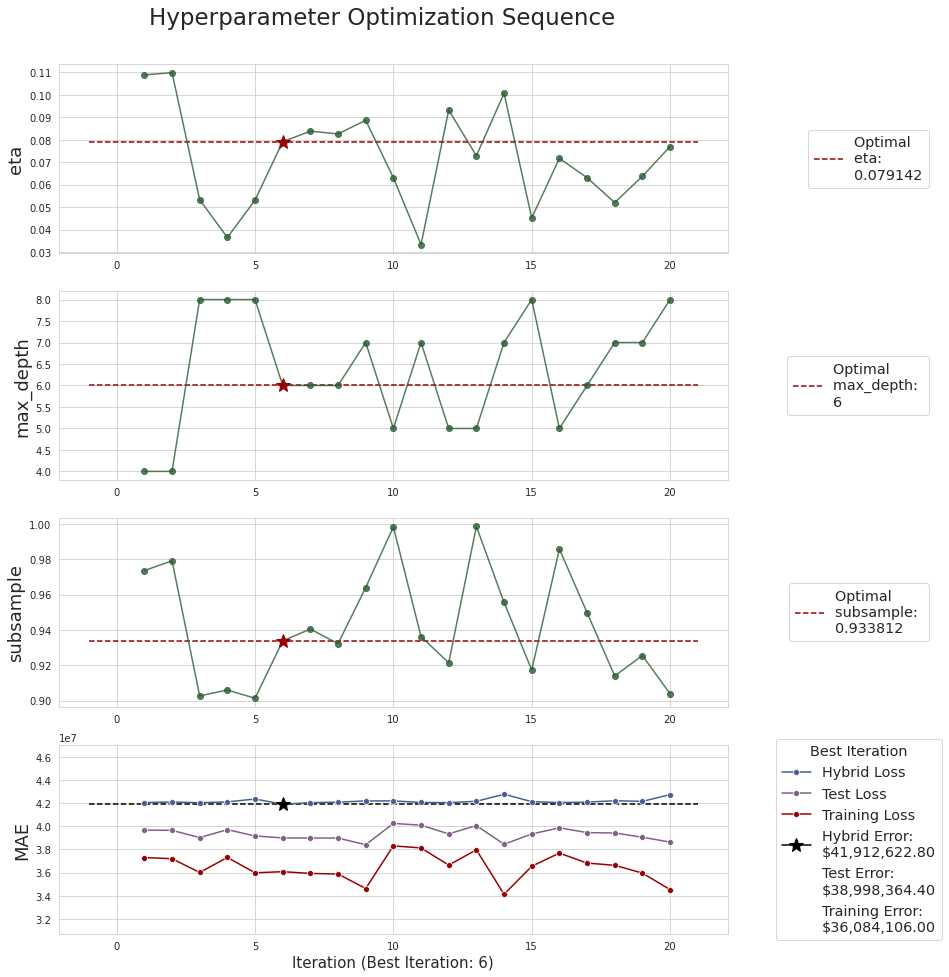

In [117]:
# plot informed search history
plot_param_search(xgbr_trials_4)

With that adjustment, the learning rate is not struggling to find useful values as much.

In [118]:
# get results DataFrame
trials_4_df = make_trials_df(xgbr_trials_4)
trials_4_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
5       1      1          6  41912622.8       36084106.0   38998364.4   
2       1      1          3  42042002.8       36016623.6   39029313.2   
6       1      1          7  42048643.2       35932480.8   38990562.0   
11      1      2         12  42050444.8       36649289.6   39349867.2   
0       1      1          1  42055170.8       37304114.0   39679642.4   
15      1      2         16  42055697.2       37690170.0   39872933.6   
10      1      2         11  42061796.4       38135477.2   40098636.8   
7       1      1          8  42092574.4       35882308.0   38987441.2   
16      1      2         17  42094773.2       36825410.0   39460091.6   
1       1      1          2  42103116.8       37203789.6   39653453.2   

    scores_ratio  n_boost       eta  max_depth  subsample  
5       0.928736      488  0.079142          6   0.933812  
2       0.925628      486  0.053284          8   0.902647  
6       0.924397      485  0.083803          6   0.940488  
11      0.934190      492  0.093240          5   0.921398  
0       0.943121      490  0.108852          4   0.973577  
15      0.948293      493  0.071708          5   0.985769  
10      0.953912      500  0.033335          7   0.936200  
7       0.923139      495  0.082610          6   0.932186  
16      0.936214      491  0.063099          6   0.949809  
1       0.941164      492  0.109885          4   0.979128

In [119]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_3)

Hybrid Loss: $41,917,614.40
Test MAE: $39,807,598.80
Overfit Ratio: 0.9500799936473371
Num Boosters: 495


The lower values of the learning rate tend to pay off more, though.

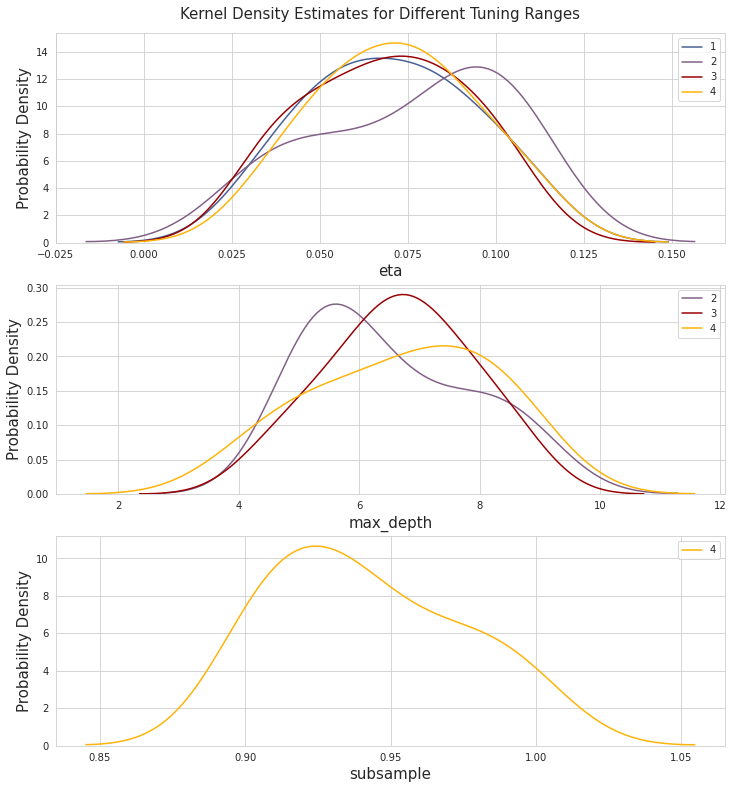

In [120]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4
        }
# plot the results, so far
plot_kde(_dict)

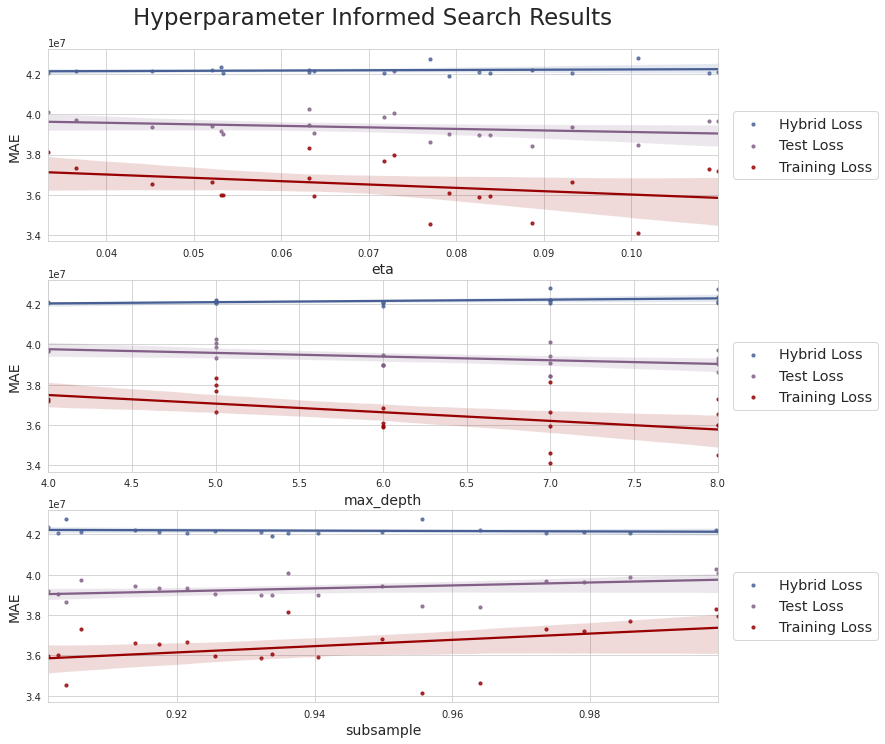

In [121]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_4)

I will move on to sampling by features, as opposed to sampling by observations.<br>
There is really only one way to do these splits, that is, by level (at each depth of the tree).<br>
Splitting by node (at every split) has always produced the same results as splitting by level. So, I don't consider it.<br>
Also, splitting by tree (at the beginning) does not change the search results. So, that one will not be used, either.

I will move on to the stochastic hyperparameters.<br>
They all have default values of 1.

 > **colsample_bylevel**

In [122]:
# get best hyperparameters from last trials
best_params = xgbr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bylevel': np.linspace(0.1, 1.0, 10), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'subsample': [best_params['subsample']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bylevel [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
eta [0.07914169194181542]
max_depth [6]
subsample [0.9338122220640727]


colsample_bylevel : 0.1 ...
Hybrid MAE: $43,746,634.40
Test MAE: $41,250,527.60
Overfit Ratio: 0.9421421282528908
Average Boosting Rounds: 487

colsample_bylevel : 0.2 ...
Hybrid MAE: $42,459,916.40
Test MAE: $39,668,620.00
Overfit Ratio: 0.9328517101495551
Average Boosting Rounds: 494

colsample_bylevel : 0.30000000000000004 ...
Hybrid MAE: $42,167,213.60
Test MAE: $39,338,125.60
Overfit Ratio: 0.9307864388429117
Average Boosting Rounds: 494

colsample_bylevel : 0.4 ...
Hybrid MAE: $42,143,546.40
Test MAE: $39,284,438.40
Overfit Ratio: 0.930112727416606
Average Boosting Rounds: 481

colsample_bylevel : 0.5 ...
Hybrid MAE: $42,030,126.00
Test MAE: $39,155,159.60
Overfit Ratio: 0.9297414313537237
Average Boosting Rounds: 493

colsample_bylevel : 0.6 ...
Hybrid MAE: $42,154,000.00
Test MAE: $39,154,907.60
Overfit Ratio: 0.9265460278064573
Average Boosting Rounds: 497

colsample_bylevel : 0.7000000000000001 ...
Hybrid MAE: $42,022,521.20
Test MAE: $39,129,350.80
Overfit Ratio: 0.928943394

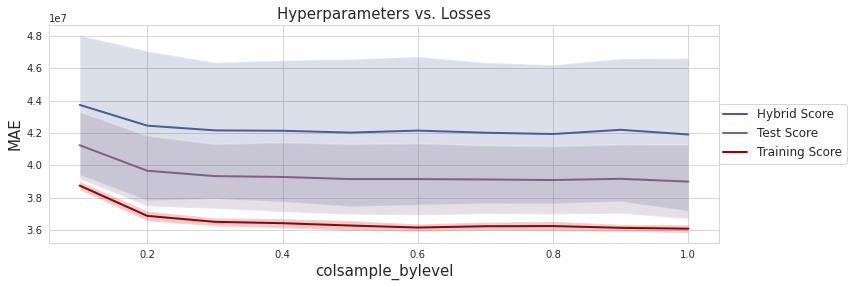

In [123]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist', param_grid)

I will reduce the upper bound to 0.1 for the learning rate.

In [124]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Hybrid Loss: $41,912,622.80
Test MAE: $38,998,364.40
Overfit Ratio: 0.9287359184760033
Num Boosters: 488


 > **xgbr_trials_5**

In [125]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_5 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [126]:
hp_space = {
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_5)
# save trials object
pickle.dump(xgbr_trials_5, open('./xgbr_trials/xgbr_trials_5.pkl', 'wb'))

100%|██████████| 30/30 [02:17<00:00,  4.57s/trial, best loss: 41649676.0]


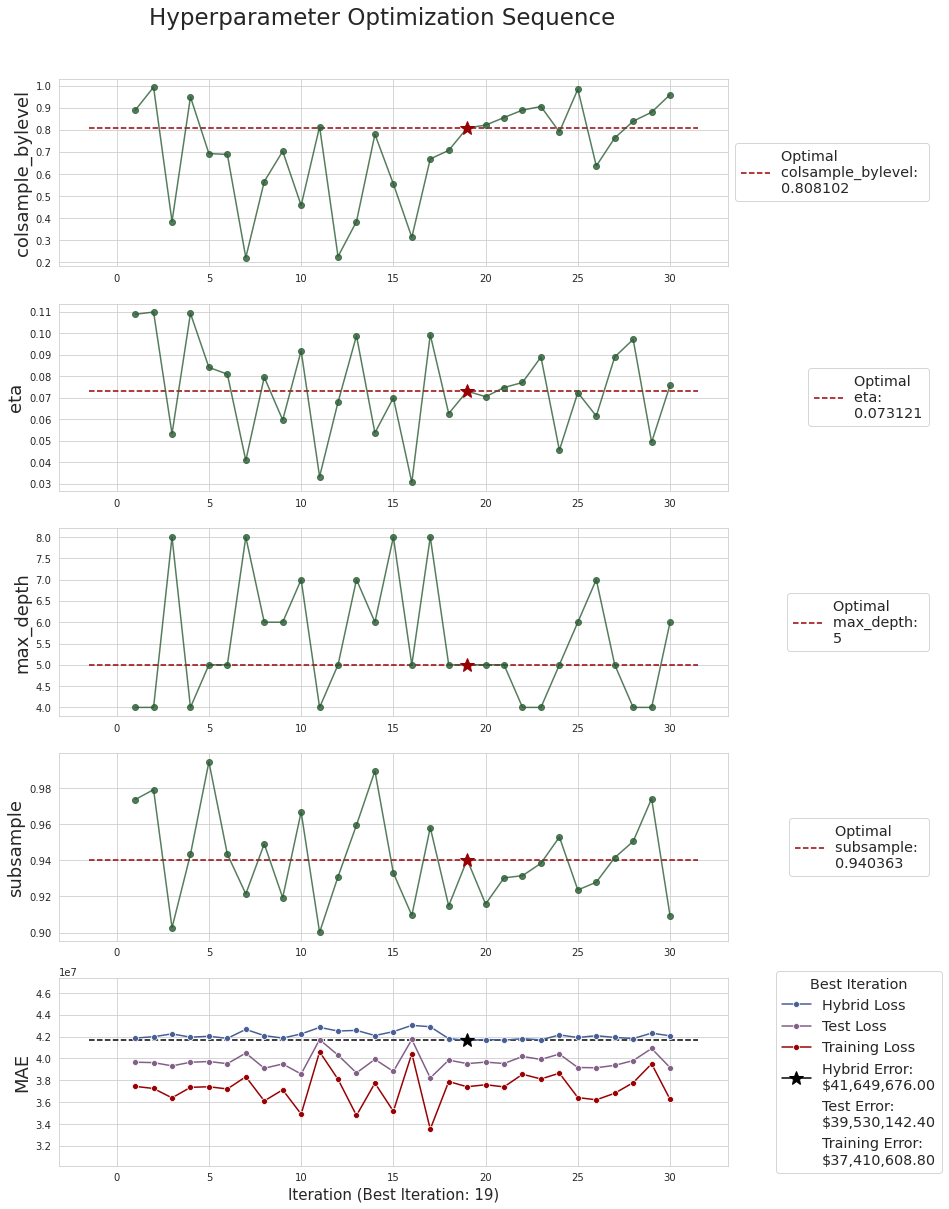

In [127]:
# plot informed search history
plot_param_search(xgbr_trials_5)

In [128]:
# get results DataFrame
trials_5_df = make_trials_df(xgbr_trials_5)
trials_5_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
18      1      2         19  41649676.0       37410608.8   39530142.4   
20      1      3         21  41681562.4       37400593.6   39541078.0   
22      1      3         23  41706159.2       38124877.6   39915518.4   
19      1      2         20  41737923.6       37597136.4   39667530.0   
21      1      3         22  41812241.2       38554734.0   40183487.6   
17      1      2         18  41817884.0       37887182.4   39852533.2   
27      1      3         28  41828325.2       37786479.6   39807402.4   
5       1      1          6  41841956.8       37209989.6   39525973.2   
8       1      1          9  41868885.6       37131308.8   39500097.2   
0       1      1          1  41869911.2       37447336.8   39658624.0   

    scores_ratio  n_boost  colsample_bylevel       eta  max_depth  subsample  
18      0.949484      494           0.808102  0.073121          5   0.940363  
20      0.948956      496           0.855259  0.074791          5   0.930294  
22      0.958306      488           0.904989  0.088961          4   0.938357  
19      0.950871      493           0.820643  0.070516          5   0.915796  
21      0.962381      492           0.888883  0.077129          4   0.931490  
17      0.953641      493           0.706575  0.062676          5   0.914803  
27      0.952000      492           0.838442  0.097178          4   0.950461  
5       0.944736      494           0.688158  0.081012          5   0.943382  
8       0.942865      495           0.702772  0.059677          6   0.919334  
0       0.947139      485           0.887541  0.108852          4   0.973577

In [129]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_4)

Hybrid Loss: $41,912,622.80
Test MAE: $38,998,364.40
Overfit Ratio: 0.9287359184760033
Num Boosters: 488


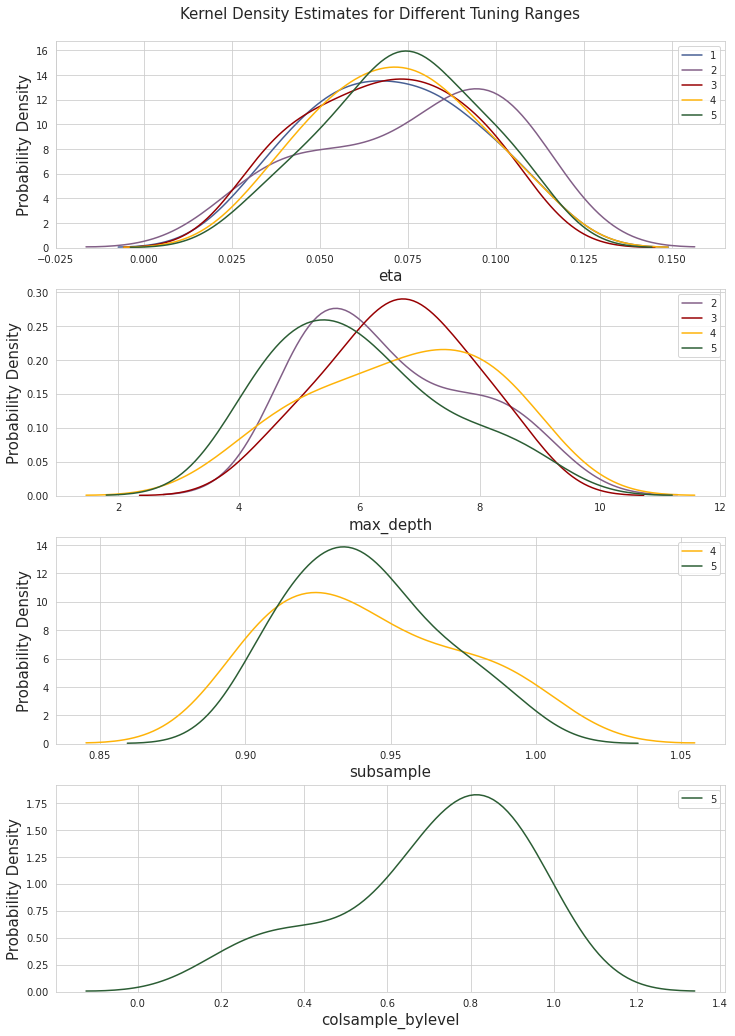

In [130]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5
        }
# plot the results, so far
plot_kde(_dict)

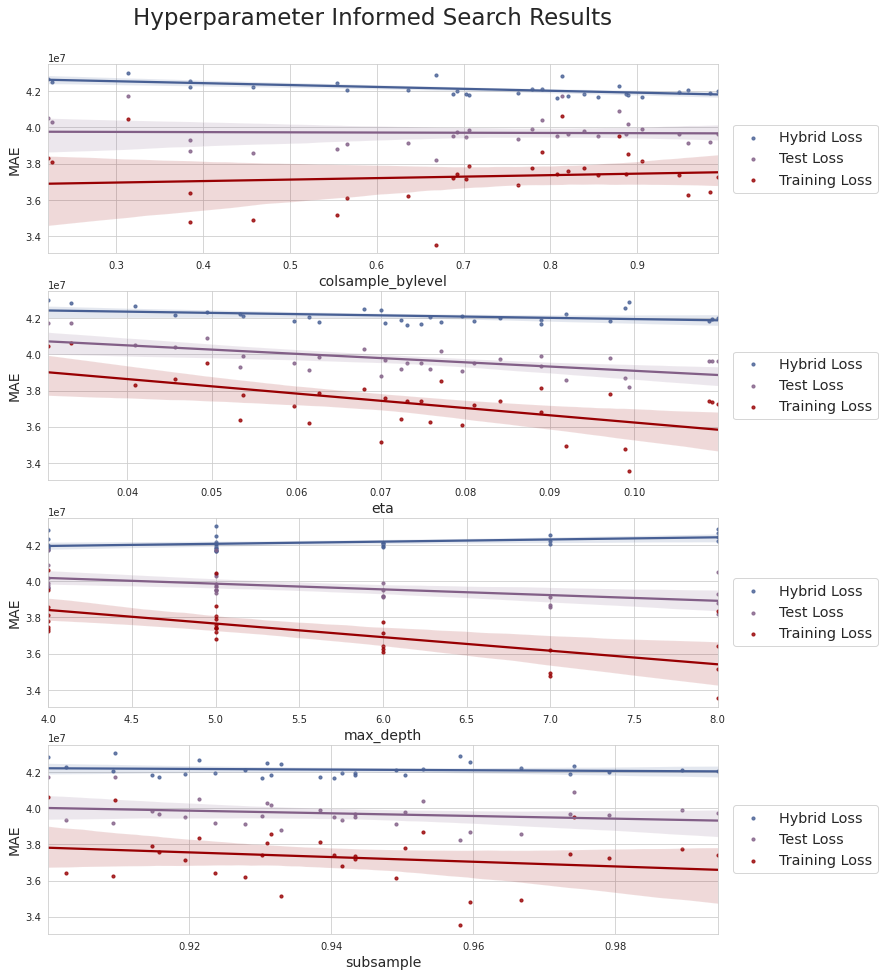

In [131]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_5)

 > **xgbr_trials_6**

In [132]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_6 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [133]:
hp_space = {
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 3, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_6)
# save trials object
pickle.dump(xgbr_trials_6, open('./xgbr_trials/xgbr_trials_6.pkl', 'wb'))

100%|██████████| 20/20 [02:21<00:00,  7.08s/trial, best loss: 41603988.0]


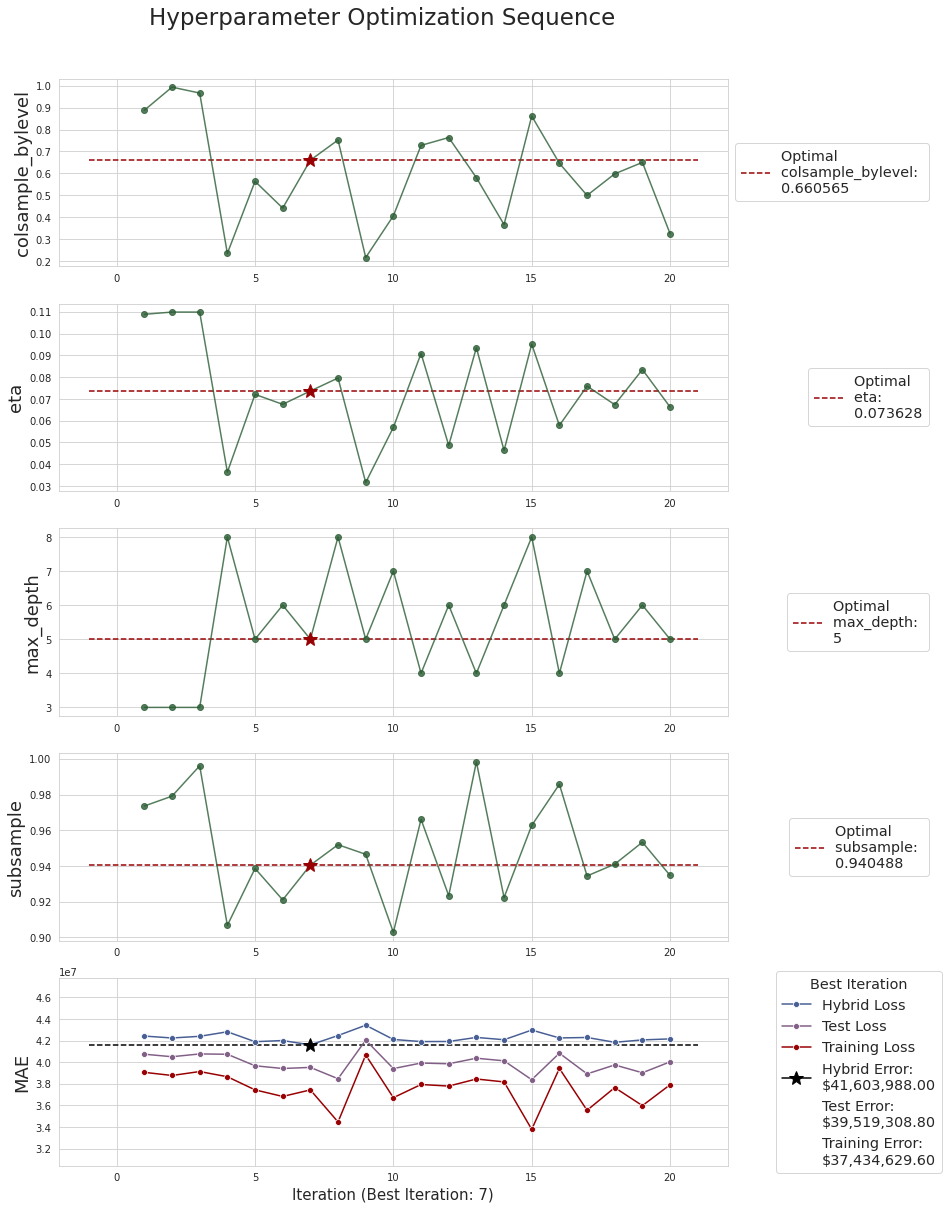

In [134]:
# plot informed search history
plot_param_search(xgbr_trials_6)

In [135]:
# get results DataFrame
trials_6_df = make_trials_df(xgbr_trials_6)
trials_6_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
6       1      1          7  41603988.0       37434629.6   39519308.8   
17      1      2         18  41845892.4       37649457.2   39747674.8   
4       1      1          5  41901946.8       37438496.4   39670221.6   
10      1      2         11  41911806.0       37935290.8   39923548.4   
11      1      2         12  41920086.4       37788528.8   39854307.6   
5       1      1          6  42008354.4       36827564.8   39417959.6   
18      1      2         19  42066598.4       35977495.2   39022046.8   
13      1      2         14  42082000.8       38173925.6   40127963.2   
9       1      1         10  42108348.8       36714395.2   39411372.0   
19      1      2         20  42160121.6       37910344.0   40035232.8   

    scores_ratio  n_boost  colsample_bylevel       eta  max_depth  subsample  
6       0.950222      494           0.660565  0.073628          5   0.940488  
17      0.950192      498           0.598324  0.067355          5   0.941011  
4       0.946682      496           0.564078  0.072076          5   0.938613  
10      0.953247      495           0.727657  0.090848          4   0.966106  
11      0.951006      496           0.763530  0.048663          6   0.923344  
5       0.937404      493           0.442517  0.067508          6   0.920998  
18      0.924971      493           0.650349  0.083479          6   0.953309  
13      0.954415      499           0.367407  0.046327          6   0.922310  
9       0.934674      498           0.407332  0.056927          7   0.902817  
19      0.950269      497           0.325842  0.066283          5   0.934713

In [136]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_5)

Hybrid Loss: $41,649,676.00
Test MAE: $39,530,142.40
Overfit Ratio: 0.9494838369093745
Num Boosters: 494


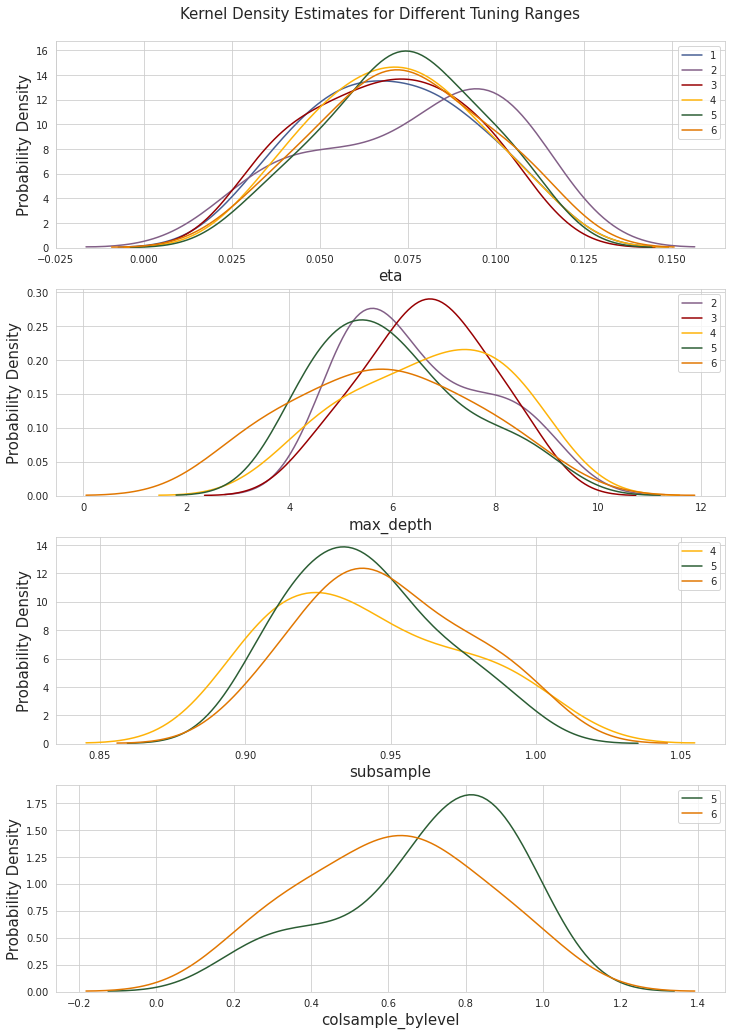

In [137]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5, 
         xgbr_trials_6: 6
        }
# plot the results, so far
plot_kde(_dict)

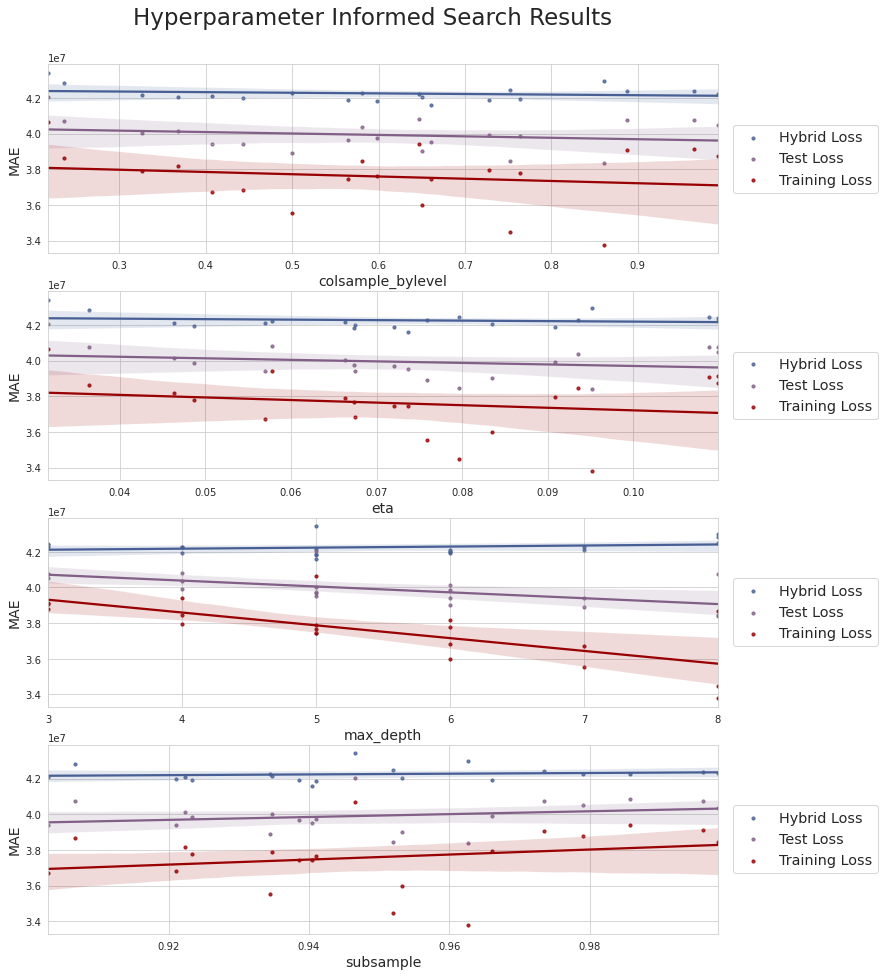

In [138]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_6)

 > **colsample_bytree**

In [139]:
# get best hyperparameters from last trials
best_params = xgbr_trials_6.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'colsample_bylevel': [best_params['colsample_bylevel']], 
    'colsample_bytree': np.linspace(0.2, 1.0, 9), 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'subsample': [best_params['subsample']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

colsample_bylevel [0.6605653916911328]
colsample_bytree [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
eta [0.07362810377958681]
max_depth [5]
subsample [0.940487538222147]


colsample_bytree : 0.2 ...
Hybrid MAE: $43,078,436.80
Test MAE: $41,203,712.00
Overfit Ratio: 0.9571285525850632
Average Boosting Rounds: 489

colsample_bytree : 0.30000000000000004 ...
Hybrid MAE: $42,912,777.20
Test MAE: $40,713,032.80
Overfit Ratio: 0.9489952468642313
Average Boosting Rounds: 484

colsample_bytree : 0.4 ...
Hybrid MAE: $42,814,168.00
Test MAE: $40,471,869.20
Overfit Ratio: 0.9451007216262683
Average Boosting Rounds: 494

colsample_bytree : 0.5 ...
Hybrid MAE: $42,423,878.80
Test MAE: $40,092,304.40
Overfit Ratio: 0.9451616743960957
Average Boosting Rounds: 497

colsample_bytree : 0.6000000000000001 ...
Hybrid MAE: $42,076,862.40
Test MAE: $39,845,650.00
Overfit Ratio: 0.9472668437382519
Average Boosting Rounds: 496

colsample_bytree : 0.7 ...
Hybrid MAE: $42,076,847.20
Test MAE: $39,764,542.00
Overfit Ratio: 0.9449173576536406
Average Boosting Rounds: 488

colsample_bytree : 0.8 ...
Hybrid MAE: $41,989,103.60
Test MAE: $39,707,532.80
Overfit Ratio: 0.945232173640113

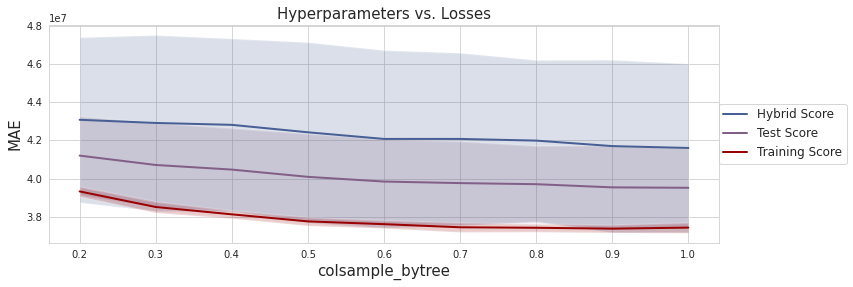

In [140]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist', param_grid)

In [141]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_6)

Hybrid Loss: $41,603,988.00
Test MAE: $39,519,308.80
Overfit Ratio: 0.950222083151945
Num Boosters: 494


 > **xgbr_trials_7**

In [142]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [143]:
hp_space = {
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 3, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7)
# save trials object
pickle.dump(xgbr_trials_7, open('./xgbr_trials/xgbr_trials_7.pkl', 'wb'))

100%|██████████| 40/40 [02:20<00:00,  3.51s/trial, best loss: 41592406.4]


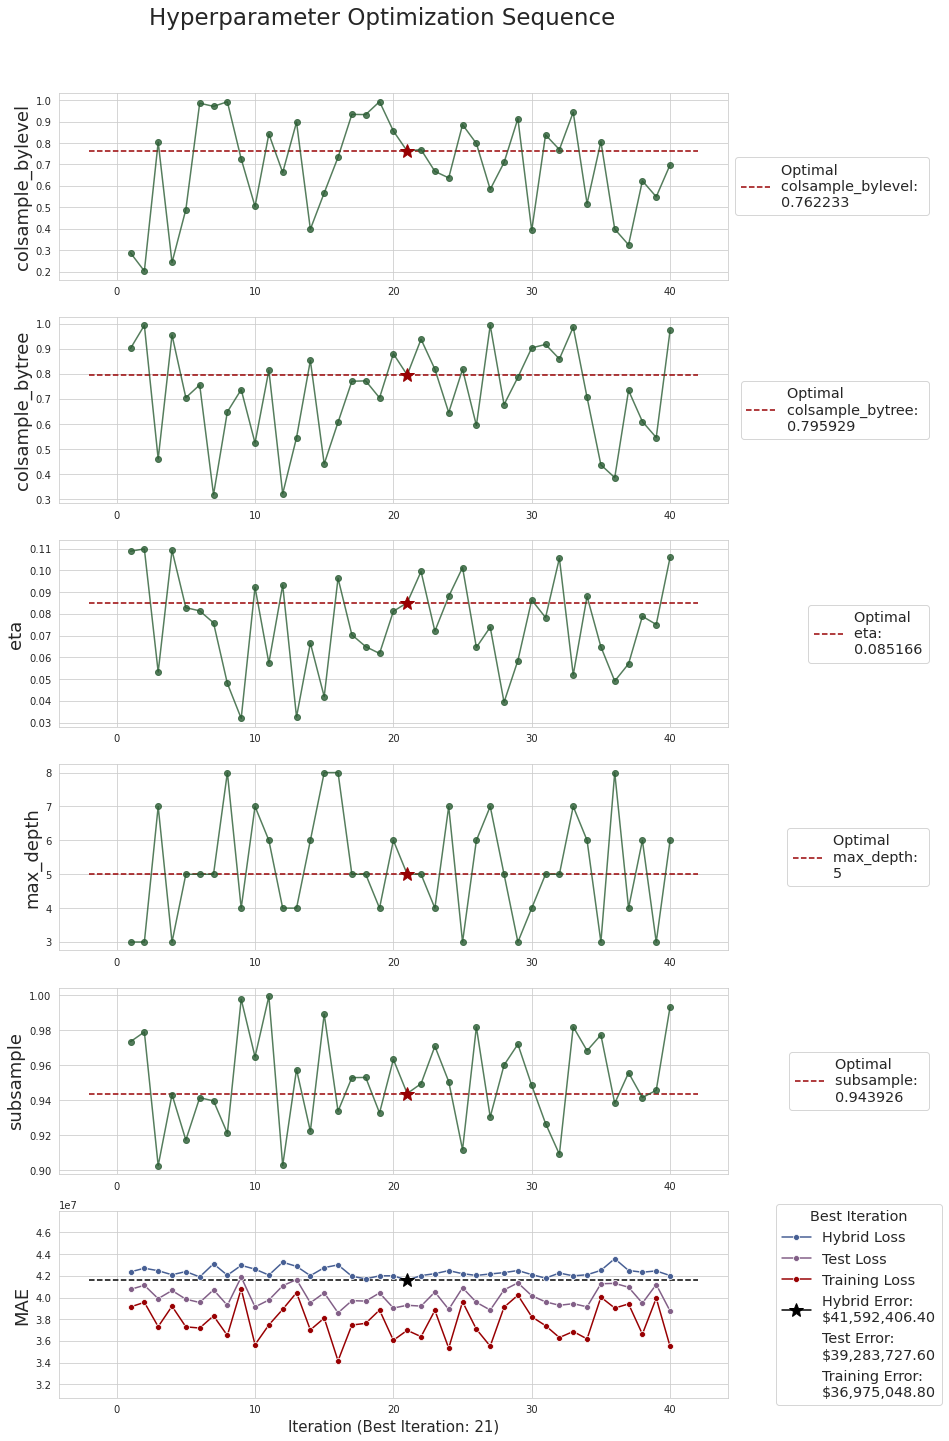

In [144]:
# plot informed search history
plot_param_search(xgbr_trials_7)

In [145]:
# get results DataFrame
trials_7_df = make_trials_df(xgbr_trials_7)
trials_7_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
20      1      3         21  41592406.4       36975048.8   39283727.6   
17      1      2         18  41720186.4       37617982.4   39669084.4   
30      1      4         31  41790423.2       37402183.2   39596303.2   
5       1      1          6  41899079.2       37183945.6   39541512.4   
16      1      2         17  41962426.8       37460770.8   39711598.8   
32      1      4         33  41996909.2       36864505.2   39430707.2   
18      1      2         19  42000213.2       38844273.2   40422243.2   
19      1      2         20  42004873.6       36053833.6   39029353.6   
13      1      2         14  42014194.4       37011702.4   39512948.4   
21      1      3         22  42023040.4       36391196.4   39207118.4   

    scores_ratio  n_boost  colsample_bylevel  colsample_bytree       eta  \
20      0.944288      493           0.762233          0.795929  0.085166   
17      0.951296      495           0.932912          0.772388  0.064949   
30      0.947694      478           0.838364          0.917494  0.078306   
5       0.943303      496           0.986058          0.756273  0.081405   
16      0.946447      493           0.933836          0.770776  0.070379   
32      0.937791      491           0.943657          0.986387  0.051941   
18      0.964098      497           0.993366          0.704691  0.061807   
19      0.926945      492           0.856327          0.880184  0.081192   
13      0.939556      495           0.397962          0.853628  0.066557   
21      0.931495      490           0.769687          0.938045  0.099516   

    max_depth  subsample  
20          5   0.943926  
17          5   0.953115  
30          5   0.926770  
5           5   0.941529  
16          5   0.953000  
32          7   0.982057  
18          4   0.932827  
19          6   0.963414  
13          6   0.922310  
21          5   0.949527

In [146]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_6)

Hybrid Loss: $41,603,988.00
Test MAE: $39,519,308.80
Overfit Ratio: 0.950222083151945
Num Boosters: 494


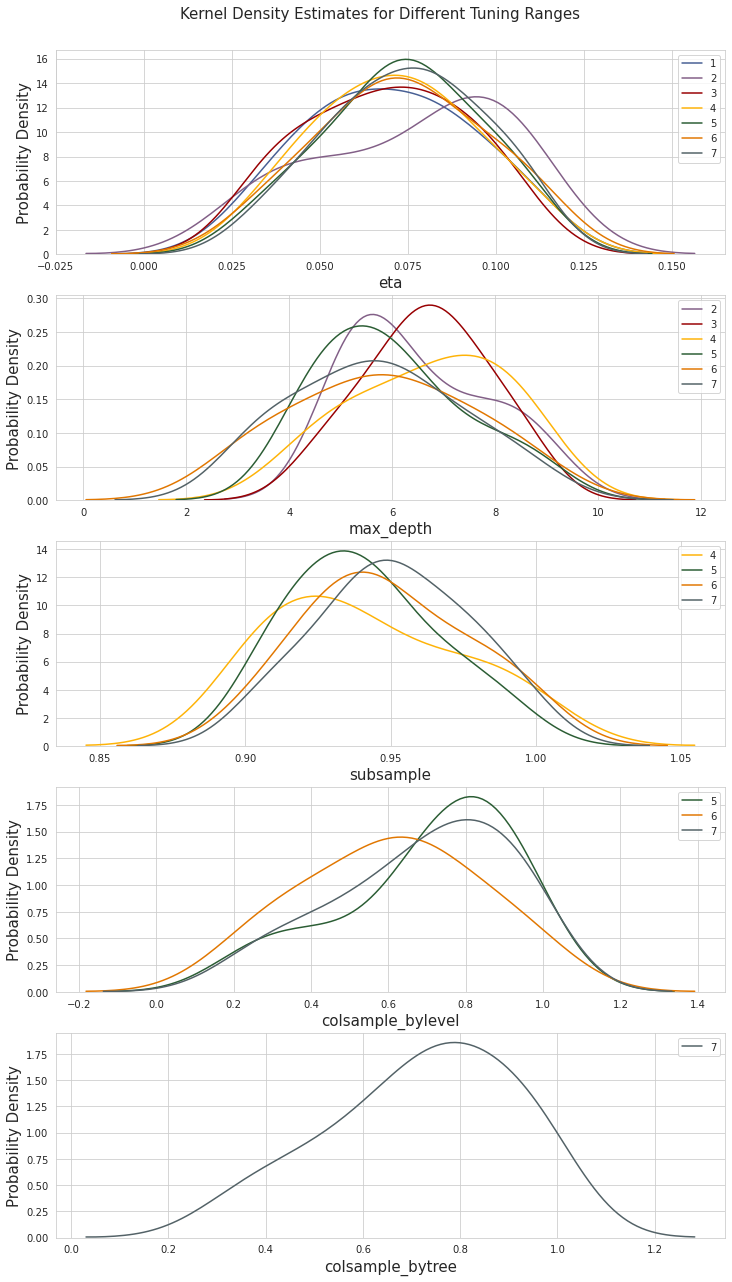

In [147]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5, 
         xgbr_trials_6: 6, 
         xgbr_trials_7: 7
        }
# plot the results, so far
plot_kde(_dict)

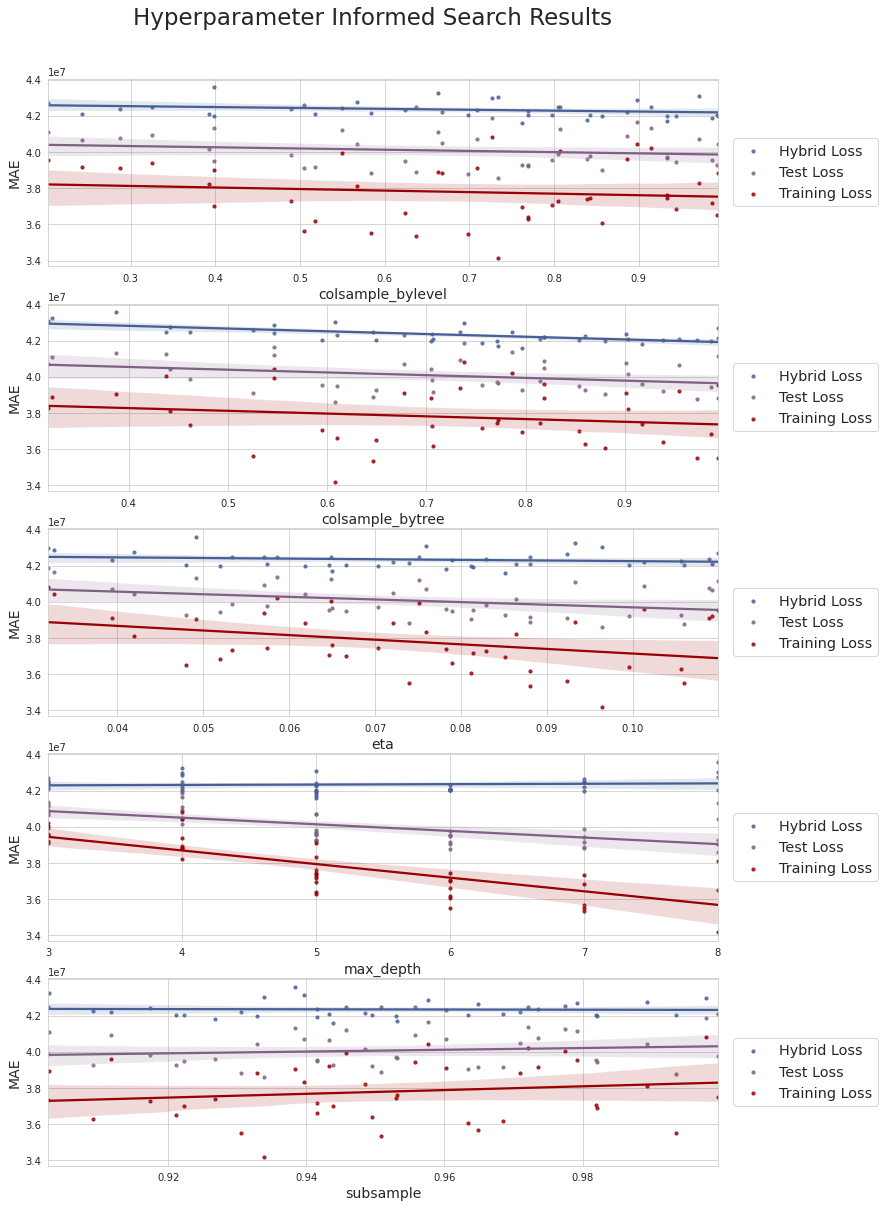

In [148]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_7)

 > **alpha**

In [149]:
# get best hyperparameters from last trials
best_params = xgbr_trials_7.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'alpha': np.linspace(0, 0.1, 11),
    'colsample_bylevel': [best_params['colsample_bylevel']], 
    'colsample_bytree': [best_params['colsample_bytree']], 
    'eta': [best_params['eta']],
    'max_depth': [best_params['max_depth']],
    'subsample': [best_params['subsample']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

alpha [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
colsample_bylevel [0.762233492751935]
colsample_bytree [0.7959289615756886]
eta [0.08516631179466486]
max_depth [5]
subsample [0.9439257320819536]


alpha : 0.0 ...
Hybrid MAE: $41,592,406.40
Test MAE: $39,283,727.60
Overfit Ratio: 0.9442881673357768
Average Boosting Rounds: 493

alpha : 0.01 ...
Hybrid MAE: $41,818,217.20
Test MAE: $39,453,428.40
Overfit Ratio: 0.9429506333972639
Average Boosting Rounds: 495

alpha : 0.02 ...
Hybrid MAE: $41,586,781.60
Test MAE: $39,372,720.00
Overfit Ratio: 0.9467528087405119
Average Boosting Rounds: 497

alpha : 0.03 ...
Hybrid MAE: $41,668,522.00
Test MAE: $39,463,939.20
Overfit Ratio: 0.9472232193245447
Average Boosting Rounds: 496

alpha : 0.04 ...
Hybrid MAE: $41,769,336.80
Test MAE: $39,541,663.60
Overfit Ratio: 0.9466639466106773
Average Boosting Rounds: 497

alpha : 0.05 ...
Hybrid MAE: $41,644,824.00
Test MAE: $39,510,789.60
Overfit Ratio: 0.948975723789248
Average Boosting Rounds: 497

alpha : 0.06 ...
Hybrid MAE: $41,528,772.00
Test MAE: $39,524,276.00
Overfit Ratio: 0.9521569760464988
Average Boosting Rounds: 497

alpha : 0.07 ...
Hybrid MAE: $41,634,379.60
Test MAE: $39,572,957.20
Ov

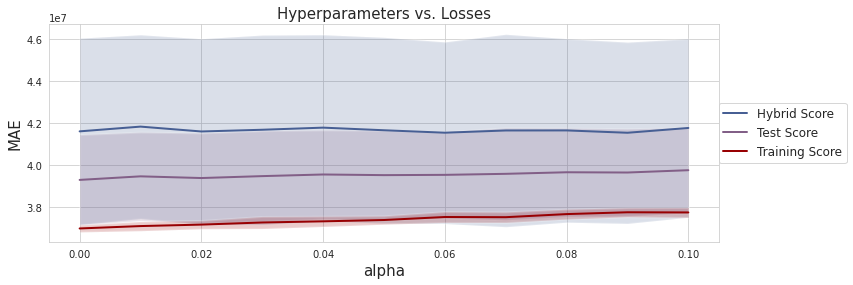

In [150]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, 2e2, get_scratch_cv, 'gpu_hist', param_grid)

In [151]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

Hybrid Loss: $41,592,406.40
Test MAE: $39,283,727.60
Overfit Ratio: 0.9442881673357768
Num Boosters: 493


Three models had improved hybrid losses, with alphas of 0.02, 0.06, and 0.09.<br>
This implies that local minima are scattered throughout the alpha search space.<br>
I'll set the range to start at the default value and let it increase up to 0.1.

 > **xgbr_trials_7a**

In [152]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [153]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 3, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7a)
# save trials object
pickle.dump(xgbr_trials_7a, open('./xgbr_trials/xgbr_trials_7a.pkl', 'wb'))

100%|██████████| 40/40 [02:27<00:00,  3.68s/trial, best loss: 41768080.4]


In [154]:
# get results DataFrame
trials_7a_df = make_trials_df(xgbr_trials_7a)
trials_7a_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
20      1      3         21  41768080.4       37200392.4   39484236.4   
37      1      4         38  41855061.2       36914273.2   39384667.2   
24      1      3         25  41898541.2       36687233.2   39292887.2   
16      1      2         17  41906602.4       37823638.4   39865120.4   
36      1      4         37  41942765.2       36064407.6   39003586.4   
23      1      3         24  41951872.0       36794579.2   39373225.6   
26      1      3         27  41962458.8       37109422.8   39535940.8   
17      1      2         18  41988888.8       37881970.4   39935429.6   
4       1      1          5  42025923.2       38038179.2   40032051.2   
25      1      3         26  42034606.4       37449939.2   39742272.8   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
20      0.945131      494  0.015981           0.669878          0.998118   
37      0.940360      498  0.042005           0.934386          0.850333   
24      0.936550      496  0.038636           0.614216          0.942903   
16      0.951836      492  0.015894           0.602688          0.882237   
36      0.927572      496  0.034376           0.685042          0.952877   
23      0.937466      494  0.023069           0.818523          0.824963   
26      0.941710      496  0.055380           0.453833          0.948993   
17      0.951510      498  0.009320           0.510628          0.867522   
4       0.953549      497  0.074456           0.504699          0.730570   
25      0.945298      499  0.042324           0.707290          0.717755   

         eta  max_depth  subsample  
20  0.059968          6   0.935008  
37  0.101253          5   0.900600  
24  0.059880          7   0.958429  
16  0.068102          5   0.936527  
36  0.060744          8   0.926360  
23  0.072934          6   0.908539  
26  0.060744          7   0.965186  
17  0.066839          5   0.933849  
4   0.084144          5   0.994450  
25  0.044040          8   0.957197

In [155]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

Hybrid Loss: $41,592,406.40
Test MAE: $39,283,727.60
Overfit Ratio: 0.9442881673357768
Num Boosters: 493


The search space where the local minima were found are constrained.<br>
I will narrow some of the broad ranges of the other hyperparameters to lessen the number of values to choose.

In [156]:
best_params

{'colsample_bylevel': 0.762233492751935,
 'colsample_bytree': 0.7959289615756886,
 'eta': 0.08516631179466486,
 'max_depth': 5,
 'subsample': 0.9439257320819536,
 'tree_method': 'gpu_hist',
 'disable_default_eval_metric': 1}

From the number of features selected on the model to beat, I see that the range for both samplings can be above 70%.

 > **xgbr_trials_7b**

In [157]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [158]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 3, 9)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7b)
# save trials object
pickle.dump(xgbr_trials_7b, open('./xgbr_trials/xgbr_trials_7b.pkl', 'wb'))

100%|██████████| 20/20 [02:23<00:00,  7.16s/trial, best loss: 41793219.2]


In [159]:
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7b)
# save trials object
pickle.dump(xgbr_trials_7b, open('./xgbr_trials/xgbr_trials_7b.pkl', 'wb'))

100%|██████████| 40/40 [02:27<00:00,  3.69s/trial, best loss: 41717787.2]


In [160]:
# get results DataFrame
trials_7b_df = make_trials_df(xgbr_trials_7b)
trials_7b_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
29      2      3         30  41717787.2       36533818.4   39125802.8   
33      2      4         34  41733888.8       37175324.8   39454606.8   
23      2      3         24  41784065.6       37686053.6   39735059.6   
5       1      1          6  41793219.2       37914867.2   39854043.2   
18      1      2         19  41796606.0       36287504.4   39042055.2   
20      2      3         21  41809228.8       36243711.2   39026470.0   
32      2      4         33  41822169.6       36472278.4   39147224.0   
13      1      2         14  41843608.0       36331699.2   39087653.6   
38      2      4         39  41855915.6       36577506.8   39216711.2   
19      1      2         20  41869772.8       37656064.8   39762918.8   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
29      0.936852      497  0.046768           0.736799          0.940674   
33      0.945458      496  0.031911           0.745768          0.968278   
23      0.951686      488  0.053426           0.758333          0.873520   
5       0.954445      496  0.078522           0.841594          0.853830   
18      0.932459      487  0.017775           0.951921          0.849831   
20      0.931514      493  0.064035           0.879158          0.913647   
32      0.934687      498  0.058224           0.715100          0.977934   
13      0.932502      485  0.021744           0.960520          0.837949   
38      0.935688      490  0.030682           0.783120          0.964279   
19      0.950129      494  0.039990           0.894662          0.882217   

         eta  max_depth  subsample  
29  0.079388          6   0.966512  
33  0.083184          5   0.954315  
23  0.078352          5   0.966789  
5   0.077519          5   0.900527  
18  0.094373          6   0.986068  
20  0.091440          6   0.967962  
32  0.065590          7   0.966358  
13  0.099090          6   0.996519  
38  0.074828          6   0.950395  
19  0.082149          5   0.983235

In [161]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

Hybrid Loss: $41,592,406.40
Test MAE: $39,283,727.60
Overfit Ratio: 0.9442881673357768
Num Boosters: 493


The informed search has not, yet, found any of the local minima that I observed while running the last grid search.

In [162]:
best_params

{'colsample_bylevel': 0.762233492751935,
 'colsample_bytree': 0.7959289615756886,
 'eta': 0.08516631179466486,
 'max_depth': 5,
 'subsample': 0.9439257320819536,
 'tree_method': 'gpu_hist',
 'disable_default_eval_metric': 1}

I will narrow the range of tree depth to remove move values from the search space.

 > **xgbr_trials_7c**

In [163]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [164]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7c)
# save trials object
pickle.dump(xgbr_trials_7c, open('./xgbr_trials/xgbr_trials_7c.pkl', 'wb'))

100%|██████████| 30/30 [02:23<00:00,  4.77s/trial, best loss: 41684763.6]


In [165]:
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7c)
# save trials object
pickle.dump(xgbr_trials_7c, open('./xgbr_trials/xgbr_trials_7c.pkl', 'wb'))

100%|██████████| 50/50 [02:20<00:00,  2.82s/trial, best loss: 41668041.6]


In [166]:
# get results DataFrame
trials_7c_df = make_trials_df(xgbr_trials_7c)
trials_7c_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
30      2      4         31  41668041.6       37043184.8   39355613.2   
12      1      2         13  41684763.6       36729274.8   39207019.2   
22      1      3         23  41704841.2       37174843.6   39439842.4   
10      1      2         11  41762860.0       36188792.0   38975826.0   
3       1      1          4  41787178.0       37394861.2   39591019.6   
0       1      1          1  41807127.2       37646896.0   39727011.6   
13      1      2         14  41815540.4       36865986.0   39340763.2   
33      2      4         34  41823448.0       37079758.4   39451603.2   
14      1      2         15  41825043.6       37325733.2   39575388.4   
21      1      3         22  41828569.2       38196122.0   40012345.6   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
30      0.944079      493  0.031997           0.971410          0.783243   
12      0.939752      481  0.015897           0.945916          0.915734   
22      0.945579      488  0.019719           0.912427          0.875609   
10      0.931581      469  0.001191           0.992885          0.926026   
3       0.947897      492  0.003483           0.716055          0.980604   
0       0.950744      482  0.033452           0.732854          0.957828   
13      0.939992      489  0.017395           0.937730          0.818479   
33      0.942881      493  0.052318           0.936789          0.792213   
14      0.946162      495  0.097848           0.954151          0.754946   
21      0.957568      492  0.057202           0.872165          0.852218   

         eta  max_depth  subsample  
30  0.062122          6   0.974514  
12  0.082127          6   0.994005  
22  0.060578          6   0.955013  
10  0.093336          6   0.993757  
3   0.109245          4   0.943292  
0   0.108852          4   0.973577  
13  0.067278          6   0.963395  
33  0.065206          6   0.964557  
14  0.080074          6   0.985486  
21  0.070438          5   0.982892

In [167]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

Hybrid Loss: $41,592,406.40
Test MAE: $39,283,727.60
Overfit Ratio: 0.9442881673357768
Num Boosters: 493


The results are getting better.<br>
Shrinking the range of tree depth has narrowed the optimal feature search space.<br>
I will constrain that range a little more.

 > **xgbr_trials_7d**

In [168]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_7d = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [169]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.1), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7d)
# save trials object
pickle.dump(xgbr_trials_7d, open('./xgbr_trials/xgbr_trials_7d.pkl', 'wb'))

100%|██████████| 20/20 [02:14<00:00,  6.72s/trial, best loss: 41610213.2]


In [170]:
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7d)
# save trials object
pickle.dump(xgbr_trials_7d, open('./xgbr_trials/xgbr_trials_7d.pkl', 'wb'))

100%|██████████| 30/30 [02:14<00:00,  4.47s/trial, best loss: 41610213.2]


In [171]:
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_7d)
# save trials object
pickle.dump(xgbr_trials_7d, open('./xgbr_trials/xgbr_trials_7d.pkl', 'wb'))

100%|██████████| 40/40 [02:16<00:00,  3.42s/trial, best loss: 41610213.2]


In [172]:
# get results DataFrame
trials_7d_df = make_trials_df(xgbr_trials_7d)
trials_7d_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
1       1      1          2  41610213.2       37457386.0   39533799.6   
18      1      2         19  41665362.4       36682307.2   39173834.8   
5       1      1          6  41766556.4       36986419.6   39376488.0   
17      1      2         18  41771902.4       37118060.8   39444981.6   
2       1      1          3  41795248.0       37756492.8   39775870.4   
29      2      3         30  41795645.2       37952527.6   39874086.4   
12      1      2         13  41820378.0       37493086.0   39656732.0   
7       1      1          8  41824110.0       38334288.4   40079199.2   
33      3      4         34  41847471.6       38402511.6   40124991.6   
36      3      4         37  41856682.8       38708849.2   40282766.0   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
1       0.950646      493  0.027820           0.800648          0.998212   
18      0.939349      481  0.021852           0.880912          0.908614   
5       0.942467      496  0.001337           0.881156          0.922039   
17      0.944240      484  0.004641           0.890832          0.925067   
2       0.952319      496  0.014498           0.809635          0.991444   
29      0.954903      492  0.052383           0.810701          0.943473   
12      0.948414      494  0.058151           0.929824          0.943784   
7       0.959485      488  0.034057           0.849270          0.933043   
33      0.960251      492  0.039180           0.889085          0.821385   
36      0.963911      492  0.031494           0.857940          0.988436   

         eta  max_depth  subsample  
1   0.109885          4   0.979128  
18  0.101436          5   0.948529  
5   0.082045          5   0.946667  
17  0.081995          5   0.946660  
2   0.109869          4   0.996118  
29  0.105875          4   0.917838  
12  0.080338          5   0.960257  
7   0.090378          4   0.913692  
33  0.067474          5   0.995008  
36  0.075059          4   0.937536

In [173]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

Hybrid Loss: $41,592,406.40
Test MAE: $39,283,727.60
Overfit Ratio: 0.9442881673357768
Num Boosters: 493


The hybrid loss is almost to where it was when I observed the local minima during the grid search.<br>
I will narrow the range of alpha values to only include those near one of those local minima.<br>
The best models are choosing the lowest values for alpha,<br>
So, I will search near the smallest minimum, where alpha is 0.02.

 > **xgbr_trials_8**

In [174]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [175]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1), 
    'eta': hp.uniform('eta', 0.03, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8)
# save trials object
pickle.dump(xgbr_trials_8, open('./xgbr_trials/xgbr_trials_8.pkl', 'wb'))

100%|██████████| 20/20 [02:12<00:00,  6.62s/trial, best loss: 41576778.8]


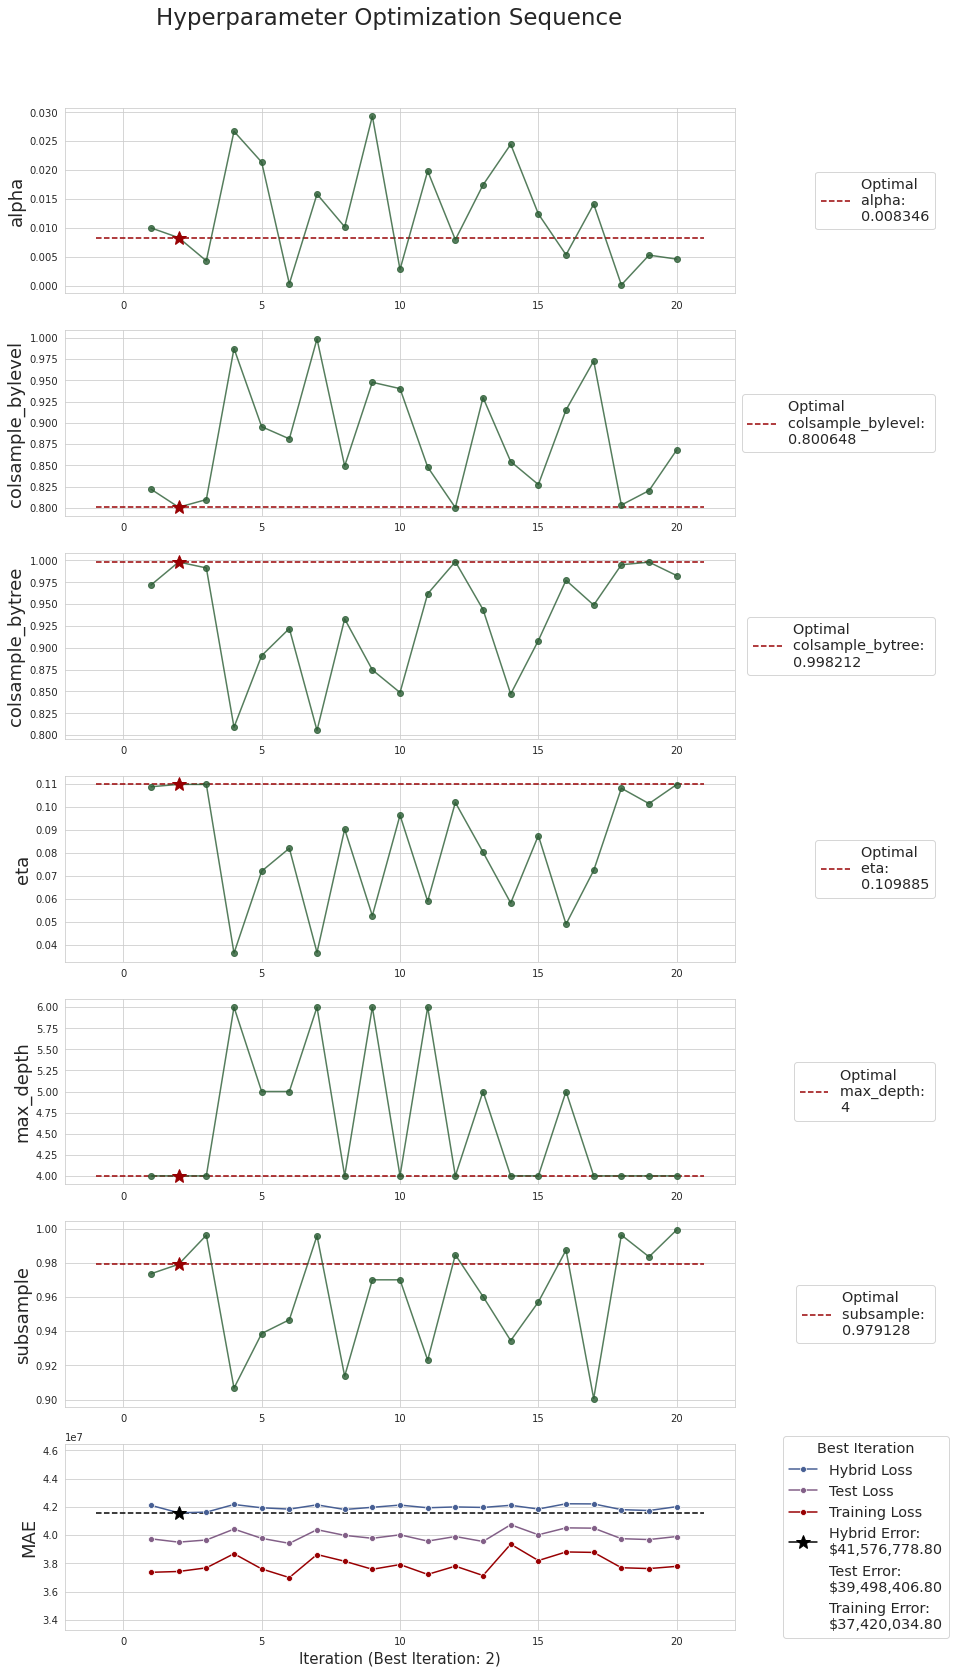

In [176]:
# plot informed search history
plot_param_search(xgbr_trials_8)

In [177]:
# get results DataFrame
trials_8_df = make_trials_df(xgbr_trials_8)
trials_8_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
1       1      1          2  41576778.8       37420034.8   39498406.8   
2       1      1          3  41624278.0       37678519.6   39651398.8   
18      1      2         19  41737630.4       37625816.0   39681723.2   
17      1      2         18  41801527.2       37686220.8   39743874.0   
7       1      1          8  41811519.6       38145326.0   39978422.8   
5       1      1          6  41837725.6       36987516.0   39412620.8   
14      1      2         15  41844750.0       38194711.6   40019730.8   
4       1      1          5  41932697.6       37601459.2   39767078.4   
10      1      2         11  41933614.4       37212988.8   39573301.6   
12      1      2         13  41957290.8       37134677.2   39545984.0   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
1       0.950640      480  0.008346           0.800648          0.998212   
2       0.953393      490  0.004349           0.809635          0.991444   
18      0.951277      492  0.005336           0.820246          0.998085   
17      0.951314      495  0.000195           0.803212          0.995079   
7       0.957343      497  0.010217           0.849270          0.933043   
5       0.941466      496  0.000401           0.881156          0.922039   
14      0.957387      492  0.012451           0.827326          0.908320   
4       0.948456      488  0.021380           0.895482          0.891020   
10      0.943597      496  0.019855           0.847960          0.961826   
12      0.942249      494  0.017445           0.929824          0.943784   

         eta  max_depth  subsample  
1   0.109885          4   0.979128  
2   0.109869          4   0.996118  
18  0.101503          4   0.983484  
17  0.108204          4   0.996233  
7   0.090378          4   0.913692  
5   0.082045          5   0.946667  
14  0.087587          4   0.957070  
4   0.072076          5   0.938613  
10  0.058966          6   0.923028  
12  0.080338          5   0.960257

In [178]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_7)

Hybrid Loss: $41,592,406.40
Test MAE: $39,283,727.60
Overfit Ratio: 0.9442881673357768
Num Boosters: 493


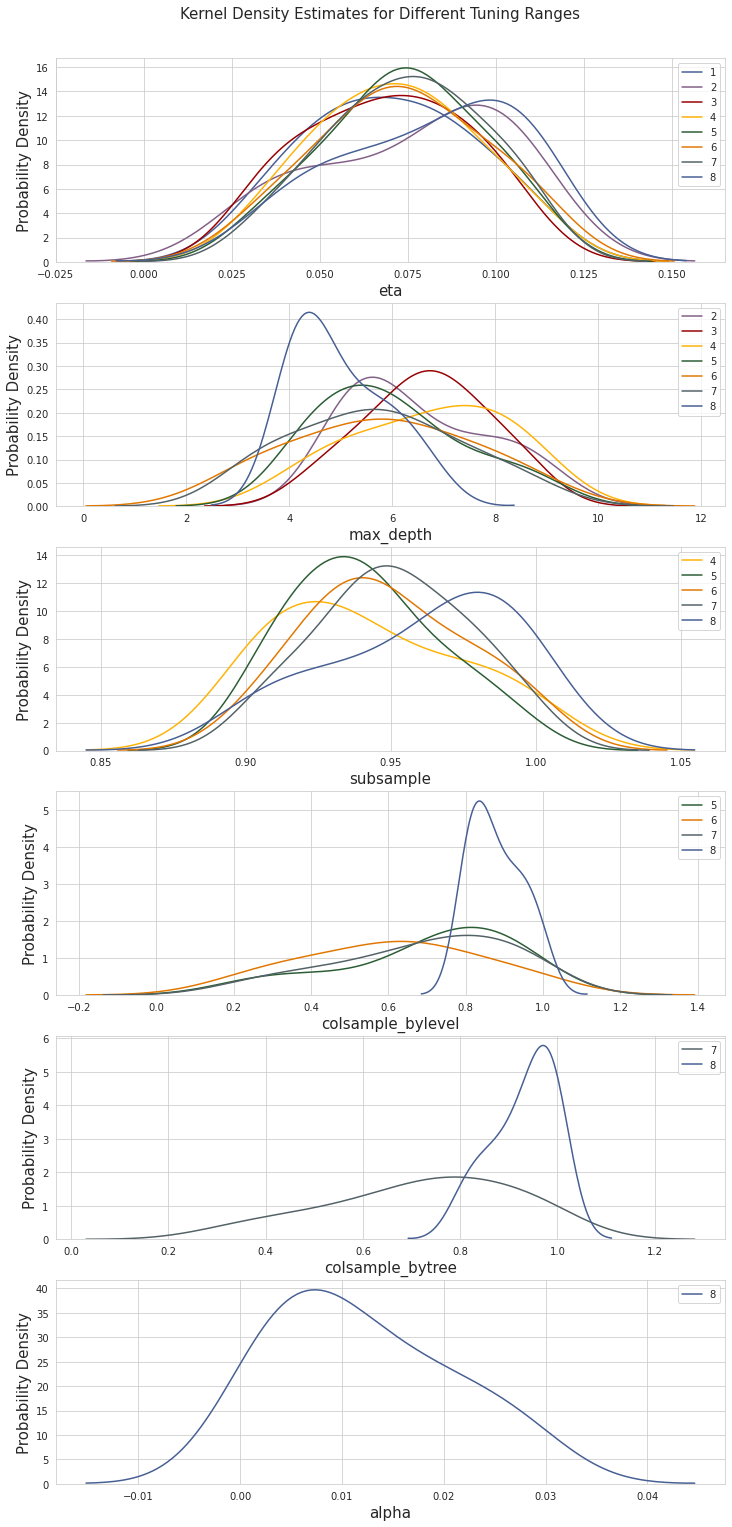

In [179]:
# assemble desired trial runs
_dict = {xgbr_trials_1: 1, 
         xgbr_trials_2: 2, 
         xgbr_trials_3: 3, 
         xgbr_trials_4: 4, 
         xgbr_trials_5: 5, 
         xgbr_trials_6: 6, 
         xgbr_trials_7: 7, 
         xgbr_trials_8: 8
        }
# plot the results, so far
plot_kde(_dict)

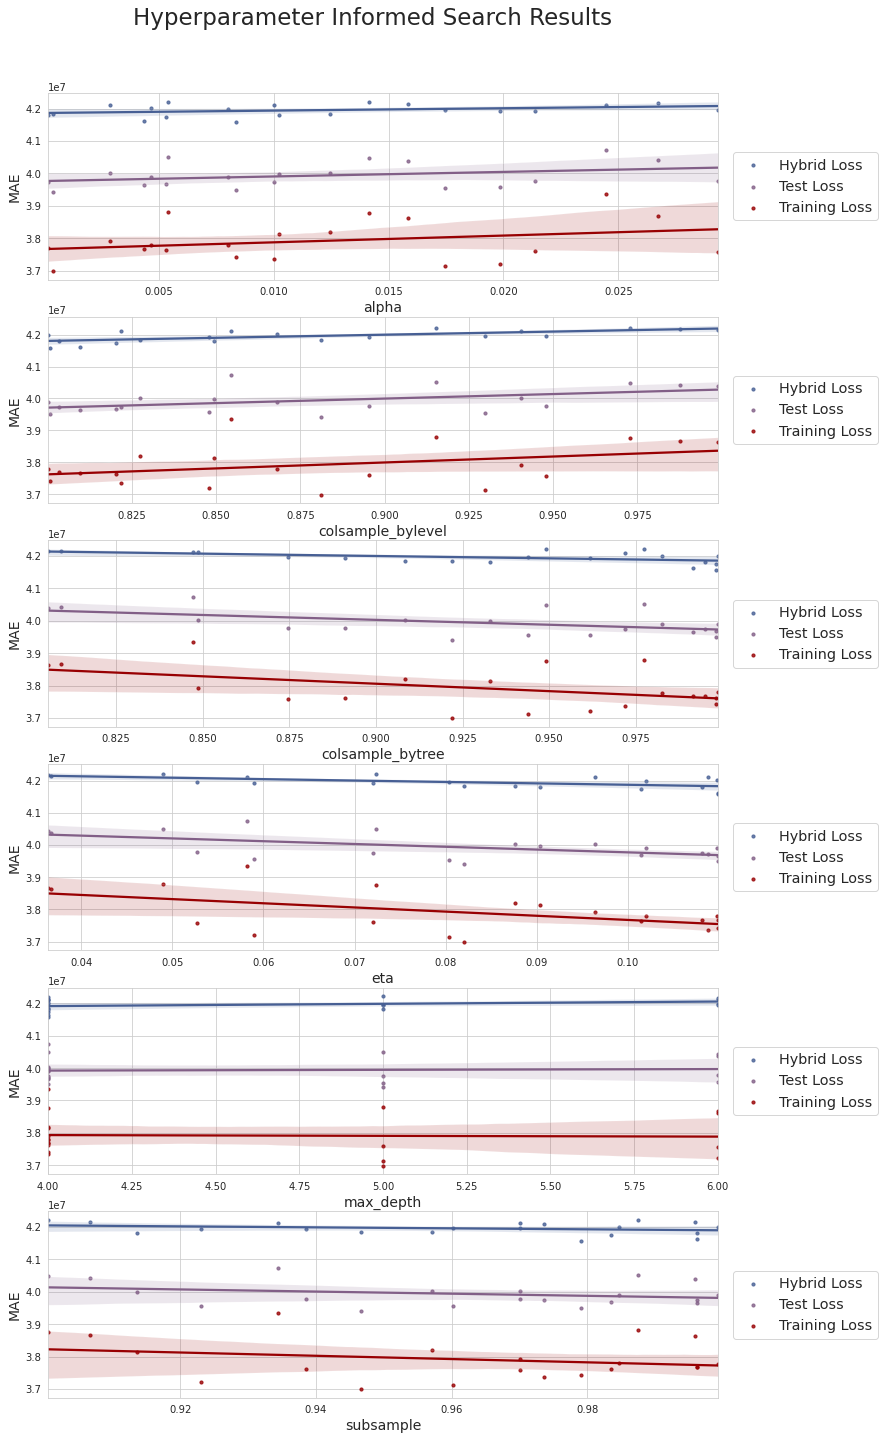

In [180]:
# plot hyperparameters vs. mean absolute errors
plot_maes(xgbr_trials_8)

 > **xgbr_trials_8a**

In [181]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [182]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.8, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1), 
    'eta': hp.uniform('eta', 0.03, 0.12), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 7)), 
    'subsample': hp.uniform('subsample', 0.9, 1)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8a)
# save trials object
pickle.dump(xgbr_trials_8a, open('./xgbr_trials/xgbr_trials_8a.pkl', 'wb'))

100%|██████████| 30/30 [02:17<00:00,  4.60s/trial, best loss: 41581992.4]


In [183]:
# get results DataFrame
trials_8a_df = make_trials_df(xgbr_trials_8a)
trials_8a_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
19      1      2         20  41581992.4       37000775.6   39291384.0   
13      1      2         14  41709534.8       36718006.0   39213770.4   
22      1      3         23  41715670.0       37990756.4   39853213.2   
26      1      3         27  41791546.0       36504246.8   39147896.4   
4       1      1          5  41796458.0       37488565.2   39642511.6   
16      1      2         17  41797673.2       37597890.0   39697781.6   
9       1      1         10  41803002.8       37213634.0   39508318.4   
17      1      2         18  41819422.8       37023820.4   39421621.6   
28      1      3         29  41842022.4       37268816.8   39555419.6   
0       1      1          1  41848210.0       37124157.2   39486183.6   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
19      0.945172      494  0.029482           0.838954          0.963011   
13      0.939599      473  0.020098           0.913799          0.905115   
22      0.956532      492  0.017449           0.924631          0.947215   
26      0.935500      476  0.017038           0.917590          0.886352   
4       0.948726      475  0.022337           0.876175          0.923020   
16      0.950205      480  0.025566           0.972371          0.900035   
9       0.945077      499  0.014796           0.849643          0.800216   
17      0.942365      486  0.021109           0.907949          0.918816   
28      0.945122      491  0.005789           0.884457          0.952025   
0       0.943193      479  0.010036           0.821903          0.971885   

         eta  max_depth  subsample  
19  0.089340          5   0.934802  
13  0.099948          5   0.950917  
22  0.095267          4   0.930509  
26  0.079265          6   0.953573  
4   0.090912          5   0.994450  
16  0.111101          4   0.958880  
9   0.057022          6   0.965379  
17  0.088760          5   0.979226  
28  0.115110          4   0.971110  
0   0.118708          4   0.973577

In [184]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

Hybrid Loss: $41,576,778.80
Test MAE: $39,498,406.80
Overfit Ratio: 0.9506402303671557
Num Boosters: 480


In [185]:
def get_param_range(trials_lst, loss_thresh, ratio_thresh):
    """Returns DataFrame with range of hyperparameters from best models of trials"""
    # create empty objects to hold sorted values
    param_dict = defaultdict(list)
    param_range_dict = defaultdict(list)
    best_models_lst = []
    # roll through trial objects
    for trial in trials_lst:
        # get each model from trial object
        for model in trial:
            # sort models by performance
            if (model['result']['loss'] < loss_thresh
               ) & (model['result']['scores_ratio'] > ratio_thresh):
                # extract desired models
                best_models_lst.append(model)
        # roll through best models
        for best_model in best_models_lst:
            # extract hyperparameter values of desired models
            for param, val in best_model['result']['params'].items():
                param_dict[param].append(val)
    # roll through each hyperparameter
    for hp, val_lst in param_dict.items():
        # filter out operational params
        if hp not in ['tree_method', 'disable_default_eval_metric']:
            # extract range of hyperparameter values for all best models in trails objects
            param_range_dict[hp].append((np.min(val_lst), np.max(val_lst)))
        
    return pd.DataFrame(param_range_dict)

In [186]:
# assemble desired trial runs
_lst = [xgbr_trials_7, 
        xgbr_trials_8, 
        xgbr_trials_8a
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.16e7, 0.94)

colsample_bylevel  \
0  (0.762233492751935, 0.8389544608313102)   

                          colsample_bytree  \
0  (0.7959289615756886, 0.998211625219807)   

                                          eta max_depth  \
0  (0.08516631179466486, 0.10988537290140626)    (4, 5)   

                                  subsample  \
0  (0.9348019481286545, 0.9791284992184395)   

                                          alpha  
0  (0.008346132602249966, 0.029481759134121654)

 > **xgbr_trials_8b**

In [187]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [188]:
hp_space = {
    'alpha': hp.uniform('alpha', 0, 0.03), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.76, 0.84), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.79, 1), 
    'eta': hp.uniform('eta', 0.085, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 6)), 
    'subsample': hp.uniform('subsample', 0.93, 0.98)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8b)
# save trials object
pickle.dump(xgbr_trials_8b, open('./xgbr_trials/xgbr_trials_8b.pkl', 'wb'))

100%|██████████| 30/30 [02:10<00:00,  4.36s/trial, best loss: 41579184.4]


In [189]:
# get results DataFrame
trials_8b_df = make_trials_df(xgbr_trials_8b)
trials_8b_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
11      1      2         12  41579184.4       37473195.6   39526190.0   
18      1      2         19  41617840.4       37392785.2   39505312.8   
15      1      2         16  41621698.8       37537672.4   39579685.6   
25      1      3         26  41654931.6       37603846.0   39629388.8   
22      1      3         23  41707620.8       37725919.2   39716770.0   
23      1      3         24  41711768.8       37453680.0   39582724.4   
1       1      1          2  41726773.6       37250950.4   39488862.0   
24      1      3         25  41739501.6       37654849.6   39697175.6   
19      1      2         20  41742749.2       37360244.4   39551496.8   
0       1      1          1  41755674.4       37327044.8   39541359.6   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
11      0.951211      481  0.008000           0.760061          0.998582   
18      0.949704      480  0.000557           0.804519          0.995772   
15      0.951356      490  0.005384           0.806075          0.980417   
25      0.951775      496  0.008060           0.805578          0.881224   
22      0.952775      482  0.002817           0.785323          0.935910   
23      0.949382      491  0.011005           0.797338          0.967051   
1       0.946500      497  0.008346           0.760259          0.998122   
24      0.951393      496  0.004261           0.767991          0.906449   
19      0.947301      477  0.001611           0.823573          0.999133   
0       0.947036      498  0.010036           0.768761          0.970479   

         eta  max_depth  subsample  
11  0.107502          4   0.972340  
18  0.107169          4   0.975745  
15  0.101606          4   0.970981  
25  0.106341          4   0.962202  
22  0.095447          4   0.974225  
23  0.108067          4   0.953275  
1   0.109964          4   0.969564  
24  0.104018          4   0.967787  
19  0.107335          4   0.974764  
0   0.109641          4   0.966789

In [190]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

Hybrid Loss: $41,576,778.80
Test MAE: $39,498,406.80
Overfit Ratio: 0.9506402303671557
Num Boosters: 480


In [191]:
# assemble desired trial runs
_lst = [xgbr_trials_8, 
        xgbr_trials_8b
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.16e7, 0.95)

alpha  \
0  (0.008000437719865347, 0.008346132602249966)   

                          colsample_bylevel  \
0  (0.7600610127017854, 0.8006483514644671)   

                          colsample_bytree  \
0  (0.998211625219807, 0.9985823303886991)   

                                          eta max_depth  \
0  (0.10750203541712977, 0.10988537290140626)    (4, 4)   

                                  subsample  
0  (0.9723399395675257, 0.9791284992184395)

 > **xgbr_trials_8c**

In [192]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_8c = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [193]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.008, 0.0084), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.76, 0.81), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.99, 1), 
    'eta': hp.uniform('eta', 0.1, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.97, 0.98)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_8c)
# save trials object
pickle.dump(xgbr_trials_8c, open('./xgbr_trials/xgbr_trials_8c.pkl', 'wb'))

100%|██████████| 20/20 [02:09<00:00,  6.47s/trial, best loss: 41578925.6]


In [194]:
# get results DataFrame
trials_8c_df = make_trials_df(xgbr_trials_8c)
trials_8c_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
8       1      1          9  41578925.6       37523718.4   39551322.0   
0       1      1          1  41621184.8       37298344.0   39459764.4   
7       1      1          8  41645166.4       37367088.8   39506127.6   
12      1      2         13  41648490.4       37627662.4   39638076.4   
2       1      1          3  41653400.0       37519980.8   39586690.4   
11      1      2         12  41678315.2       37541650.4   39609982.8   
3       1      1          4  41680886.4       37317258.4   39499072.4   
15      1      2         16  41695167.2       37353385.6   39524276.4   
18      1      2         19  41696986.8       37501896.4   39599441.6   
17      1      2         18  41732838.0       37553218.8   39643028.4   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
8       0.951752      489  0.008400           0.794506          0.992837   
0       0.948071      485  0.008134           0.765476          0.998594   
7       0.948927      486  0.008231           0.769161          0.997909   
12      0.952521      479  0.008399           0.774221          0.994431   
2       0.950797      490  0.008382           0.797770          0.992307   
11      0.950890      489  0.008309           0.789076          0.993173   
3       0.947753      494  0.008014           0.762676          0.999353   
15      0.948144      494  0.008005           0.801037          0.996862   
18      0.950043      466  0.008114           0.783798          0.993555   
17      0.950538      489  0.008154           0.766055          0.998292   

         eta  max_depth  subsample  
8   0.103992          4   0.972250  
0   0.109856          4   0.977358  
7   0.108329          4   0.977285  
12  0.101723          4   0.975869  
2   0.102910          4   0.970265  
11  0.103405          4   0.972197  
3   0.109906          4   0.974329  
15  0.107901          4   0.973328  
18  0.108794          4   0.978607  
17  0.102046          4   0.977184

In [195]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

Hybrid Loss: $41,576,778.80
Test MAE: $39,498,406.80
Overfit Ratio: 0.9506402303671557
Num Boosters: 480


In [196]:
# assemble desired trial runs
_lst = [xgbr_trials_8, 
        xgbr_trials_8c
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.16e7, 0.95)

alpha  \
0  (0.008346132602249966, 0.008399877453646298)   

                          colsample_bylevel  \
0  (0.7945059736224588, 0.8006483514644671)   

                          colsample_bytree  \
0  (0.9928373574751514, 0.998211625219807)   

                                          eta max_depth  \
0  (0.10399238426124228, 0.10988537290140626)    (4, 4)   

                                  subsample  
0  (0.9722498486718789, 0.9791284992184395)

 > **xgbr_trials_9**

In [197]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_9 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [198]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.0083, 0.0084), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.79, 0.81), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.99, 1), 
    'eta': hp.uniform('eta', 0.1, 0.11), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.97, 0.98)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_9)
# save trials object
pickle.dump(xgbr_trials_9, open('./xgbr_trials/xgbr_trials_9.pkl', 'wb'))

100%|██████████| 30/30 [02:09<00:00,  4.31s/trial, best loss: 41530780.4]


In [199]:
# get results DataFrame
trials_9_df = make_trials_df(xgbr_trials_9)
trials_9_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
18      1      2         19  41530780.4       37350034.0   39440407.2   
7       1      1          8  41537809.6       37459687.2   39498748.4   
23      1      3         24  41573578.0       37561178.0   39567378.0   
20      1      3         21  41577349.6       37370911.2   39474130.4   
25      1      3         26  41651738.0       37513812.4   39582775.2   
27      1      3         28  41683637.6       37447194.4   39565416.0   
8       1      1          9  41690585.2       37383638.8   39537112.0   
26      1      3         27  41700654.4       37308740.0   39504697.2   
14      1      2         15  41706586.4       37449490.4   39578038.4   
24      1      3         25  41732073.6       37338468.0   39535270.8   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
18      0.950177      492  0.008345           0.797923          0.993870   
7       0.951382      477  0.008334           0.794927          0.996652   
23      0.952319      469  0.008360           0.799765          0.991227   
20      0.949855      495  0.008341           0.797160          0.993616   
25      0.950453      486  0.008329           0.791821          0.993041   
27      0.949247      498  0.008365           0.796600          0.991584   
8       0.948558      486  0.008394           0.805733          0.993762   
26      0.947658      493  0.008319           0.798008          0.998992   
14      0.949522      490  0.008371           0.801975          0.992158   
24      0.947635      490  0.008349           0.794364          0.994405   

         eta  max_depth  subsample  
18  0.107001          4   0.972679  
7   0.107547          4   0.971369  
23  0.107503          4   0.975729  
20  0.106690          4   0.974467  
25  0.104739          4   0.971798  
27  0.104055          4   0.975419  
8   0.107454          4   0.970408  
26  0.107292          4   0.973945  
14  0.105407          4   0.976149  
24  0.109205          4   0.973426

In [200]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_8)

Hybrid Loss: $41,576,778.80
Test MAE: $39,498,406.80
Overfit Ratio: 0.9506402303671557
Num Boosters: 480


 > **xgbr_trials_9a**

In [201]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_9a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [202]:
# create informed search space using a single default value
hp_space = {
    'alpha': hp.choice(
        'alpha', [0.09, 
                  0.09]), 
    'colsample_bylevel': hp.choice(
        'colsample_bylevel', [best_params['colsample_bylevel'], 
                              best_params['colsample_bylevel']]), 
    'colsample_bytree': hp.choice(
        'colsample_bytree', [best_params['colsample_bytree'], 
                             best_params['colsample_bytree']]), 
    'eta': hp.choice(
        'eta', [best_params['eta'], 
                best_params['eta']]), 
    'max_depth': hp.choice(
        'max_depth', [best_params['max_depth'], 
                      best_params['max_depth']]), 
    'subsample': hp.choice(
        'subsample', [best_params['subsample'], 
                      best_params['subsample']])
}
# call optimization function
fmin_objective = partial(objective, features=X_train, target=y_train, 
                         delta=2e2, cv_type=get_scratch_cv, 
                         processor_type='gpu_hist', max_boost_round=500)
fmin(fn=fmin_objective, space=hp_space, max_evals=1, trials=xgbr_trials_9a, 
     algo=tpe.suggest, rstate=np.random.RandomState(27))

# save trials object
pickle.dump(xgbr_trials_9a, open('./xgbr_trials/xgbr_trials_9a.pkl', 'wb'))

100%|██████████| 1/1 [00:13<00:00, 13.78s/trial, best loss: 41525702.0]


In [203]:
# get results DataFrame
trials_9a_df = make_trials_df(xgbr_trials_9a)
trials_9a_df

trial  batch  iteration        loss  training_scores  test_scores  \
0      0      0          1  41525702.0       37745021.2   39635361.6   

   scores_ratio  n_boost  alpha  colsample_bylevel  colsample_bytree  \
0      0.955176      493   0.09           0.762233          0.795929   

        eta  max_depth  subsample  
0  0.085166          5   0.943926

In [204]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_9)

Hybrid Loss: $41,530,780.40
Test MAE: $39,440,407.20
Overfit Ratio: 0.9501767857475667
Num Boosters: 492


In [205]:
# observe metrics of best sample from previous grid search
print_best_trial(xgbr_trials_9a)

Hybrid Loss: $41,525,702.00
Test MAE: $39,635,361.60
Overfit Ratio: 0.9551763192595584
Num Boosters: 493


In [206]:
# assemble desired trial runs
_lst = [xgbr_trials_9, 
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.154e7, 0.95)

alpha  \
0  (0.008334056963660304, 0.008345227920739565)   

                          colsample_bylevel  \
0  (0.7949269754177388, 0.7979227380863954)   

                           colsample_bytree  \
0  (0.9938696047066362, 0.9966521395754558)   

                                          eta max_depth  \
0  (0.10700051473299979, 0.10754722669605234)    (4, 4)   

                                  subsample  
0  (0.9713691735304857, 0.9726787287342245)

 > **xgbr_trials_10**

In [207]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_10 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [208]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.00833, 0.00835), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.794, 0.798), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.993, 0.997), 
    'eta': hp.uniform('eta', 0.107, 0.108), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.971, 0.973)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_10)
# save trials object
pickle.dump(xgbr_trials_10, open('./xgbr_trials/xgbr_trials_10.pkl', 'wb'))

100%|██████████| 20/20 [02:09<00:00,  6.47s/trial, best loss: 41462147.2]


In [209]:
# get results DataFrame
trials_10_df = make_trials_df(xgbr_trials_10)
trials_10_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
3       1      1          4  41462147.2       37525410.4   39493778.8   
6       1      1          7  41522912.4       37343380.4   39433146.4   
13      1      2         14  41539148.4       37323034.0   39431091.2   
12      1      2         13  41661647.2       37323642.4   39492644.8   
5       1      1          6  41673856.8       37363028.8   39518442.8   
4       1      1          5  41687790.4       37368168.8   39527979.6   
1       1      1          2  41708757.6       37342127.2   39525442.4   
17      1      2         18  41732379.6       37312976.4   39522678.0   
14      1      2         15  41745888.0       37393272.8   39569580.4   
11      1      2         12  41753132.8       37372411.2   39562772.0   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
3       0.953294      479  0.008348           0.797751          0.993181   
6       0.950061      491  0.008344           0.796460          0.994676   
13      0.950025      492  0.008337           0.794870          0.995192   
12      0.947920      494  0.008330           0.795746          0.993683   
5       0.949028      493  0.008347           0.797984          0.993103   
4       0.948650      488  0.008350           0.797974          0.993040   
1       0.947654      491  0.008336           0.794013          0.996964   
17      0.947295      496  0.008344           0.796730          0.994707   
14      0.948168      482  0.008347           0.797248          0.994304   
11      0.948050      495  0.008343           0.797152          0.995540   

         eta  max_depth  subsample  
3   0.107080          4   0.971134  
6   0.107403          4   0.971701  
13  0.107195          4   0.971422  
12  0.107657          4   0.972013  
5   0.107028          4   0.971147  
4   0.107015          4   0.971107  
1   0.107999          4   0.972583  
17  0.107468          4   0.971340  
14  0.107521          4   0.972253  
11  0.107222          4   0.971391

In [210]:
# observe metrics of best sample from previous grid search
print_best_trial(xgbr_trials_9a)

Hybrid Loss: $41,525,702.00
Test MAE: $39,635,361.60
Overfit Ratio: 0.9551763192595584
Num Boosters: 493


In [211]:
# assemble desired trial runs
_lst = [xgbr_trials_10, 
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.153e7, 0.95)

alpha  \
0  (0.008344386439646558, 0.008347804205762404)   

                          colsample_bylevel  \
0  (0.7964600209907272, 0.7977505614900624)   

                           colsample_bytree  \
0  (0.9931814282579825, 0.9946758835137735)   

                                        eta max_depth  \
0  (0.1070795699029182, 0.1074025848636665)    (4, 4)   

                                  subsample  
0  (0.9711341655619561, 0.9717010464646293)

 > **xgbr_trials_10a**

In [212]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_10a = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [213]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.00834, 0.00835), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.796, 0.798), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.993, 0.995), 
    'eta': hp.uniform('eta', 0.107, 0.108), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.971, 0.972)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_10a)
# save trials object
pickle.dump(xgbr_trials_10a, open('./xgbr_trials/xgbr_trials_10a.pkl', 'wb'))

100%|██████████| 20/20 [02:09<00:00,  6.46s/trial, best loss: 41499311.6]


In [214]:
# get results DataFrame
trials_10a_df = make_trials_df(xgbr_trials_10a)
trials_10a_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
9       1      1         10  41499311.6       37390150.8   39444731.2   
6       1      1          7  41503087.6       37321369.2   39412228.4   
15      1      2         16  41558632.4       37402613.2   39480622.8   
0       1      1          1  41603526.4       37322568.8   39463047.6   
17      1      2         18  41631775.2       37395563.2   39513669.2   
10      1      2         11  41649577.2       37369515.6   39509546.4   
12      1      2         13  41651834.4       37265908.0   39458871.2   
1       1      1          2  41658710.8       37317652.4   39488181.6   
18      1      2         19  41681840.0       37464149.6   39572994.8   
7       1      1          8  41682153.6       37339219.2   39510686.4   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
9       0.951337      486  0.008342           0.797486          0.993587   
6       0.950276      497  0.008342           0.797989          0.993054   
15      0.950642      480  0.008348           0.797108          0.993944   
0       0.948815      491  0.008343           0.796219          0.994719   
17      0.949789      487  0.008341           0.797749          0.993156   
10      0.948811      490  0.008346           0.797456          0.993626   
12      0.947481      490  0.008345           0.797034          0.994500   
1       0.947822      494  0.008343           0.796006          0.994982   
18      0.950238      487  0.008342           0.797304          0.993683   
7       0.948391      494  0.008340           0.797996          0.993007   

         eta  max_depth  subsample  
9   0.107238          4   0.971171  
6   0.107083          4   0.971060  
15  0.107213          4   0.971166  
0   0.107986          4   0.971736  
17  0.107131          4   0.971083  
10  0.107353          4   0.971309  
12  0.107536          4   0.971231  
1   0.107999          4   0.971791  
18  0.107102          4   0.971091  
7   0.107007          4   0.971010

In [215]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_10)

Hybrid Loss: $41,462,147.20
Test MAE: $39,493,778.80
Overfit Ratio: 0.9532942760214509
Num Boosters: 479


In [216]:
# assemble desired trial runs
_lst = [xgbr_trials_10, 
        xgbr_trials_10a, 
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 4.15e7, 0.95)

alpha  \
0  (0.008342035656730352, 0.008347804205762404)   

                          colsample_bylevel  \
0  (0.7974858069904758, 0.7977505614900624)   

                           colsample_bytree  \
0  (0.9931814282579825, 0.9935874072087142)   

                                         eta max_depth  \
0  (0.1070795699029182, 0.10723768103959812)    (4, 4)   

                                  subsample  
0  (0.9711341655619561, 0.9711714531947662)

 > **xgbr_trials_10b**

In [217]:
# instantiate trials object for XGBoost Regressor optimization
xgbr_trials_10b = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [218]:
hp_space = {
    'alpha': hp.uniform('alpha', 0.00834, 0.00835), 
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.797, 0.798), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.993, 0.994), 
    'eta': hp.uniform('eta', 0.107, 0.108), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 4, 4.1)), 
    'subsample': hp.uniform('subsample', 0.971, 0.972)
}
# call optimization function
run_trial_batches(X_train, y_train, 2e2, 
                  get_scratch_cv, 'gpu_hist', 
                  hp_space, xgbr_trials_10b)
# save trials object
pickle.dump(xgbr_trials_10b, open('./xgbr_trials/xgbr_trials_10b.pkl', 'wb'))

100%|██████████| 20/20 [02:09<00:00,  6.47s/trial, best loss: 41499311.6]


In [219]:
# get results DataFrame
trials_10b_df = make_trials_df(xgbr_trials_10b)
trials_10b_df.head(10)

trial  batch  iteration        loss  training_scores  test_scores  \
9       1      1         10  41499311.6       37390150.8   39444731.2   
6       1      1          7  41503087.6       37321369.2   39412228.4   
15      1      2         16  41558632.4       37402613.2   39480622.8   
0       1      1          1  41603526.4       37322568.8   39463047.6   
17      1      2         18  41631775.2       37395563.2   39513669.2   
10      1      2         11  41649577.2       37369515.6   39509546.4   
12      1      2         13  41651834.4       37265908.0   39458871.2   
1       1      1          2  41658710.8       37317652.4   39488181.6   
18      1      2         19  41681840.0       37464149.6   39572994.8   
7       1      1          8  41682153.6       37339219.2   39510686.4   

    scores_ratio  n_boost     alpha  colsample_bylevel  colsample_bytree  \
9       0.951337      486  0.008342           0.797743          0.993294   
6       0.950276      497  0.008342           0.797994          0.993027   
15      0.950642      480  0.008348           0.797554          0.993472   
0       0.948815      491  0.008343           0.797110          0.993859   
17      0.949789      487  0.008341           0.797874          0.993078   
10      0.948811      490  0.008346           0.797728          0.993313   
12      0.947481      490  0.008345           0.797517          0.993750   
1       0.947822      494  0.008343           0.797003          0.993991   
18      0.950238      487  0.008342           0.797652          0.993342   
7       0.948391      494  0.008340           0.797998          0.993003   

         eta  max_depth  subsample  
9   0.107238          4   0.971171  
6   0.107083          4   0.971060  
15  0.107213          4   0.971166  
0   0.107986          4   0.971736  
17  0.107131          4   0.971083  
10  0.107353          4   0.971309  
12  0.107536          4   0.971231  
1   0.107999          4   0.971791  
18  0.107102          4   0.971091  
7   0.107007          4   0.971010

In [220]:
# observe metrics of best trial from previous trials object
print_best_trial(xgbr_trials_10)

Hybrid Loss: $41,462,147.20
Test MAE: $39,493,778.80
Overfit Ratio: 0.9532942760214509
Num Boosters: 479


In [221]:
def join_losses(trials_dict):
    """Extracts losses and hyperparameters for best estimator of each trials object"""
    # specify columns to extract
    loss_cols = ['loss', 'training_scores', 'test_scores', 'scores_ratio']
    # instantiate empty DataFrame
    df = pd.DataFrame()
    # iterate through trials objects
    for key, value in trials_dict.items():
        # extract metrics
        loss_df = pd.DataFrame(
            key.best_trial['result'], index=[value], columns=loss_cols)
        # extract parameters for best estimator of each trial session
        params_df = pd.DataFrame(
            key.best_trial['result']['params'], index=[value])
        # put it all together
        trials_df = loss_df.join(params_df)
        df = pd.concat([df, trials_df])
        df.reset_index()
        
    return df

In [222]:
def plot_metrics(trials_dict):
    """Plot loss metrics and ratio of training and test losses for best ensembles"""
    # establish subplots
    fig, axes = plt.subplots(nrows=2, figsize=(12, 9))
    # construct DataFrame
    df = join_losses(trials_dict)
    # plot loss metrics
    plt.subplot(2, 1, 1)
    sns.lineplot(x=df.index, y='loss', data=df, label='Hybrid Loss')
    sns.lineplot(x=df.index, y='test_scores', data=df, label='Test Loss')
    sns.lineplot(x=df.index, y='training_scores', data=df, label='Training Loss')
    
    plt.ylabel('MAE', fontsize=15)

    plt.legend()
    plt.title('Mean Absolute Errors for Best Ensamble of Each Trial')
    # plot training test loss ratio
    plt.subplot(2, 1, 2)
    sns.lineplot(x=df.index, y='scores_ratio', data=df)
    
    plt.xlabel('Trials', fontsize=15)
    plt.ylabel('Training to Test Loss Ratio', fontsize=15)

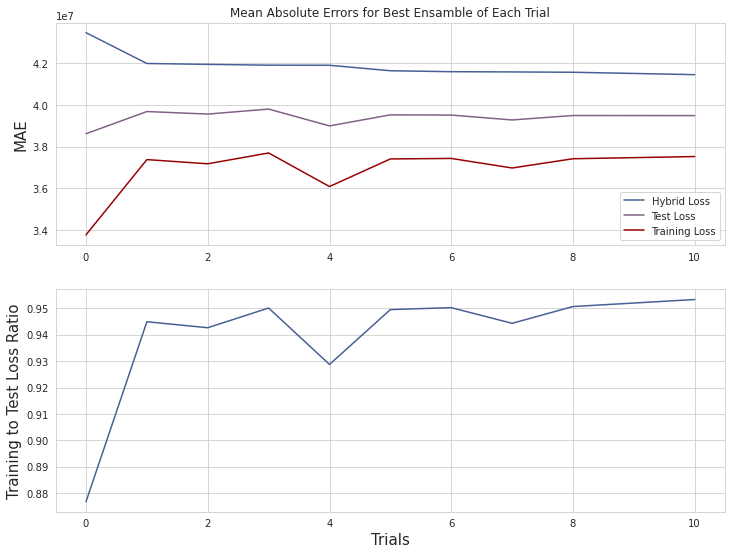

In [223]:
# assemble all trial runs
trials_dict = {xgbr_trials_0: 0, 
               xgbr_trials_1: 1, 
               xgbr_trials_2: 2, 
               xgbr_trials_3: 3, 
               xgbr_trials_4: 4, 
               xgbr_trials_5: 5, 
               xgbr_trials_6: 6, 
               xgbr_trials_7: 7, 
               xgbr_trials_8: 8, 
               xgbr_trials_10: 9, 
               xgbr_trials_10: 10
              }
# plot the results
plot_metrics(trials_dict)

All of the top 10 models chose a node weight value of 1, as expected.

The first sampling method I will adjust is the percent of observations to use at each round.

 > **reg_lambda**

Ridge regularization penalizes the larger errors to prevent overfitting.<br>
Recall, the default value is 0, which means no regularization.

Looking at these plots, it is obvious that the minimization of the overfitting is the main goal for this method.<br>
All of the average MAE lines are way higher than the ones produces by the previous trials.

Now, I believe this is as far as I can traditionally tune the hyperparameters, but I have one more card to play.<br>
I'm going to cherry pick the ranges of hyperparameters from trials 12 and 13, the last two before the detour.<br>
This will squeze the search into a tight area I know is fruitful to see if I can hunt for lower ground.<br>
After extensively searching for a good local minimum, I'm settling down into it to see if I've found its true bottom.<br>
As I mentioned before the sidetrack, I will put the number of trees back to 250.

 > **XGBoost Final Evaluation**

While evaluating the final model on the validation data, I'd, also, like to know how well my unorthodox strategy worked.

First, I'll see what the error of base model would have been, without any hyperparameter tuning.

In [224]:
def print_validation_results(X, y, trials=None, params={}):
    """Print final validation error & percent difference between training and validation"""
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=27)
    # get hyperparameters from trials object
    if trials:
        params = trials.best_trial['result']['params']
    # get errors
    train_results = get_scratch_cv(X_train, y_train, 2e2, 'gpu_hist', params=params)
    test_results = get_scratch_cv(X_test, y_test, 2e2, 'gpu_hist', params=params)
    # average score over folds
    train_mae = np.mean(train_results['test_mae'])
    test_mae = np.mean(test_results['test_mae'])
    # get fractional difference between training and test errors
    frac_diff = (test_mae - train_mae) / test_mae
    
    print('Training Error: {}\nValidation Error: {}\nPercent Difference: {:,.2f}%'.format(
        make_money(train_mae), make_money(test_mae), frac_diff * 100))

In [225]:
# get validation results without tuning
print_validation_results(X, y)

Training Error: $38,621,209.60
Validation Error: $43,847,383.60
Percent Difference: 11.92%


The base model's error is nearly 14% worse on the validation set than it was on the training data.

Next, I'll find out how the model with the best test score did on the validation set.<br>
Recall, the test score was the first part of my hybrid loss function.<br>
This is the loss value that's the standard one to optimize.

In [226]:
# create DataFrame with all trials
trials_df = join_losses(trials_dict)
trials_df

loss  training_scores  test_scores  scores_ratio  max_depth  \
0   43479779.6       33762639.6   38621209.6      0.876798        6.0   
1   41998773.6       37378924.0   39688848.8      0.944888        NaN   
2   41955692.4       37177240.4   39566466.4      0.942626        5.0   
3   41917614.4       37697583.2   39807598.8      0.950080        6.0   
4   41912622.8       36084106.0   38998364.4      0.928736        6.0   
5   41649676.0       37410608.8   39530142.4      0.949484        5.0   
6   41603988.0       37434629.6   39519308.8      0.950222        5.0   
7   41592406.4       36975048.8   39283727.6      0.944288        5.0   
8   41576778.8       37420034.8   39498406.8      0.950640        4.0   
10  41462147.2       37525410.4   39493778.8      0.953294        4.0   

   tree_method  disable_default_eval_metric       eta  subsample  \
0     gpu_hist                            1       NaN        NaN   
1     gpu_hist                            1  0.063223        NaN   
2     gpu_hist                            1  0.096809        NaN   
3     gpu_hist                            1  0.055499        NaN   
4     gpu_hist                            1  0.079142   0.933812   
5     gpu_hist                            1  0.073121   0.940363   
6     gpu_hist                            1  0.073628   0.940488   
7     gpu_hist                            1  0.085166   0.943926   
8     gpu_hist                            1  0.109885   0.979128   
10    gpu_hist                            1  0.107080   0.971134   

    colsample_bylevel  colsample_bytree     alpha  
0                 NaN               NaN       NaN  
1                 NaN               NaN       NaN  
2                 NaN               NaN       NaN  
3                 NaN               NaN       NaN  
4                 NaN               NaN       NaN  
5            0.808102               NaN       NaN  
6            0.660565               NaN       NaN  
7            0.762233          0.795929       NaN  
8            0.800648          0.998212  0.008346  
10           0.797751          0.993181  0.008348

In [227]:
trials_df.loc[trials_df['test_scores'] == trials_df['test_scores'].min()]

loss  training_scores  test_scores  scores_ratio  max_depth  \
0  43479779.6       33762639.6   38621209.6      0.876798        6.0   

  tree_method  disable_default_eval_metric  eta  subsample  colsample_bylevel  \
0    gpu_hist                            1  NaN        NaN                NaN   

   colsample_bytree  alpha  
0               NaN    NaN

I will move on to the model with the best training to test ratio.<br>
This metric was the second part of my hybrid loss function.

The model that did the best with the overfitting metric outperformed the model with the best traditional metric.<br>
Having the better training to test ratio, it was more reliable, as well.

Finally, I'll observe the performance of the final model with the best hybrid loss.<br>
Finding this model was the goal of this hyperparameter search using my unique method of optimization.

In [228]:
trials_df.loc[trials_df['loss'] == trials_df['loss'].min()]

loss  training_scores  test_scores  scores_ratio  max_depth  \
10  41462147.2       37525410.4   39493778.8      0.953294        4.0   

   tree_method  disable_default_eval_metric      eta  subsample  \
10    gpu_hist                            1  0.10708   0.971134   

    colsample_bylevel  colsample_bytree     alpha  
10           0.797751          0.993181  0.008348

In [229]:
trials_df.loc[trials_df['scores_ratio'] == trials_df['scores_ratio'].max()]

loss  training_scores  test_scores  scores_ratio  max_depth  \
10  41462147.2       37525410.4   39493778.8      0.953294        4.0   

   tree_method  disable_default_eval_metric      eta  subsample  \
10    gpu_hist                            1  0.10708   0.971134   

    colsample_bylevel  colsample_bytree     alpha  
10           0.797751          0.993181  0.008348

In [230]:
# get validation results on model with best hybrid score
print_validation_results(X, y, xgbr_trials_10)

Training Error: $39,493,778.80
Validation Error: $43,080,178.80
Percent Difference: 8.32%


Great! This model performed the best on the validation data.<br>
It is only slightly more overfit than the model that was the least complex.<br>
Both models are very close to each other with respect to both metrics of the hybrid loss.<br>
Which one is better would depend on which metric is more important to the specific domain of the inquiry at hand.

After much effort and persistance, I believe my method shows promise.<br>
It may be possible to expand this idea by introducing a weighting term in the hybrid loss function.<br>
The influence of either part of the function could be further tuned to better suit specific domain needs.<br>
If accuracy was required more than generalization, the function could be tuned to pursue specific metric goals.

In [231]:
def get_split_value_barplot(features, target, delta, feature, trials):
    """Plot count of split values for chosen feature"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    params = trials.best_trial['result']['params']
    # convert data for faster training
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    # get model
    model = get_xgbr_train(dtrain, dtest, delta, processor_type='gpu_hist', 
                           params=params)[0]
    # get data
    data_df = model.get_split_value_histogram(
        feature).sort_values('SplitValue').round().astype(int)
    # plot barplot
    g = sns.barplot(x='SplitValue', y='Count', data=data_df, palette=my_palette)
    plt.setp(g.get_xticklabels(), rotation=70)
    
    plt.xlabel(feature)

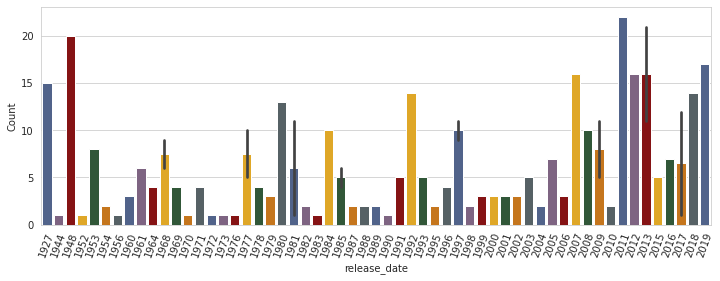

In [232]:
get_split_value_barplot(X, y, 2e2, 'release_date', xgbr_trials_10)

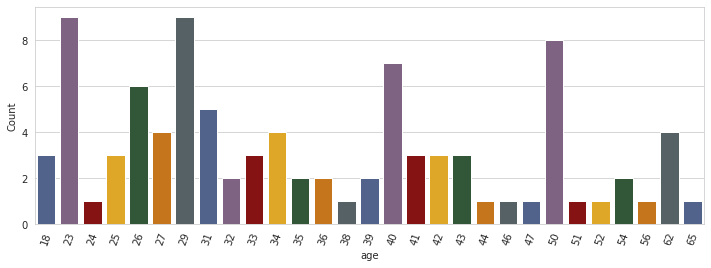

In [233]:
get_split_value_barplot(X, y, 2e2, 'age', xgbr_trials_10)

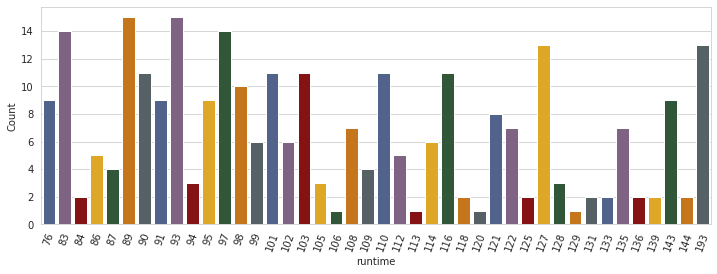

In [234]:
get_split_value_barplot(X, y, 2e2, 'runtime', xgbr_trials_10)

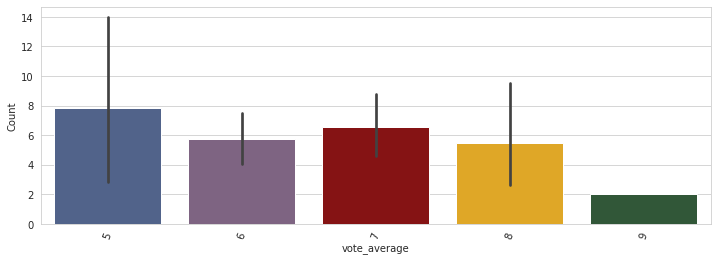

In [235]:
get_split_value_barplot(X, y, 2e2, 'vote_average', xgbr_trials_10)

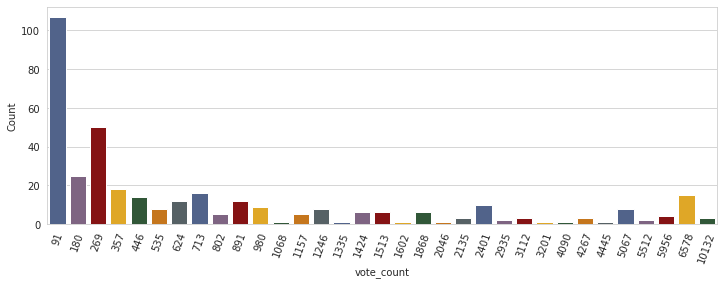

In [236]:
get_split_value_barplot(X, y, 2e2, 'vote_count', xgbr_trials_10)

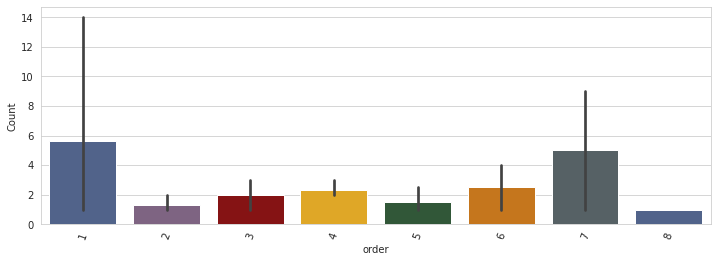

In [237]:
get_split_value_barplot(X, y, 2e2, 'order', xgbr_trials_10)

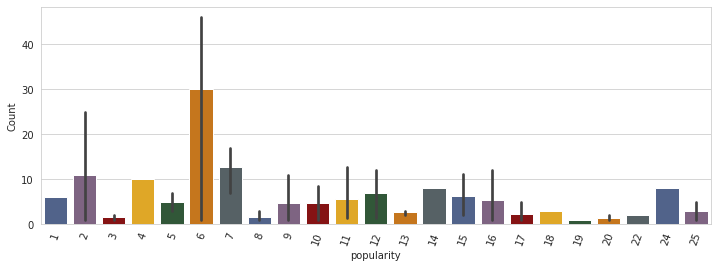

In [238]:
get_split_value_barplot(X, y, 2e2, 'popularity', xgbr_trials_10)

In [ ]:
model.get_fscore()

In [ ]:
# saving in case I want to make predictions with a trained model, this will set # of trees
n_trees = model.best_ntree_limit
# get predictions
train_preds = model.predict(dtrain, ntree_limit=n_trees)
test_preds = model.predict(dtest, ntree_limit=n_trees)

In [ ]:
# once you have an xgb model (not sklearn)
model.dump_model('dump.raw.txt')

In [ ]:
num_boost_round = model.best_iteration + 1

In [ ]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

In [ ]:
mean_absolute_error(best_model.predict(dtest), y_test)

In [ ]:
# to save XGBoost model
best_model.save_model('my_model.model')

# to load it again
loaded_model = xgb.Booster()
loaded_model.load_mode;('my_model.model')
# to use it for predictions
loaded_model.predict(dtest)

In [ ]:
test_pickle.best_trial['result']['params']

In [ ]:
pickle.load(open('xgbr_trials.pkl', 'rb'))

In [ ]:
# in case I want to check if there are multiple iterations with the same best loss value
np.sum([d['loss'] == np.min(
    [v['loss'] for v in xgbr_trials.results]) for d in xgbr_trials.results])